In [29]:
import itertools
import os
from statistics import mean
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import neighbors
from sklearn import preprocessing
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from db_handler.db_handler import DatabaseHandler

simplefilter(action='ignore', category=FutureWarning)
pd.options.display.width = 0
pd.set_option('display.max_rows', None)

connecting to MySQL database...
connection established


In [ ]:
def plot_roc_and_confusion_matrix(y_test, predicted, pred_proba, iteration=None, model_name=None, save_dir=None):
    matrix = confusion_matrix(y_test, predicted)
    # gather area under the curve
    fpr, tpr, _ = roc_curve(y_test, pred_proba[:, 1], 1)
    roc_auc = auc(fpr, tpr)
    # create the subplot for area under the curve
    fig, axs = plt.subplots(2, 2, figsize=(10, 5))
    fig.suptitle('ROC curve for fold {}'.format(iteration), fontsize=16)
    plt.subplot(1, 2, 1)
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Song - Video Matches - %03s ROC' % (model_name))
    plt.legend(loc="lower right")
    # create the subplot for confusion matrix
    plt.subplot(1, 2, 2)
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix, %03s' % (model_name))
    plt.colorbar()
    tick_marks = np.arange(len([0, 1]))
    plt.xticks(tick_marks, [0, 1], rotation=45)
    plt.yticks(tick_marks, [0, 1])
    fmt = 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    fig.subplots_adjust(top=0.88)
    if save_dir:
        try:
            plt.savefig(save_dir + "roc_" + str(model_name) + "_" + str(iteration) + ".png")
        except FileNotFoundError:
            oldmask = os.umask(000)
            os.makedirs(save_dir, exist_ok=True, mode=0o755)
            os.umask(oldmask)
            plt.savefig(save_dir + "roc_" + str(model_name) + "_" + str(iteration) + ".png")
    else:
        plt.show()

In [30]:
db = DatabaseHandler('file_system_catalogs')
db_connection = db.connection
feat_tables = ['audio_features', 'video_features', 'symbolic_features']
for table in feat_tables:
    if not db.check_for_existing_tables(table=table):
        raise BaseException("The {} table is missing. Run extract_features.py".format(table))

with open('db_handler/sql/collect_features_for_model.sql') as q_file:
    sql = q_file.read()
    data = pd.read_sql(sql=sql, con=db_connection, index_col='id')

data = data.drop(labels=['audio_id', 'clip_id', 'midi_id'], axis=1)

desc = data.describe().T

In [31]:
total_instances = data.y.count()
match = data.y.sum()
fake = data.y.count() - match
print('Total data points: ' + str(total_instances) +
      '\nNumber of matches: ' + str(match) +
      '\nNumber of fakes: ' + str(fake)+
      '\nNumber of columns: ' + str(len(data.columns)-3))
empty_cols = [col for col in data.columns if (data[col] == 0).all()]
print('The number of columns with only zero values is: {}'.format(str(len(empty_cols))))
print('These are:')
for col in empty_cols:
    print(col)

Total data points: 136
Number of matches: 68
Number of fakes: 68
The number of columns with only zero values is: 10
These are:
delta chroma_8_mean
QuintupleMeterFeature
ComposerPopularity
LanguageFeature
outdoor_freq
sports_freq
outdoor_mean_confidence
sports_mean_confidence
outdoor_mean_area_ratio
sports_mean_area_ratio


In [ ]:
print("We remove those from the dataset")
data = data.drop(empty_cols, axis=1)

In [ ]:
cols_with_nas = [col for col in data.columns if len(data[data[col].isna()])>0.4*len(data)]
if len(cols_with_nas) == 0:
    print("There are no columns with more than 40% empty values")
else:
    print("We have removed the following columns because they were more than 40% empty:")
    for col in cols_with_nas:
        print(col)
    data = data.drop(cols_with_nas, axis=1)


In [32]:
X = data.drop(['y', 'video_id'], axis=1)
groups = data['video_id']
y = data.y

In [33]:
print('The maximum value in the dataframe is: ' + str(X.max().max()))
print('The minimum value in the dataframe is: ' + str(X.min().min()))
print('The mean value in the dataframe is: ' + str(round(X.mean().mean(),3)))

The maximum value in the dataframe is: 8105.1424
The minimum value in the dataframe is: -28.57613
The mean value in the dataframe is: 9.78


In [34]:
corr = X.corr(method='pearson')
corr_a = corr.abs()
s = corr_a.unstack().sort_values(kind="quicksort")
pairs = set(s[s > 0.7].index)
clean_pairs = set([tuple(sorted(i)) for i in pairs if i[0] != i[1]])
print('There are ' + str(len(clean_pairs)) + ' pairs with at least 80% correlation.')
print('The top 15 are:')
for pair in sorted(clean_pairs)[0:15]:
    print(pair)

There are 1057 pairs with at least 70% correlation.
The top 15 are:
('AmountOfArpeggiationFeature', 'AverageMelodicIntervalFeature')
('AmountOfArpeggiationFeature', 'MostCommonMelodicIntervalPrevalenceFeature')
('AmountOfArpeggiationFeature', 'RepeatedNotesFeature')
('AverageMelodicIntervalFeature', 'MaximumNumberOfIndependentVoicesFeature')
('AverageMelodicIntervalFeature', 'MostCommonMelodicIntervalPrevalenceFeature')
('AverageMelodicIntervalFeature', 'SizeOfMelodicArcsFeature')
('AverageMelodicIntervalFeature', 'VariabilityOfNumberOfIndependentVoicesFeature')
('AverageNoteDurationFeature', 'AverageTimeBetweenAttacksFeature')
('AverageNoteDurationFeature', 'VariabilityOfNoteDurationFeature')
('AverageNumberOfIndependentVoicesFeature', 'MaximumNumberOfIndependentVoicesFeature')
('AverageNumberOfIndependentVoicesFeature', 'VariabilityOfNumberOfIndependentVoicesFeature')
('AverageVariabilityOfTimeBetweenAttacksForEachVoiceFeature', 'MaximumNumberOfIndependentVoicesFeature')
('AverageVar

In [ ]:
singles = []
drops = []

# only keep one for each pair of highly correlated features.
for pair in sorted(clean_pairs):
    if pair[1] not in drops:
        drops.append(pair[1])
    if pair[0] not in drops and pair[0] not in singles:
        singles.append(pair[0])
# keep = [col for col in X.columns if col in singles or col not in drops]

# X = X[keep]
X = X[singles]

In [35]:
logo = LeaveOneGroupOut()
logo.get_n_splits(X,y,groups)


33

In [36]:
imp = SimpleImputer(missing_values=np.NaN, strategy='mean')
min_max_scaler = preprocessing.MinMaxScaler()
#cachedir = setup_cache_temp_folder()

#pipe = make_pipeline([imp,min_max_scaler],  memory=cachedir)

In [37]:
#we choose a common seed for all algorithms
seed = 2015
#we choose a common number of trees for ensembles
num_trees = 100

models = []
models.append(('Decision Tree',  DecisionTreeClassifier(criterion='entropy',max_depth=10,random_state = seed)))
models.append(('Logistic Regression',  LogisticRegression(random_state = seed,solver='liblinear')))
models.append(('kNN', neighbors.KNeighborsClassifier(n_neighbors = 3, weights='uniform', n_jobs=-1)))
models.append(('SVM', svm.SVC(kernel='rbf', C=1,gamma='auto',cache_size = 12288, probability=True)))
models.append(('Random Forest', RandomForestClassifier(n_estimators=num_trees, max_depth=10,n_jobs=-1,random_state=seed)))
models.append(('Bagged Trees', BaggingClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',max_depth=10,random_state = seed),
                                                 n_estimators=num_trees, random_state=seed, n_jobs=-1)))
models.append(('AdaBoost',AdaBoostClassifier(n_estimators=num_trees, random_state=seed)))
models.append(('XGBoost',XGBClassifier(nthread=8)))

In [38]:
def plot_roc_and_confusion_matrix(y_test,predicted, pred_proba, iteration=None, model_name=None, save_dir=None):
        matrix = confusion_matrix(y_test, predicted)
        # gather area under the curve
        fpr, tpr, _ = roc_curve(y_test, pred_proba[:, 1], 1)
        roc_auc = auc(fpr, tpr)
        # create the subplot for area under the curve
        fig, axs = plt.subplots(2, 2, figsize=(10, 5))
        fig.suptitle('ROC curve for fold {}'.format(iteration), fontsize=16)
        plt.subplot(1, 2, 1)
        lw = 2
        plt.plot(fpr, tpr, color='darkorange',
                 lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Song - Video Matches - %03s ROC' % (model_name))
        plt.legend(loc="lower right")
        # create the subplot for confusion matrix
        plt.subplot(1, 2, 2)
        plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Confusion matrix, %03s' % (model_name))
        plt.colorbar()
        tick_marks = np.arange(len([0,1]))
        plt.xticks(tick_marks, [0,1], rotation=45)
        plt.yticks(tick_marks, [0,1])
        fmt = 'd'
        thresh = matrix.max() / 2.
        for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
            plt.text(j, i, format(matrix[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if matrix[i, j] > thresh else "black")

        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        fig.subplots_adjust(top=0.88)
        plt.show()
        if save_dir:
            try:
                plt.savefig(save_dir+"roc_"+str(model_name)+"_"+str(iteration)+".png")
            except FileNotFoundError:
                oldmask = os.umask(000)
                os.makedirs(save_dir, exist_ok=True, mode=0o755)
                os.umask(oldmask)
                plt.savefig(save_dir+"roc_"+str(model_name)+"_"+str(iteration)+".png")




In [39]:
fold_results = {}
for name, model in models:
    fold_results[name]=    {
                'accuracy':[],
                'precision':[],
                'recall':[],
                'f1':[]
    }


Decision Tree: Accuracy: 0.20 Precision: 0.25 Recall: 0.50 F_1 score: 0.33
Logistic Regression: Accuracy: 0.40 Precision: 0.33 Recall: 0.50 F_1 score: 0.40
kNN: Accuracy: 0.20 Precision: 0.25 Recall: 0.50 F_1 score: 0.33
SVM: Accuracy: 0.40 Precision: 0.40 Recall: 1.00 F_1 score: 0.57
Random Forest: Accuracy: 0.60 Precision: 0.50 Recall: 1.00 F_1 score: 0.67
Bagged Trees: Accuracy: 0.60 Precision: 0.50 Recall: 0.50 F_1 score: 0.50
AdaBoost: Accuracy: 0.60 Precision: 0.50 Recall: 1.00 F_1 score: 0.67
[16:01:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost: Accuracy: 0.40 Precision: 0.40 Recall: 1.00 F_1 score: 0.57
Decision Tree: Accuracy: 0.33 Precision: 0.33 Recall: 1.00 F_1 score: 0.50
Logistic Regression: Accuracy: 0.00 Precision: 0.00 Recall: 0.00 F_1 score: 0.00
kNN: Accuracy: 0.3

/home/zappatistas20/PycharmProjects/venvs/thesis_dataset_creation/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass pos_label=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/zappatistas20/PycharmProjects/venvs/thesis_dataset_creation/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass pos_label=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/zappatistas20/PycharmProjects/venvs/thesis_dataset_creation/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass pos_label=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/zappatistas20/PycharmProjects/venvs/thesis_dataset_creation/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass pos_label=1 as keyword args. From vers

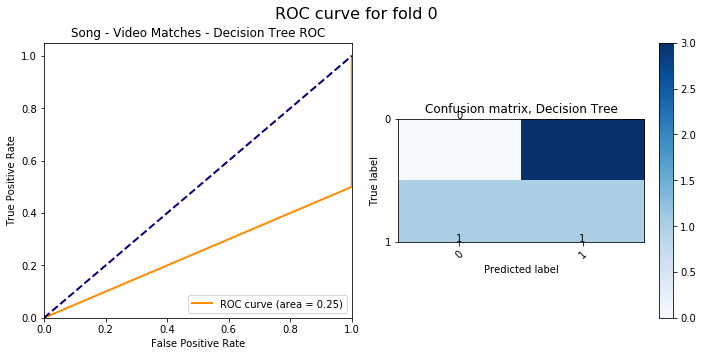

<Figure size 432x288 with 0 Axes>

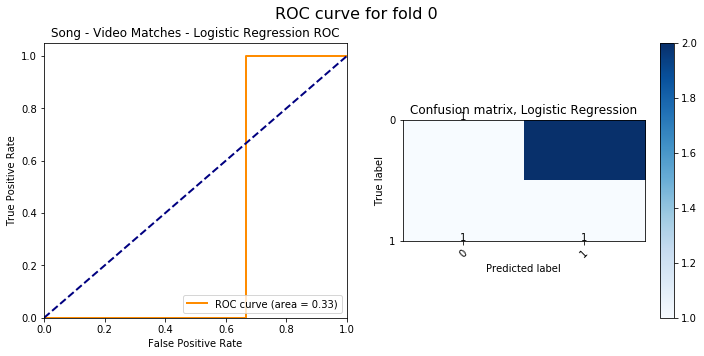

<Figure size 432x288 with 0 Axes>

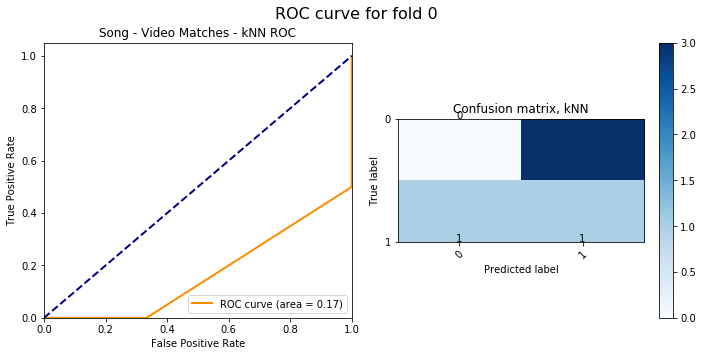

<Figure size 432x288 with 0 Axes>

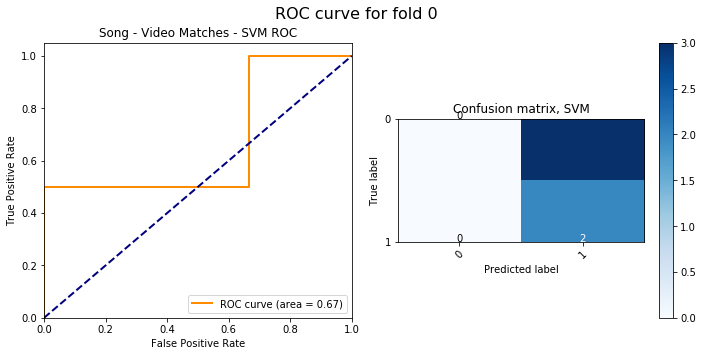

<Figure size 432x288 with 0 Axes>

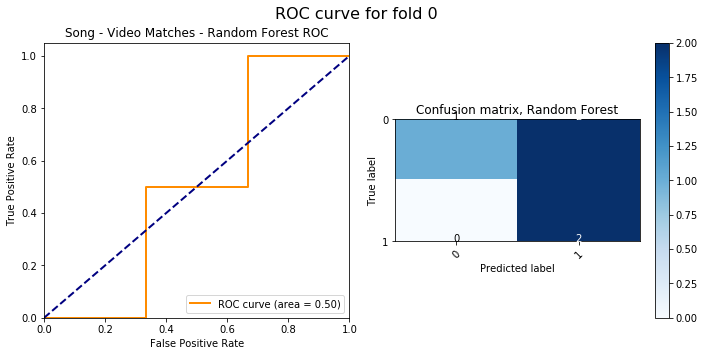

<Figure size 432x288 with 0 Axes>

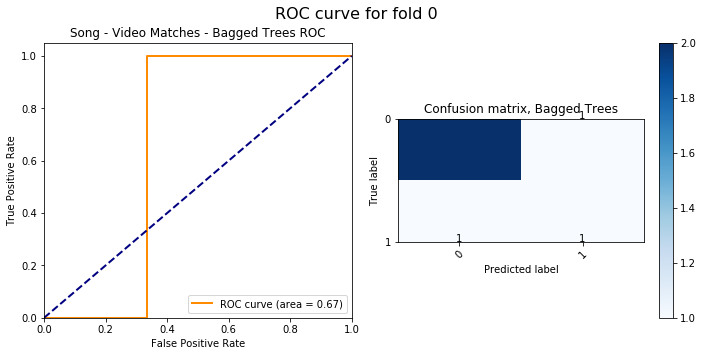

<Figure size 432x288 with 0 Axes>

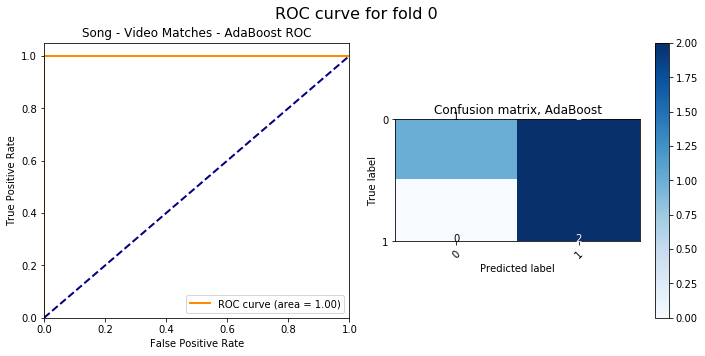

<Figure size 432x288 with 0 Axes>

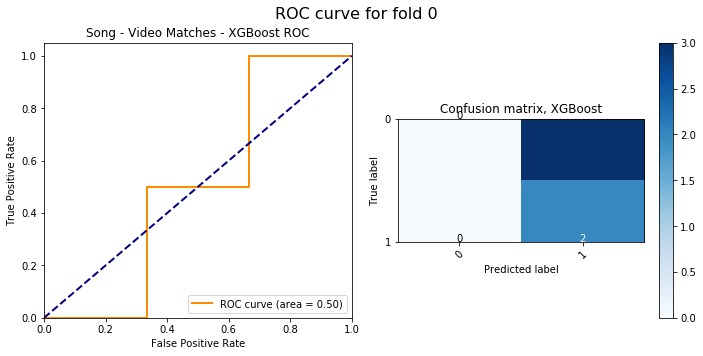

<Figure size 432x288 with 0 Axes>

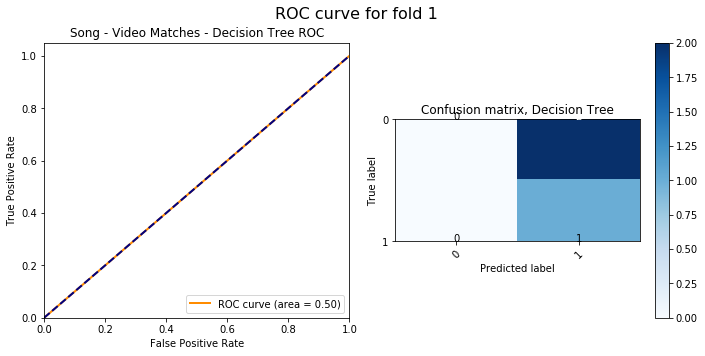

<Figure size 432x288 with 0 Axes>

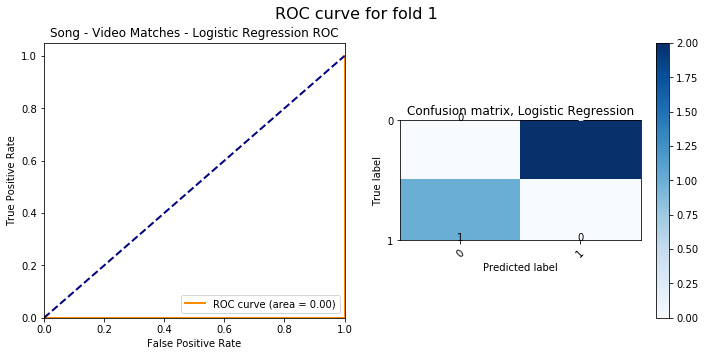

<Figure size 432x288 with 0 Axes>

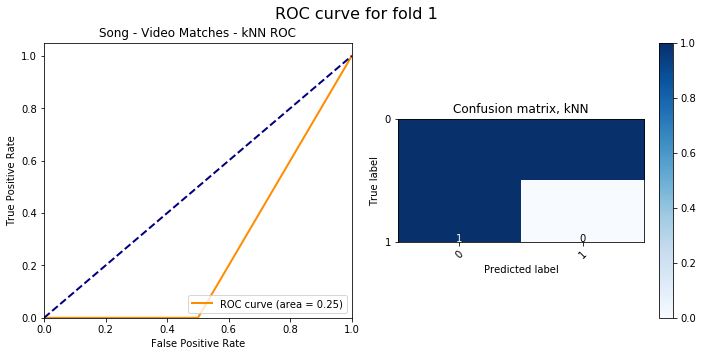

<Figure size 432x288 with 0 Axes>

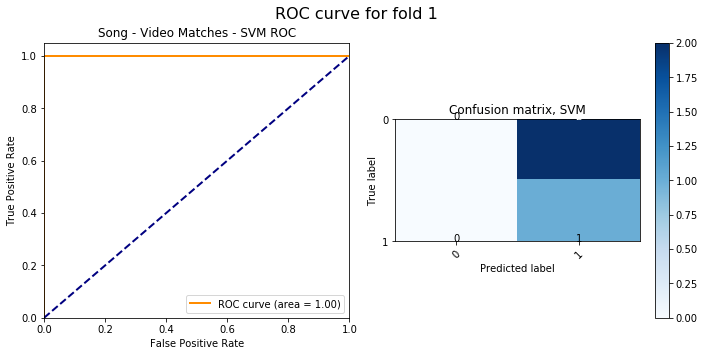

<Figure size 432x288 with 0 Axes>

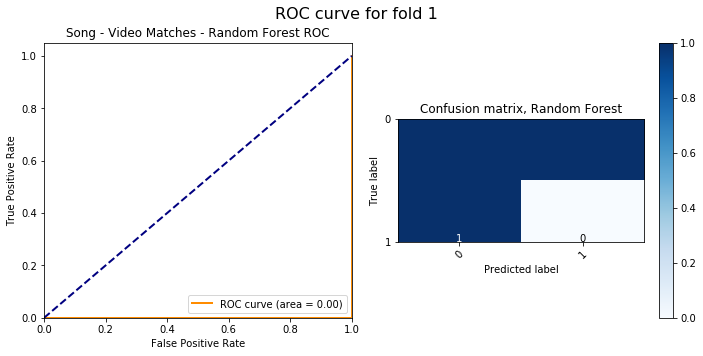

<Figure size 432x288 with 0 Axes>

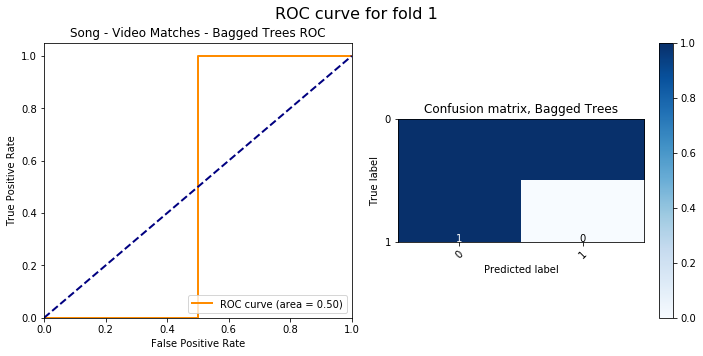

<Figure size 432x288 with 0 Axes>

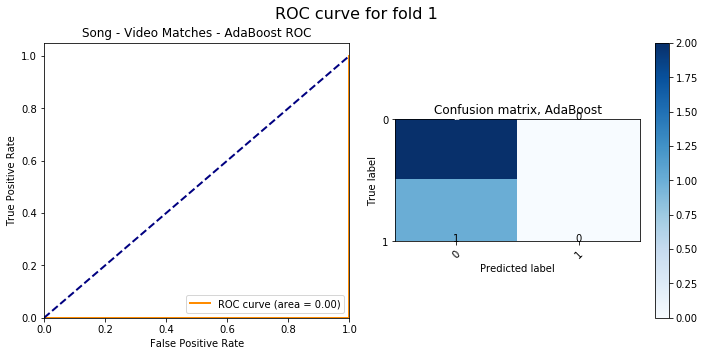

<Figure size 432x288 with 0 Axes>

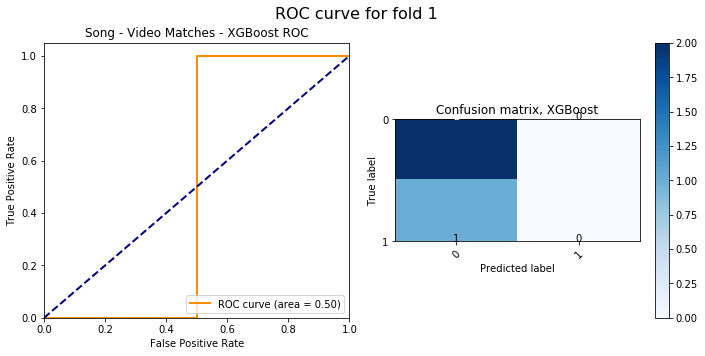

<Figure size 432x288 with 0 Axes>

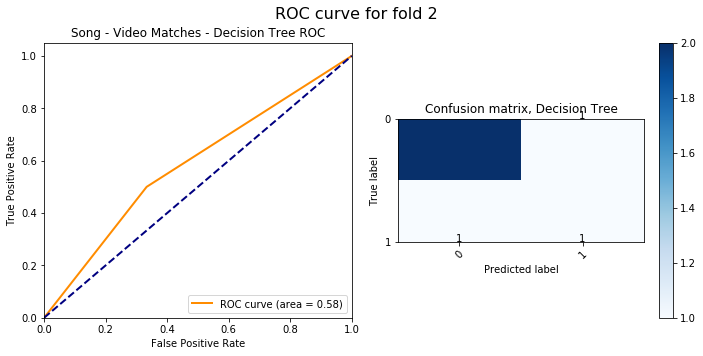

<Figure size 432x288 with 0 Axes>

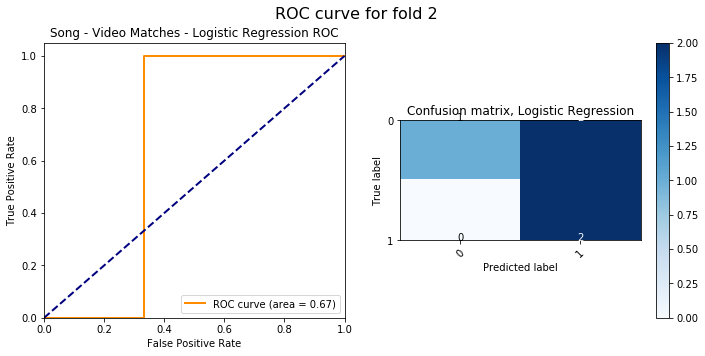

<Figure size 432x288 with 0 Axes>

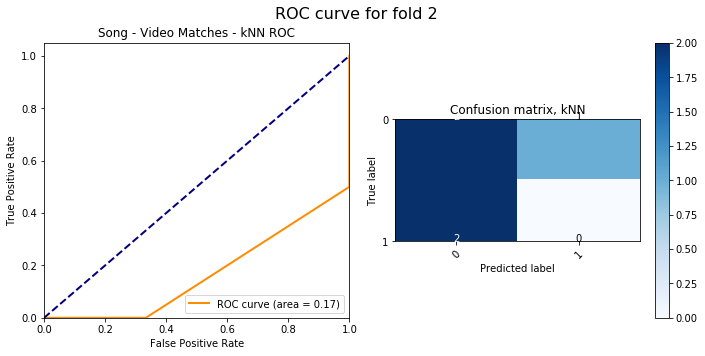

<Figure size 432x288 with 0 Axes>

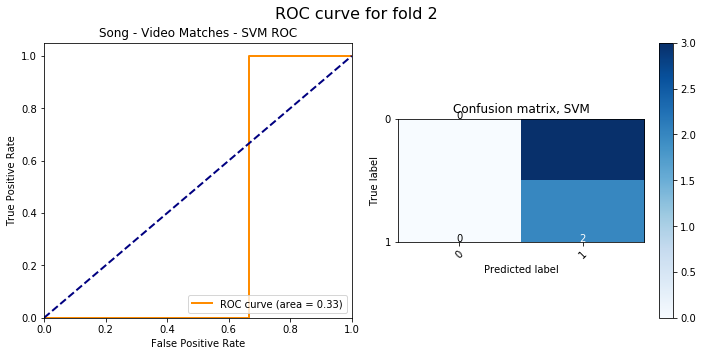

<Figure size 432x288 with 0 Axes>

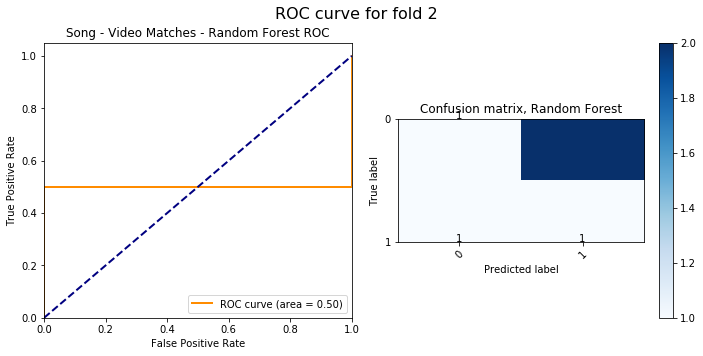

<Figure size 432x288 with 0 Axes>

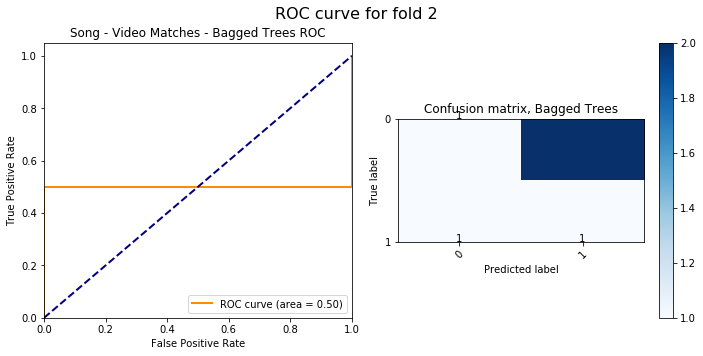

<Figure size 432x288 with 0 Axes>

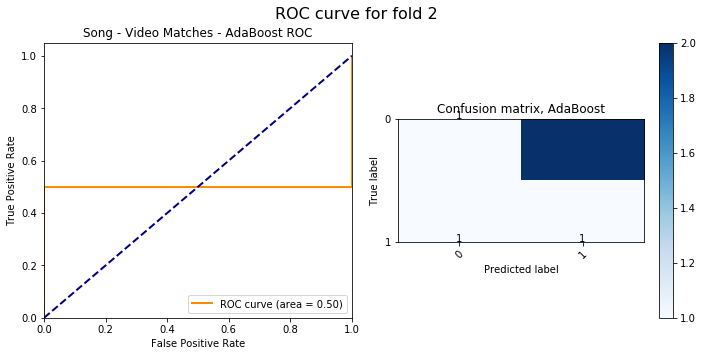

<Figure size 432x288 with 0 Axes>

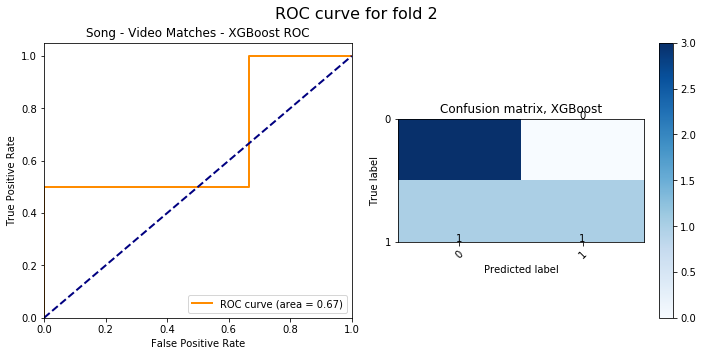

<Figure size 432x288 with 0 Axes>

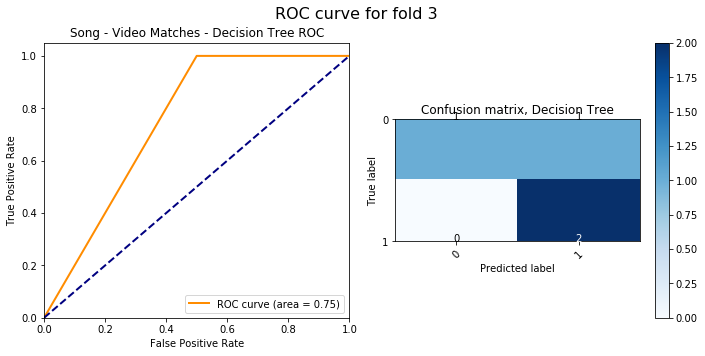

<Figure size 432x288 with 0 Axes>

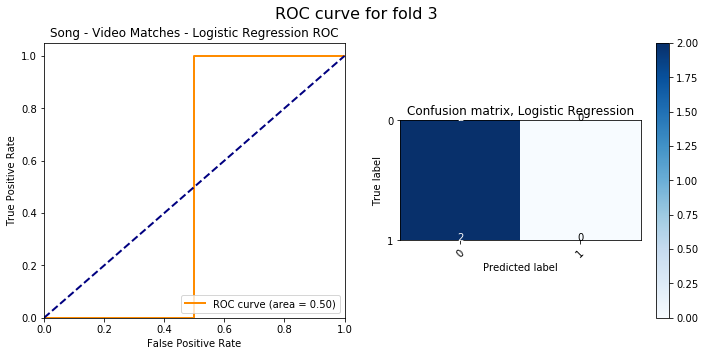

<Figure size 432x288 with 0 Axes>

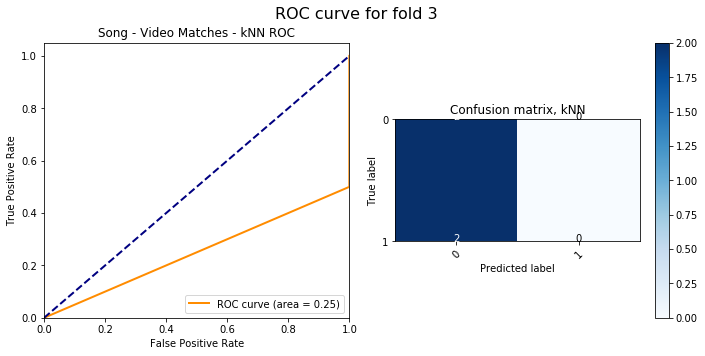

<Figure size 432x288 with 0 Axes>

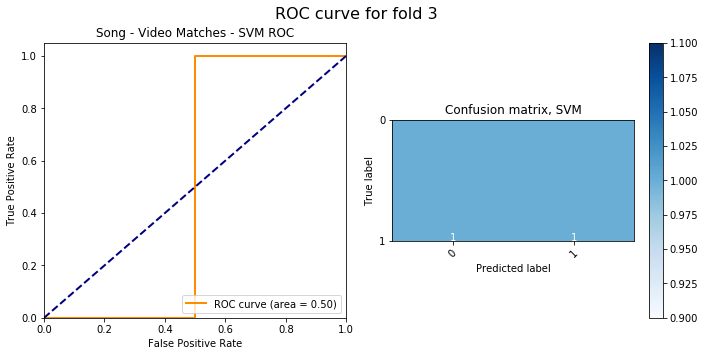

<Figure size 432x288 with 0 Axes>

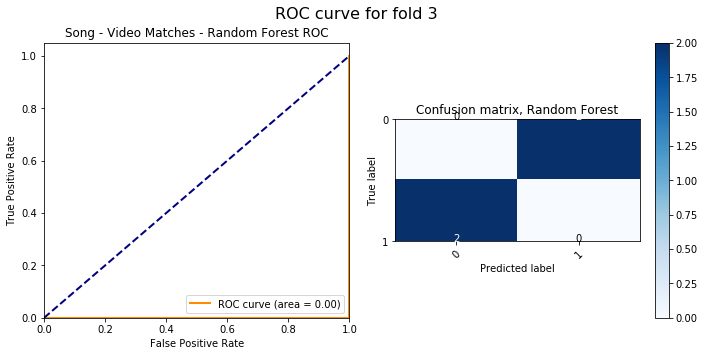

<Figure size 432x288 with 0 Axes>

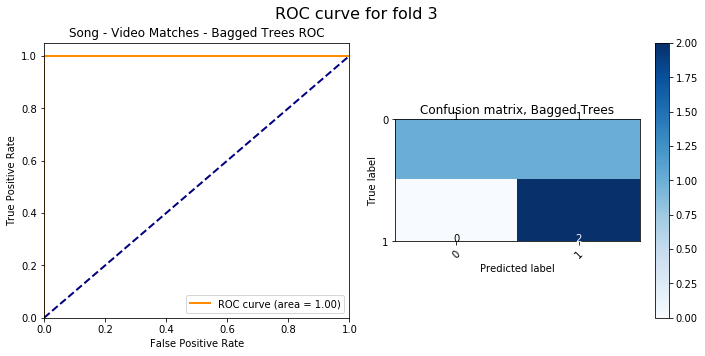

<Figure size 432x288 with 0 Axes>

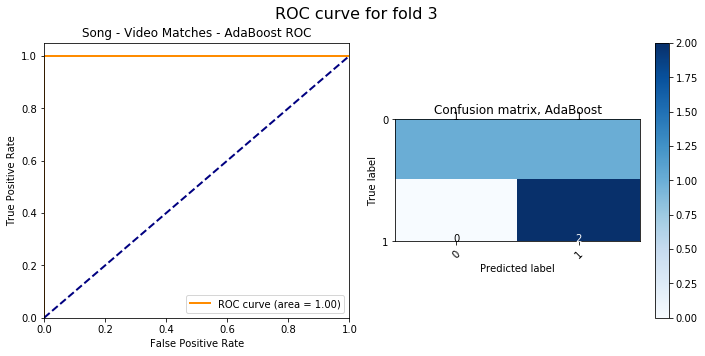

<Figure size 432x288 with 0 Axes>

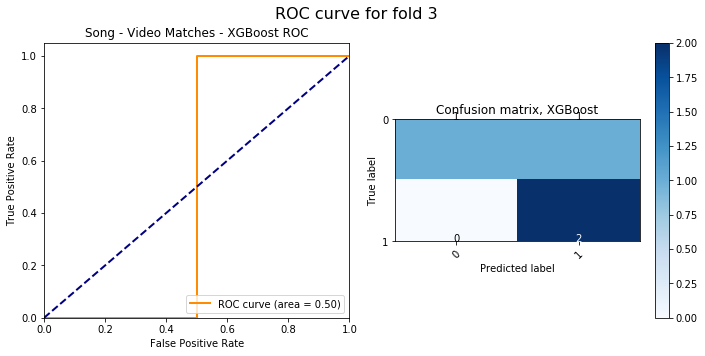

<Figure size 432x288 with 0 Axes>

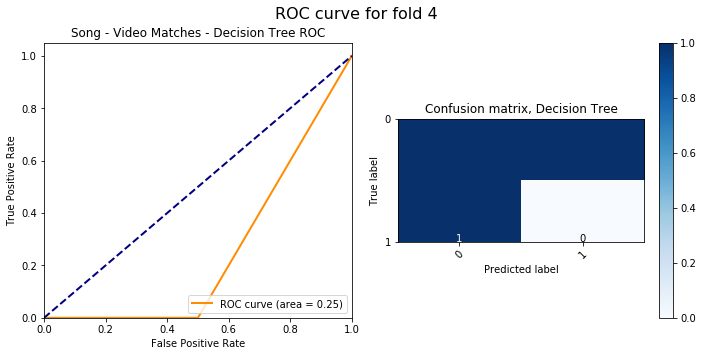

<Figure size 432x288 with 0 Axes>

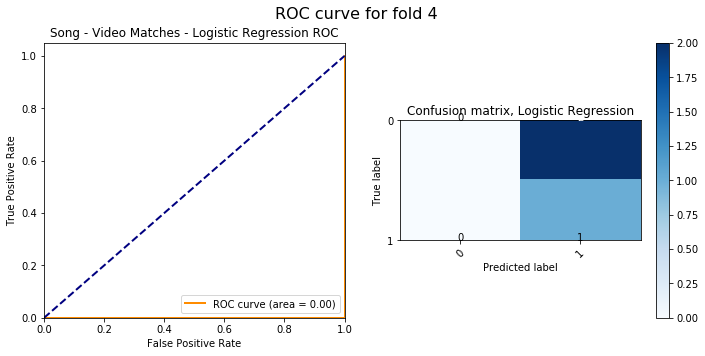

<Figure size 432x288 with 0 Axes>

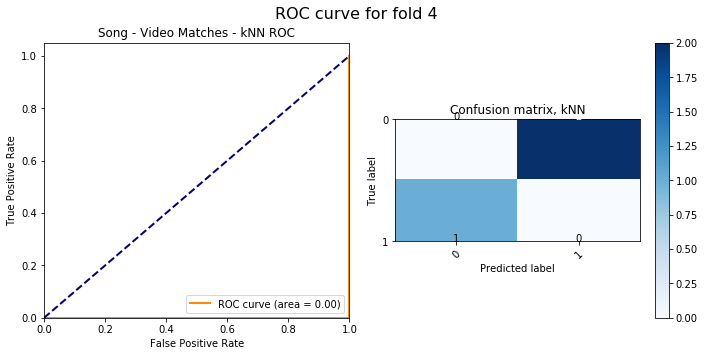

<Figure size 432x288 with 0 Axes>

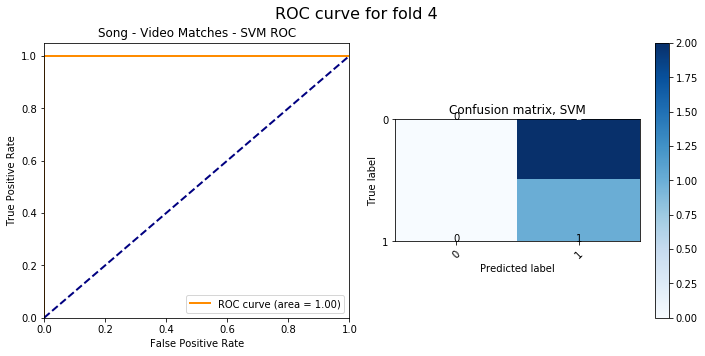

<Figure size 432x288 with 0 Axes>

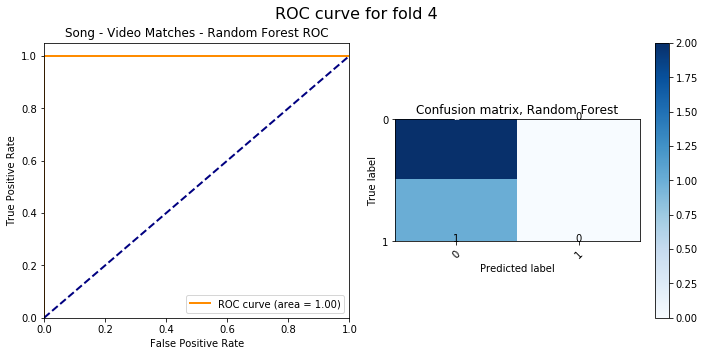

<Figure size 432x288 with 0 Axes>

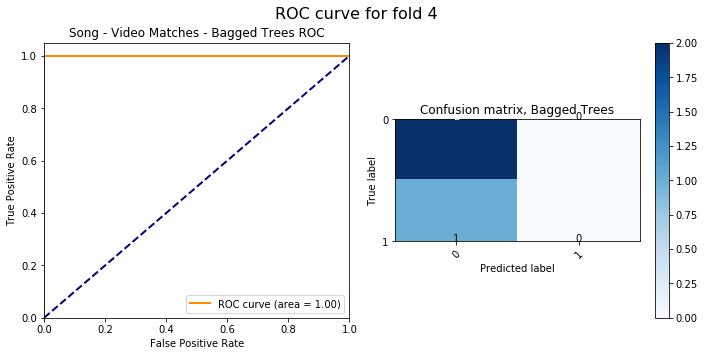

<Figure size 432x288 with 0 Axes>

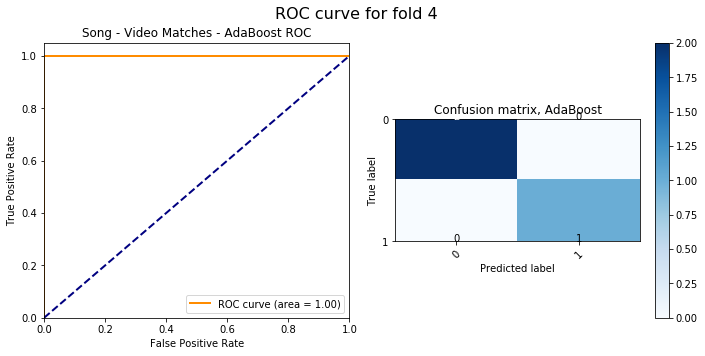

<Figure size 432x288 with 0 Axes>

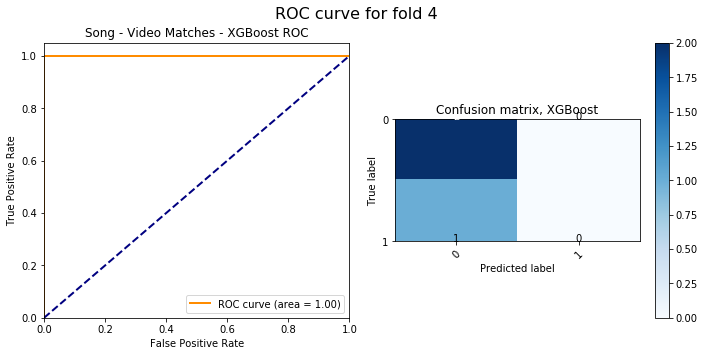

<Figure size 432x288 with 0 Axes>

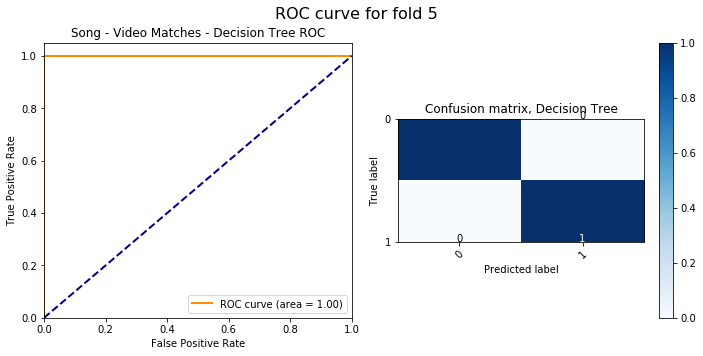

<Figure size 432x288 with 0 Axes>

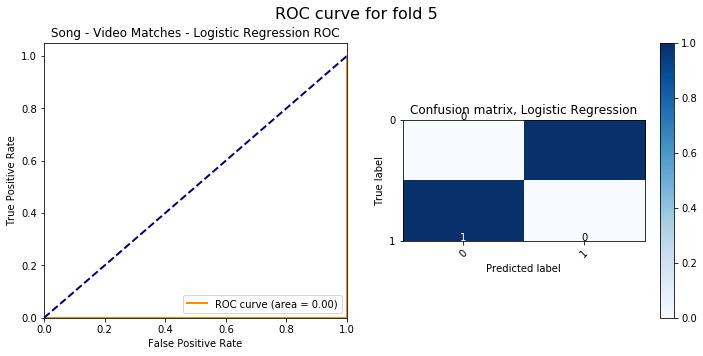

<Figure size 432x288 with 0 Axes>

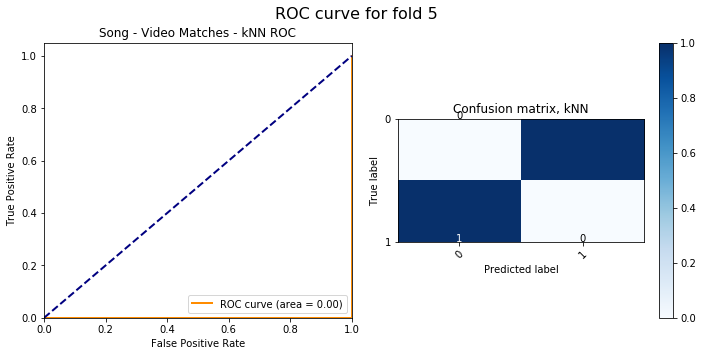

<Figure size 432x288 with 0 Axes>

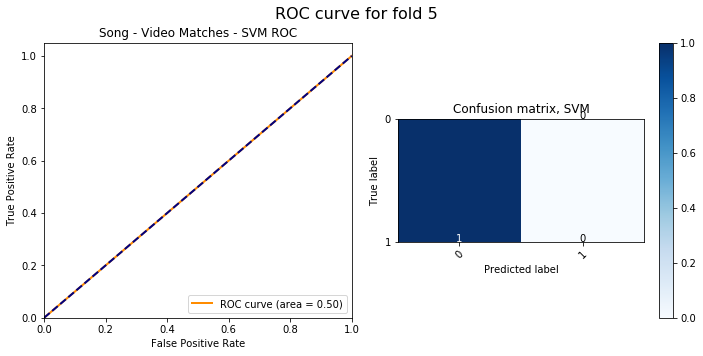

<Figure size 432x288 with 0 Axes>

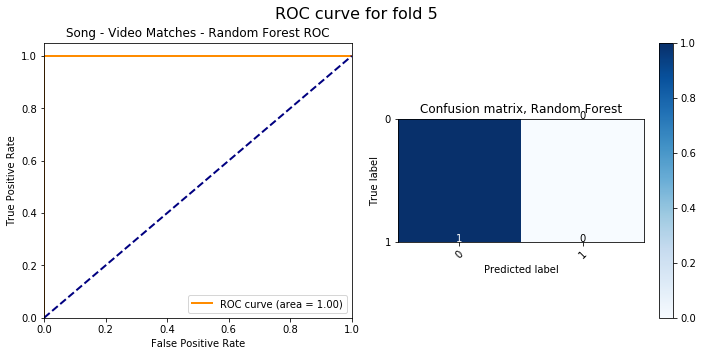

<Figure size 432x288 with 0 Axes>

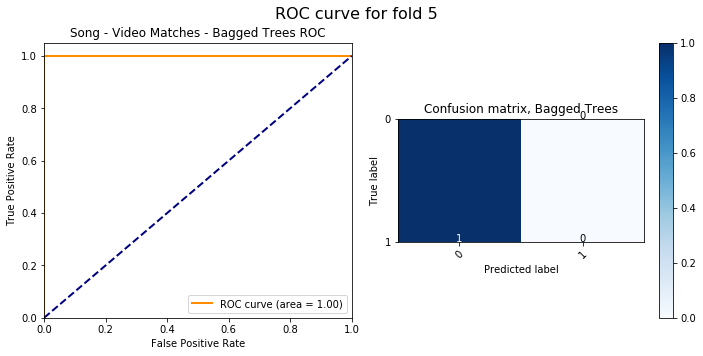

<Figure size 432x288 with 0 Axes>

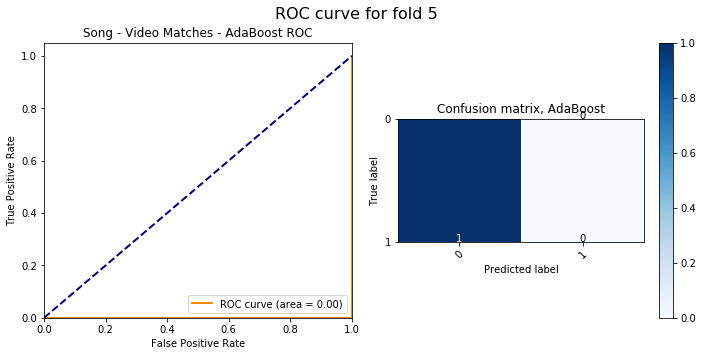

<Figure size 432x288 with 0 Axes>

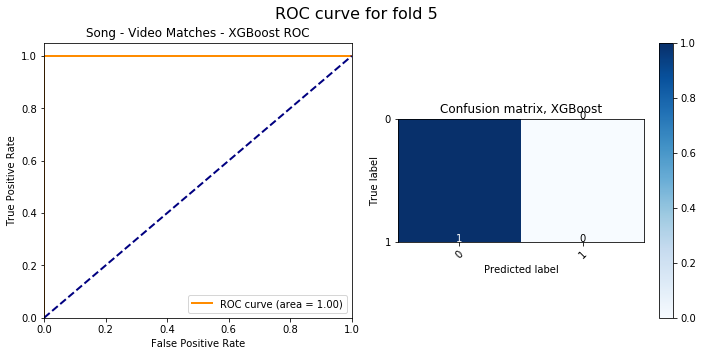

<Figure size 432x288 with 0 Axes>

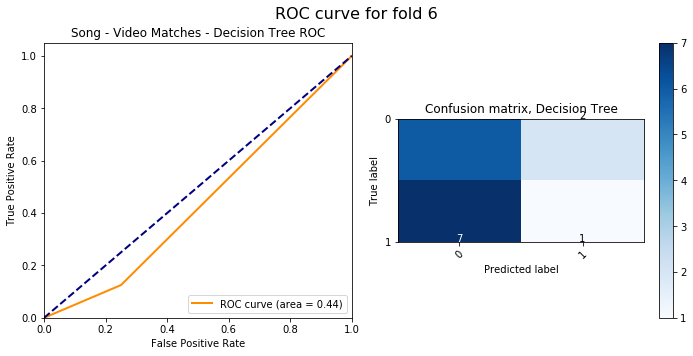

<Figure size 432x288 with 0 Axes>

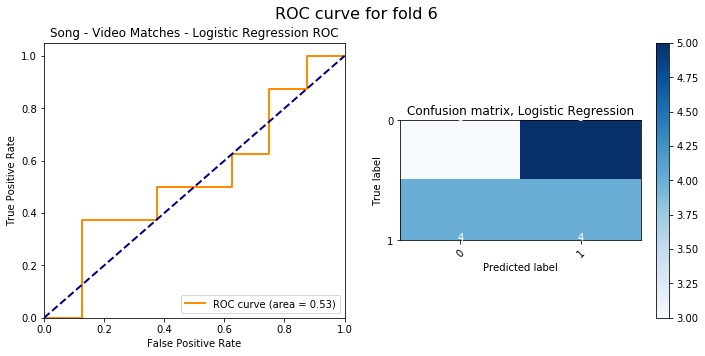

<Figure size 432x288 with 0 Axes>

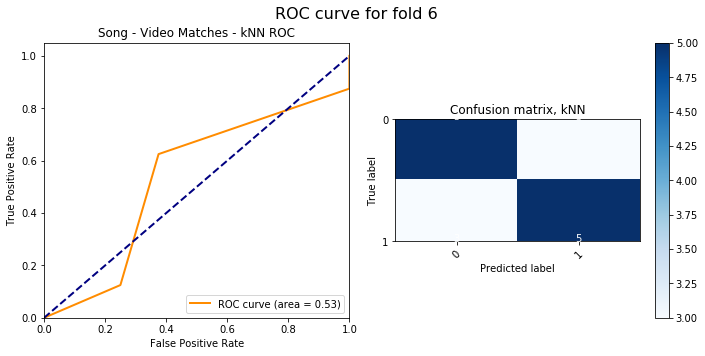

<Figure size 432x288 with 0 Axes>

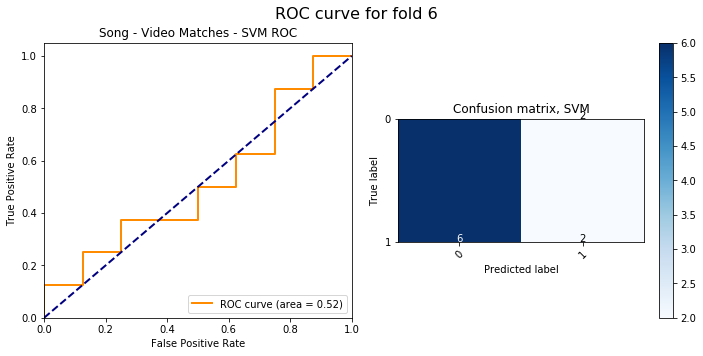

<Figure size 432x288 with 0 Axes>

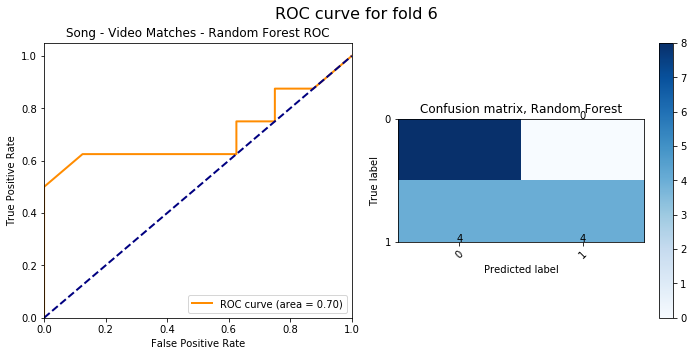

<Figure size 432x288 with 0 Axes>

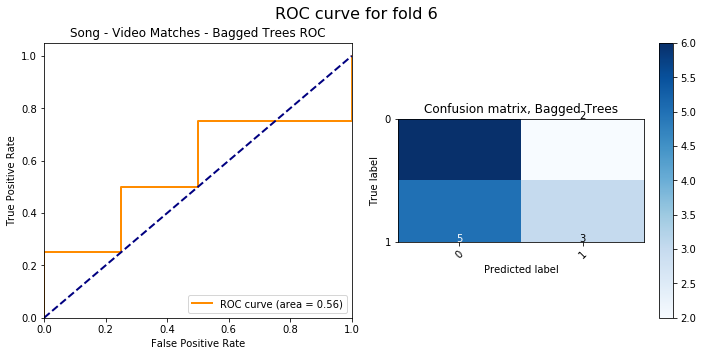

<Figure size 432x288 with 0 Axes>

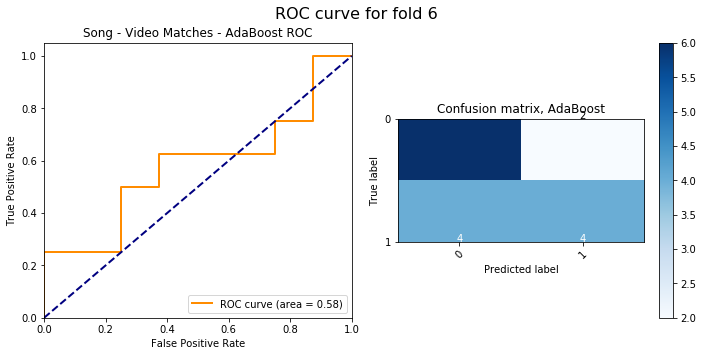

<Figure size 432x288 with 0 Axes>

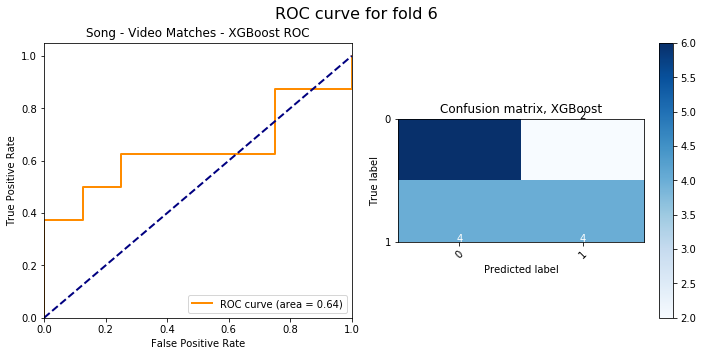

<Figure size 432x288 with 0 Axes>

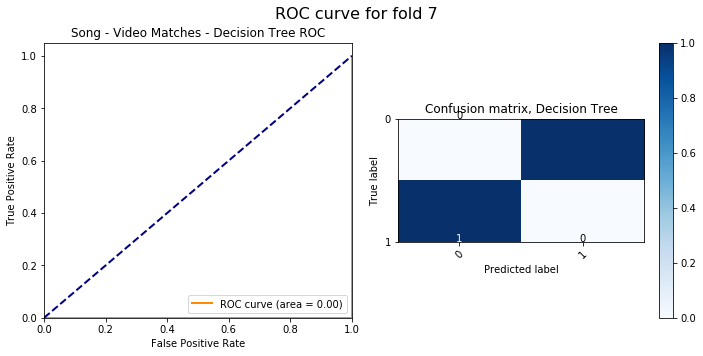

<Figure size 432x288 with 0 Axes>

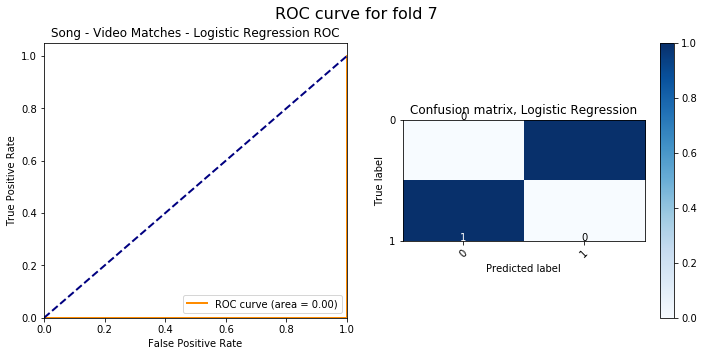

<Figure size 432x288 with 0 Axes>

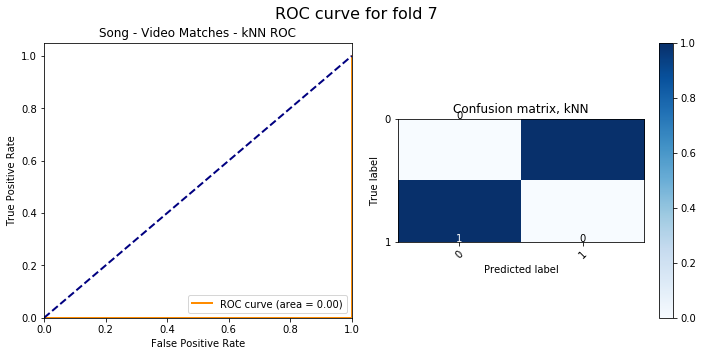

<Figure size 432x288 with 0 Axes>

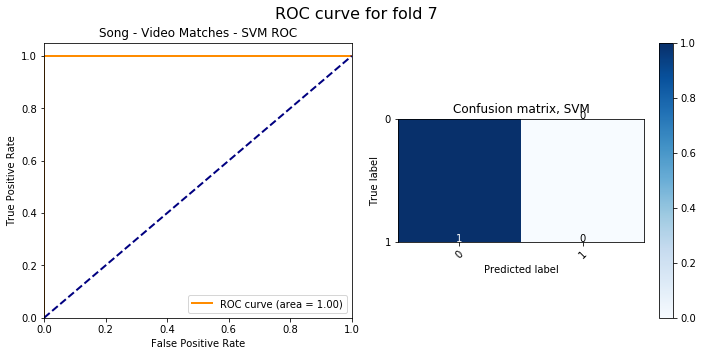

<Figure size 432x288 with 0 Axes>

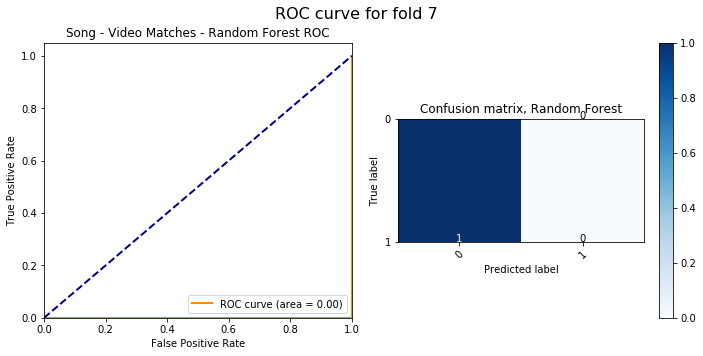

<Figure size 432x288 with 0 Axes>

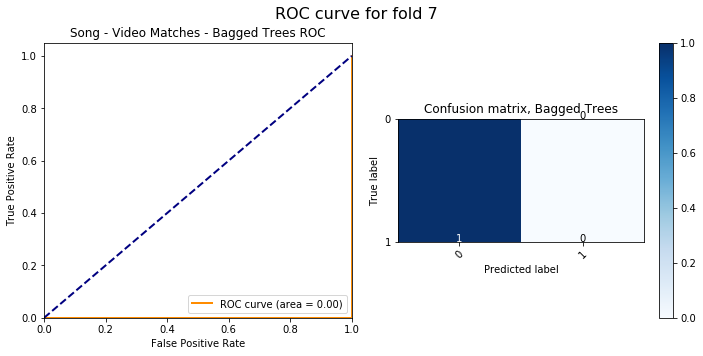

<Figure size 432x288 with 0 Axes>

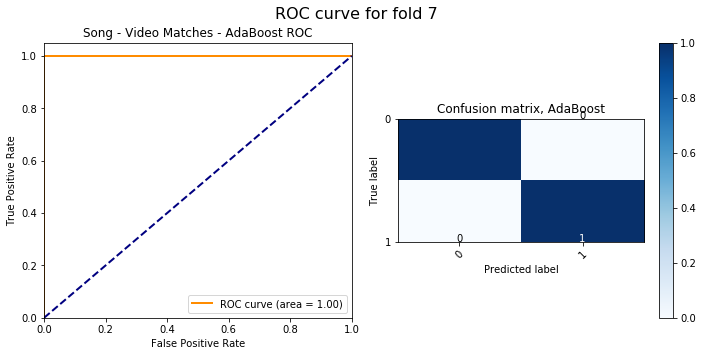

<Figure size 432x288 with 0 Axes>

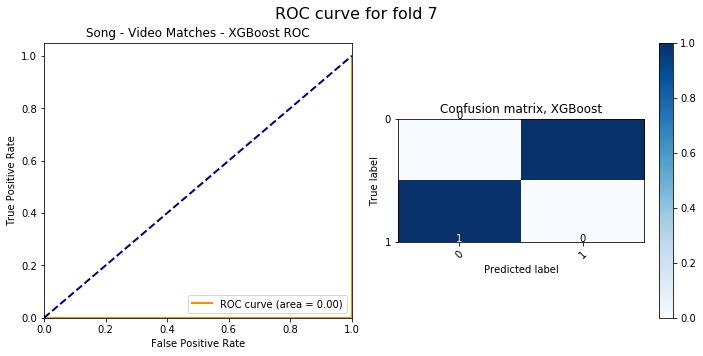

<Figure size 432x288 with 0 Axes>

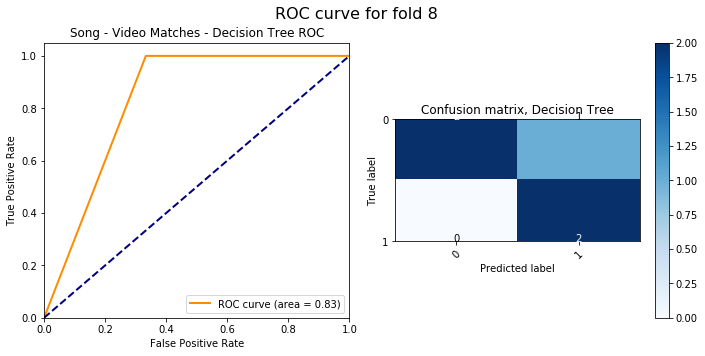

<Figure size 432x288 with 0 Axes>

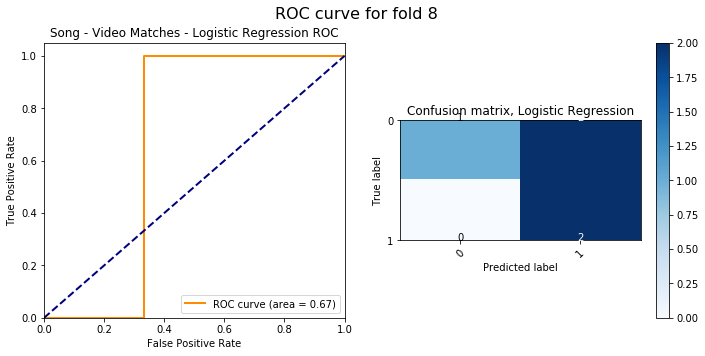

<Figure size 432x288 with 0 Axes>

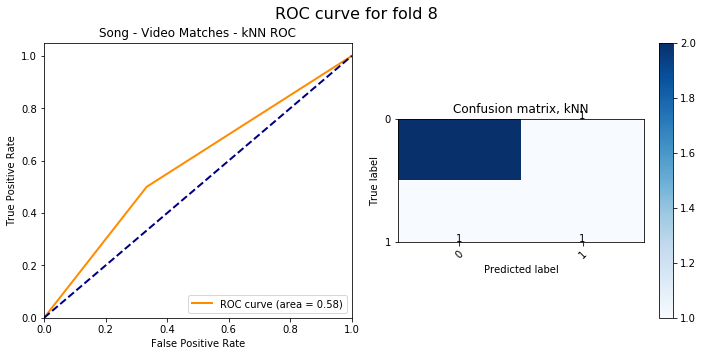

<Figure size 432x288 with 0 Axes>

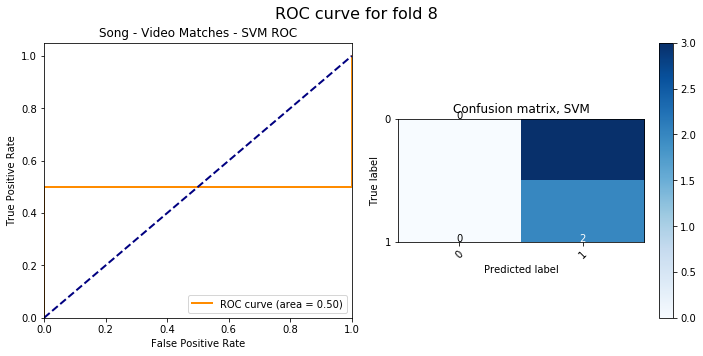

<Figure size 432x288 with 0 Axes>

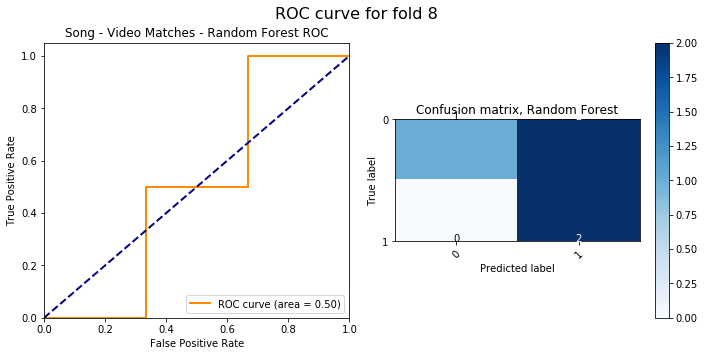

<Figure size 432x288 with 0 Axes>

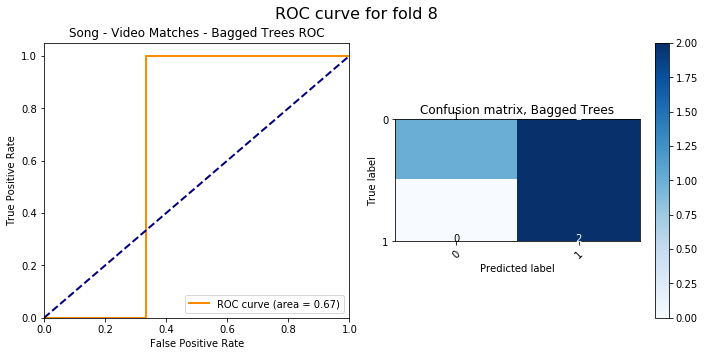

<Figure size 432x288 with 0 Axes>

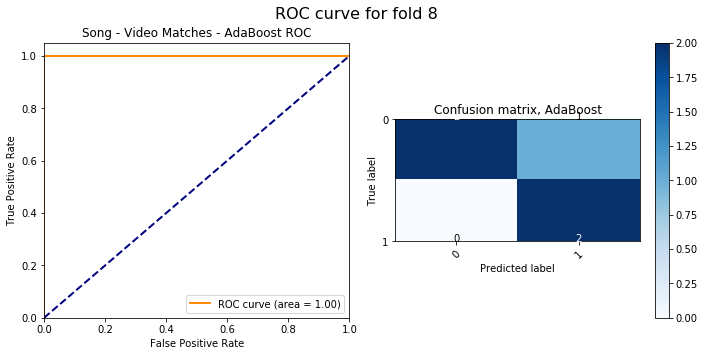

<Figure size 432x288 with 0 Axes>

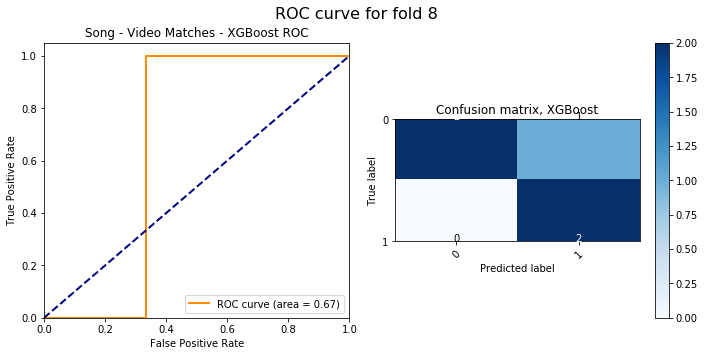

<Figure size 432x288 with 0 Axes>

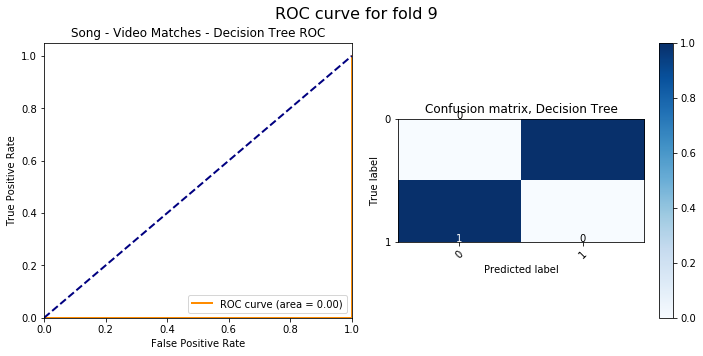

<Figure size 432x288 with 0 Axes>

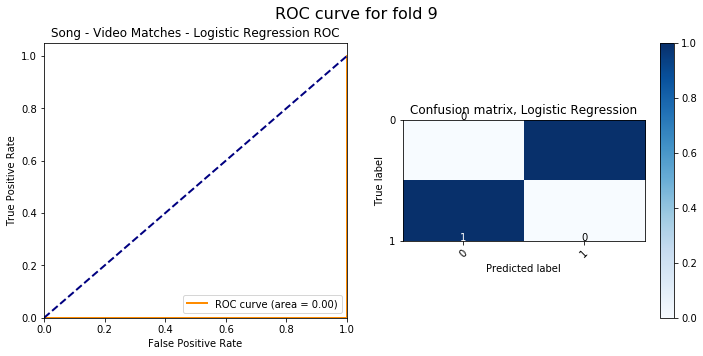

<Figure size 432x288 with 0 Axes>

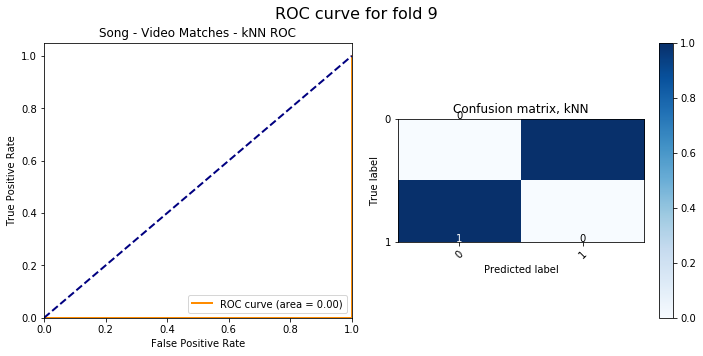

<Figure size 432x288 with 0 Axes>

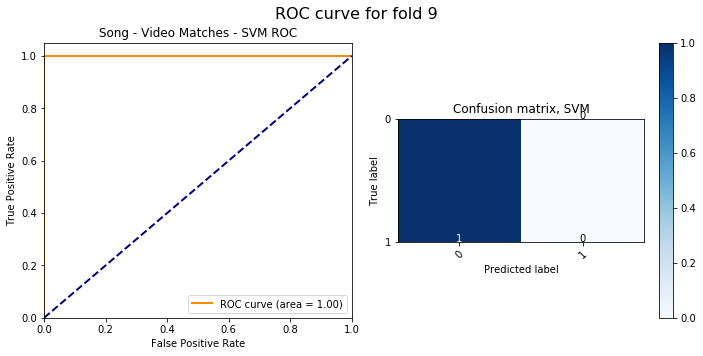

<Figure size 432x288 with 0 Axes>

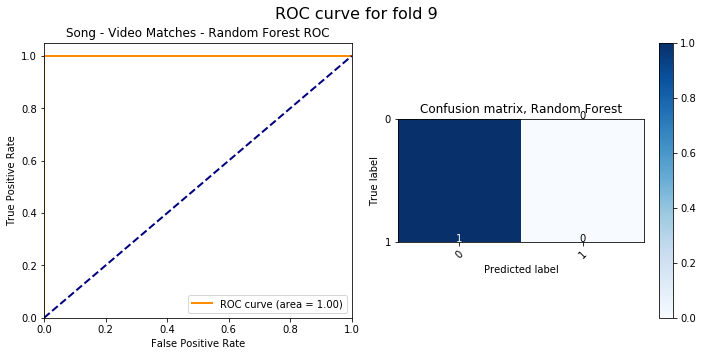

<Figure size 432x288 with 0 Axes>

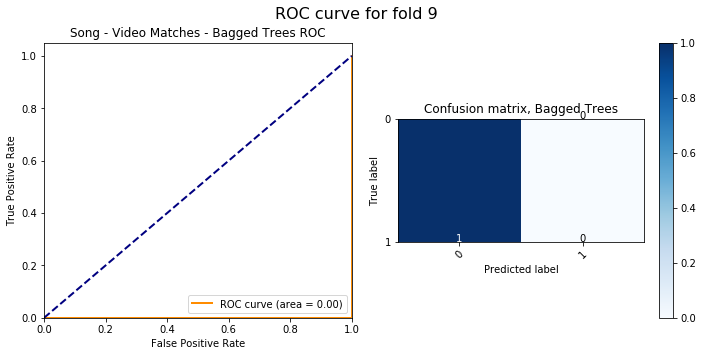

<Figure size 432x288 with 0 Axes>

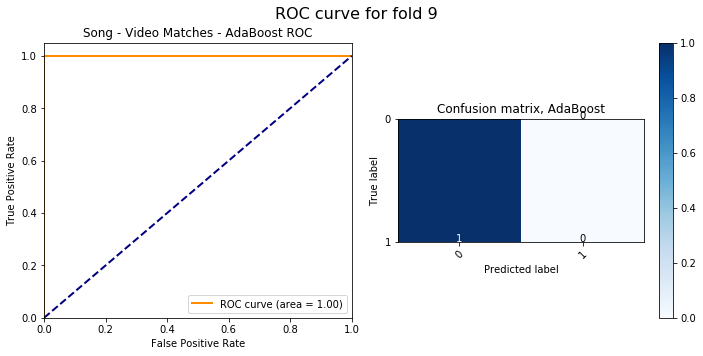

<Figure size 432x288 with 0 Axes>

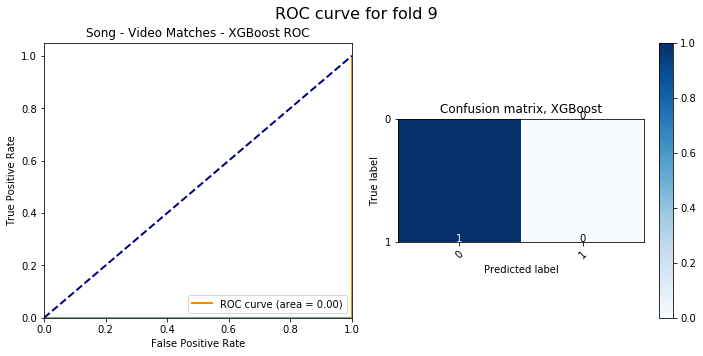

<Figure size 432x288 with 0 Axes>

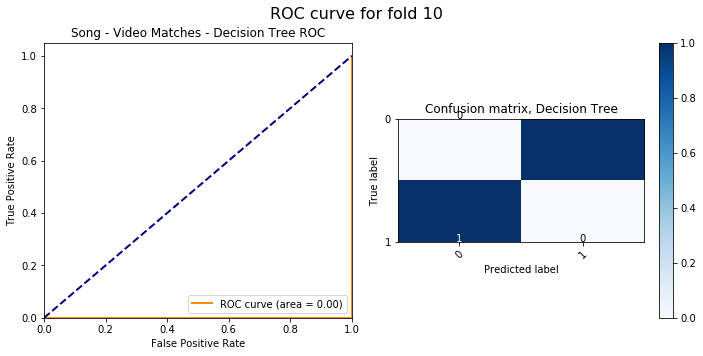

<Figure size 432x288 with 0 Axes>

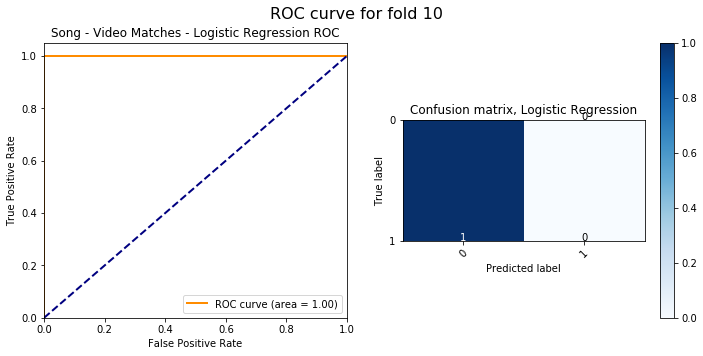

<Figure size 432x288 with 0 Axes>

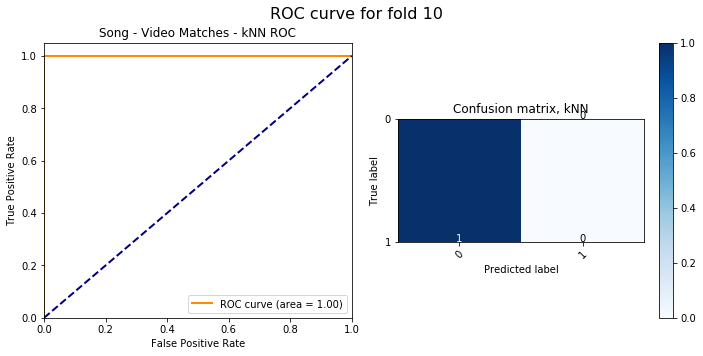

<Figure size 432x288 with 0 Axes>

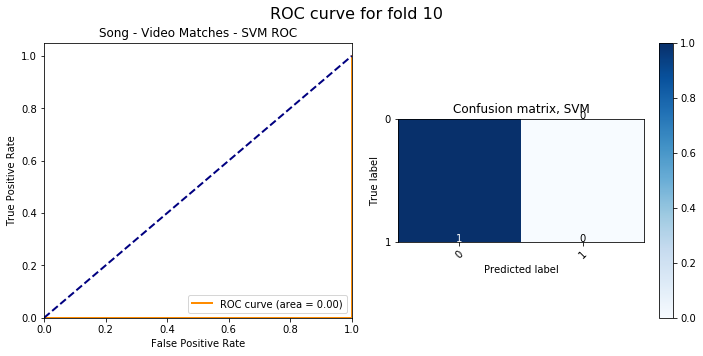

<Figure size 432x288 with 0 Axes>

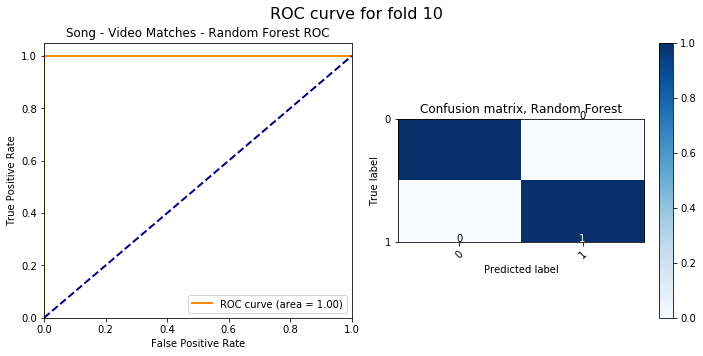

<Figure size 432x288 with 0 Axes>

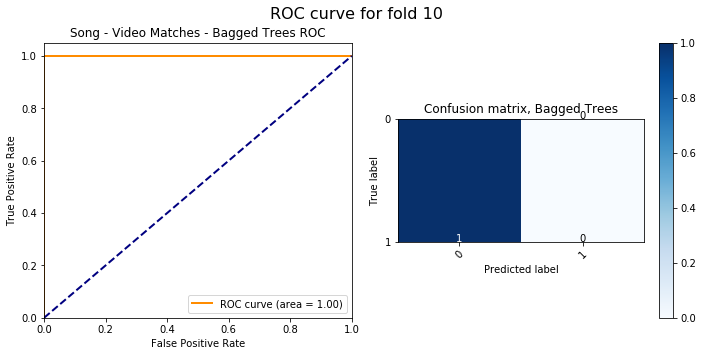

<Figure size 432x288 with 0 Axes>

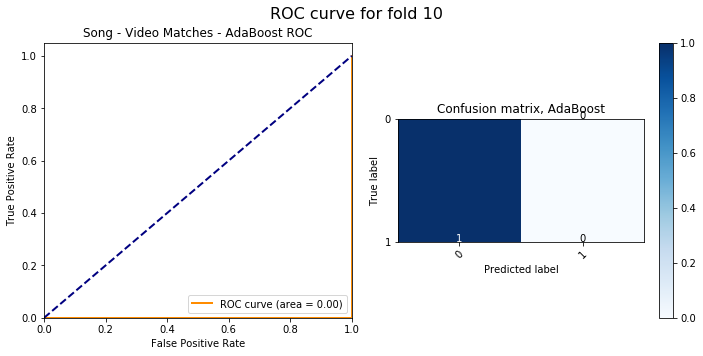

<Figure size 432x288 with 0 Axes>

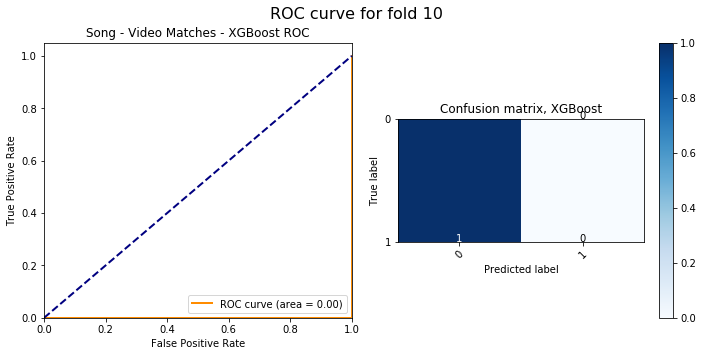

<Figure size 432x288 with 0 Axes>

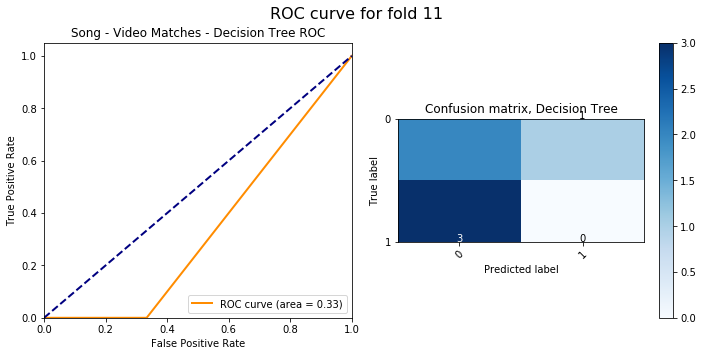

<Figure size 432x288 with 0 Axes>

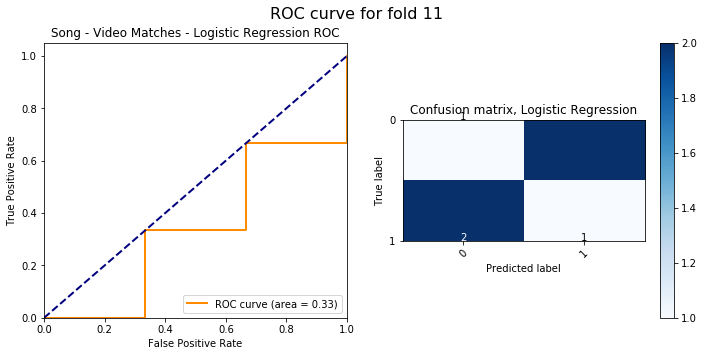

<Figure size 432x288 with 0 Axes>

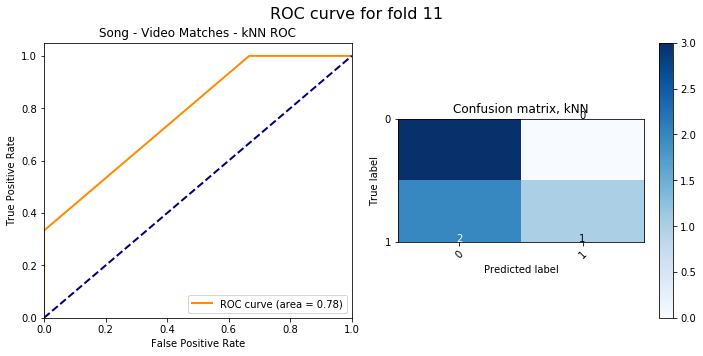

<Figure size 432x288 with 0 Axes>

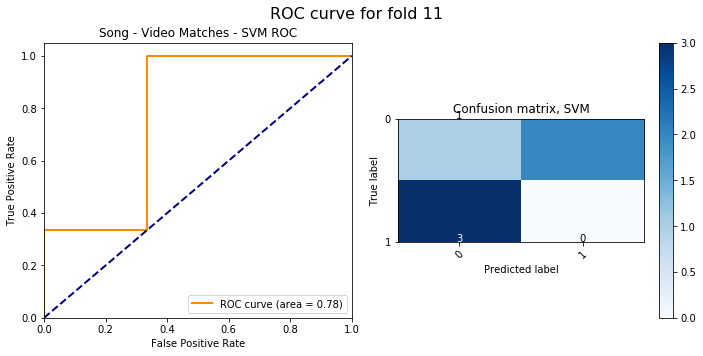

<Figure size 432x288 with 0 Axes>

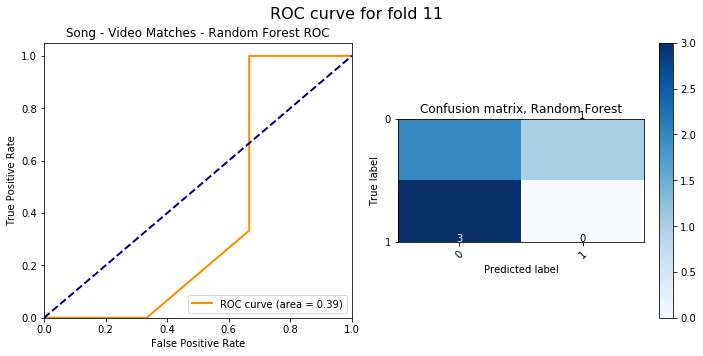

<Figure size 432x288 with 0 Axes>

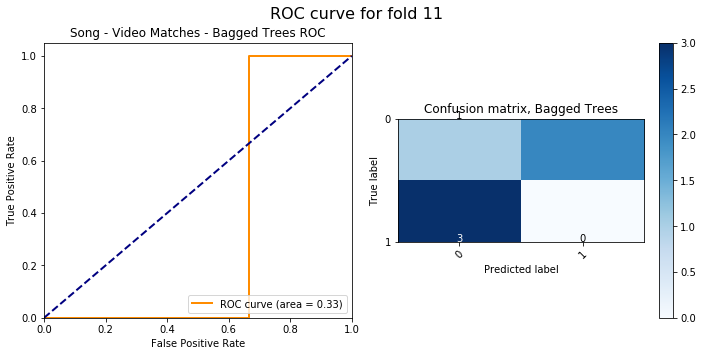

<Figure size 432x288 with 0 Axes>

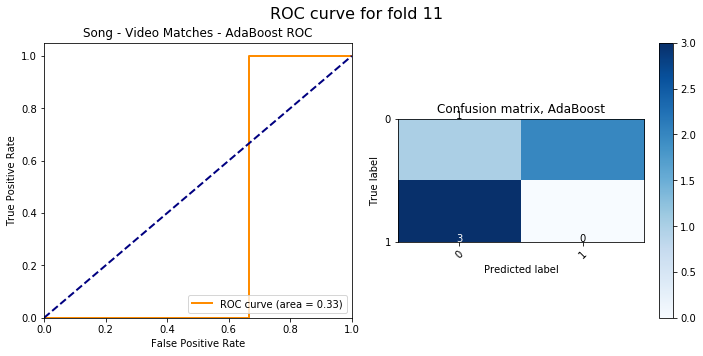

<Figure size 432x288 with 0 Axes>

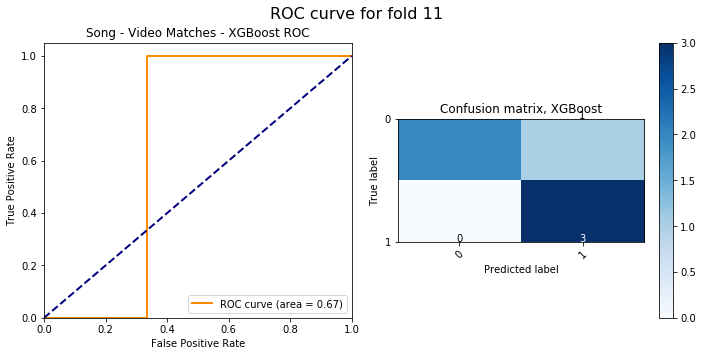

<Figure size 432x288 with 0 Axes>

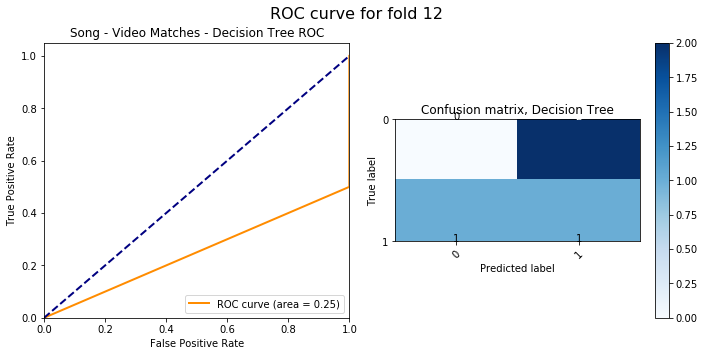

<Figure size 432x288 with 0 Axes>

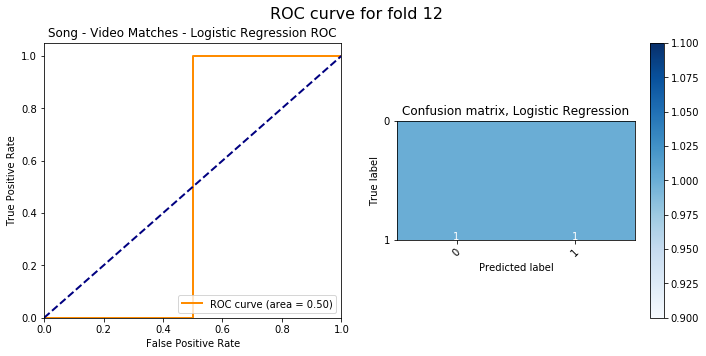

<Figure size 432x288 with 0 Axes>

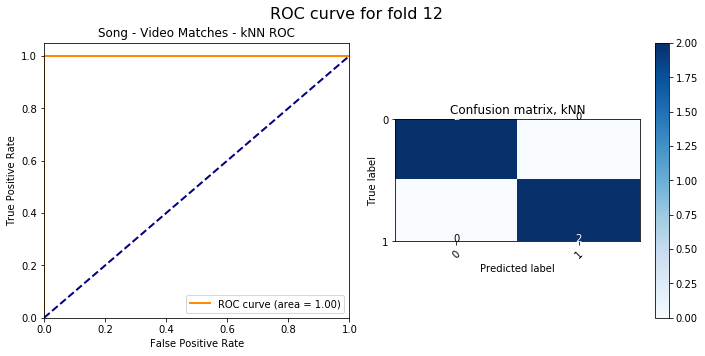

<Figure size 432x288 with 0 Axes>

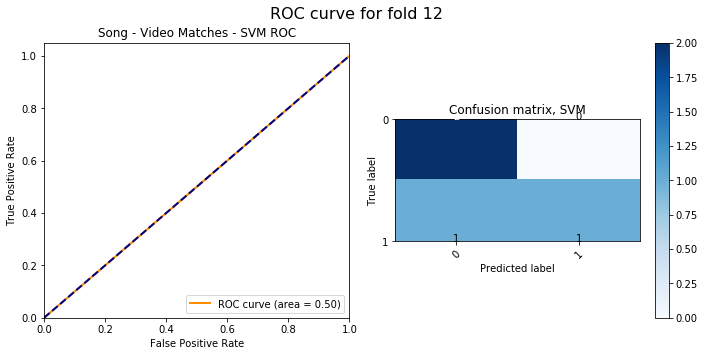

<Figure size 432x288 with 0 Axes>

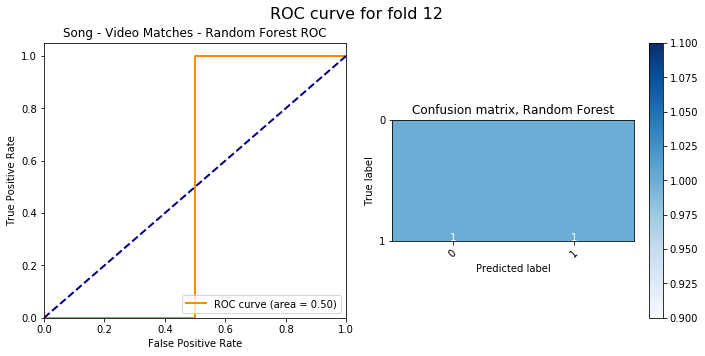

<Figure size 432x288 with 0 Axes>

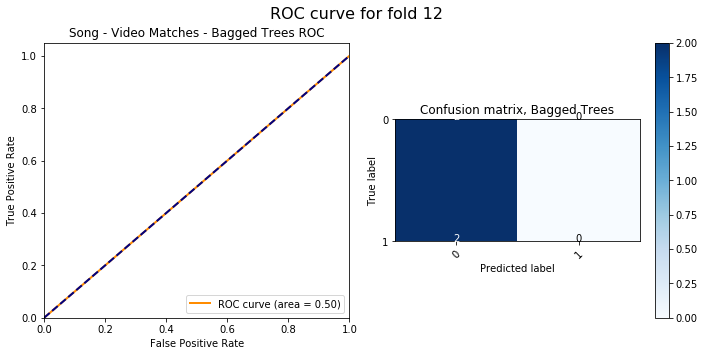

<Figure size 432x288 with 0 Axes>

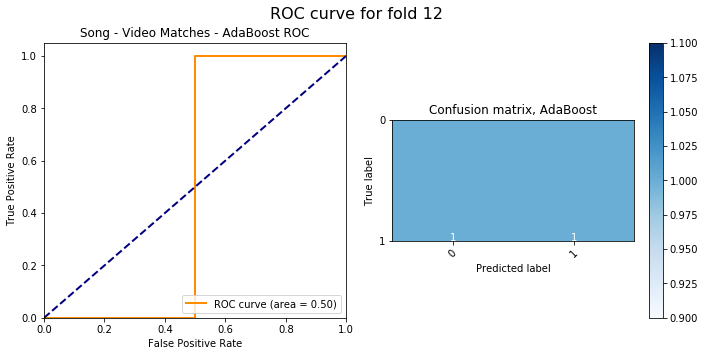

<Figure size 432x288 with 0 Axes>

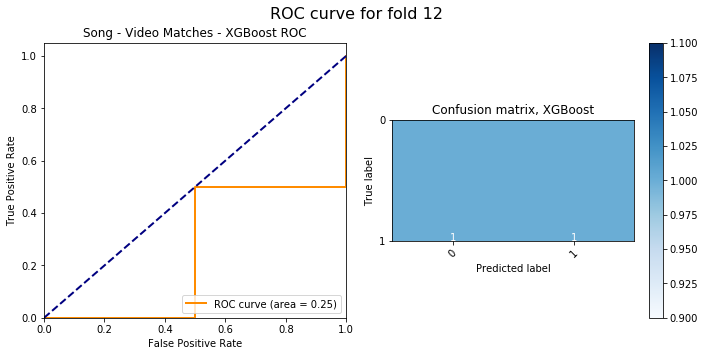

<Figure size 432x288 with 0 Axes>

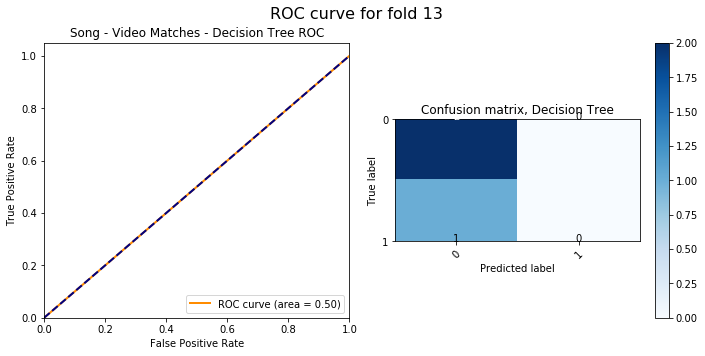

<Figure size 432x288 with 0 Axes>

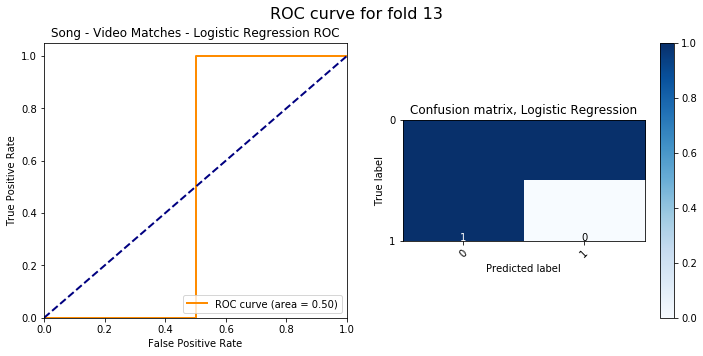

<Figure size 432x288 with 0 Axes>

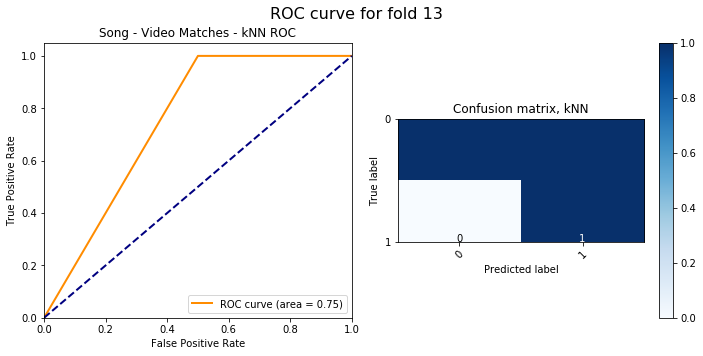

<Figure size 432x288 with 0 Axes>

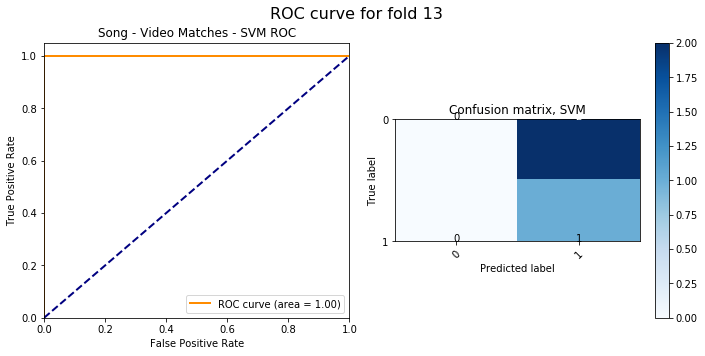

<Figure size 432x288 with 0 Axes>

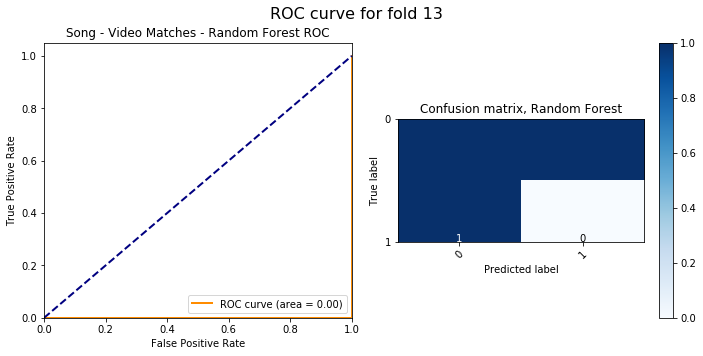

<Figure size 432x288 with 0 Axes>

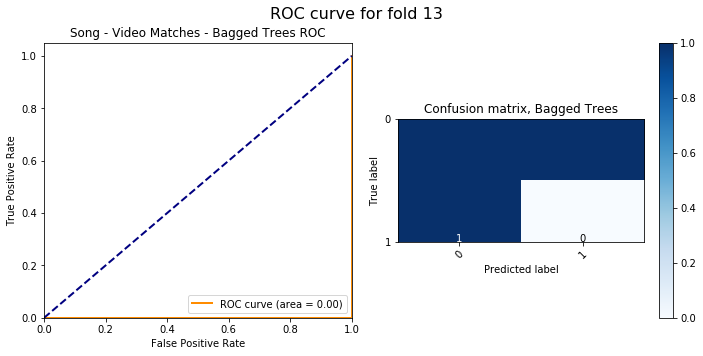

<Figure size 432x288 with 0 Axes>

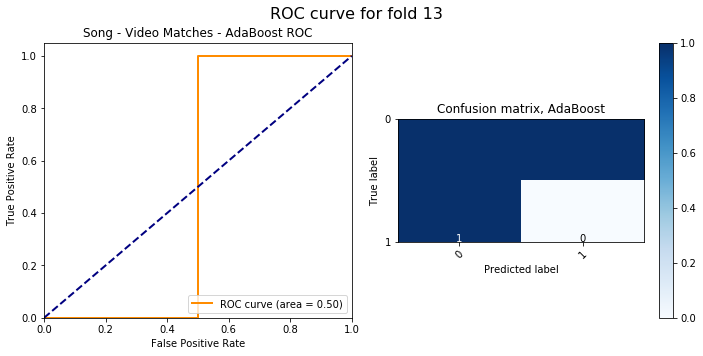

<Figure size 432x288 with 0 Axes>

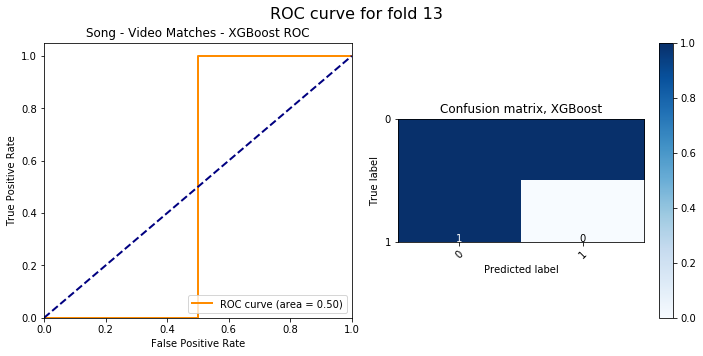

<Figure size 432x288 with 0 Axes>

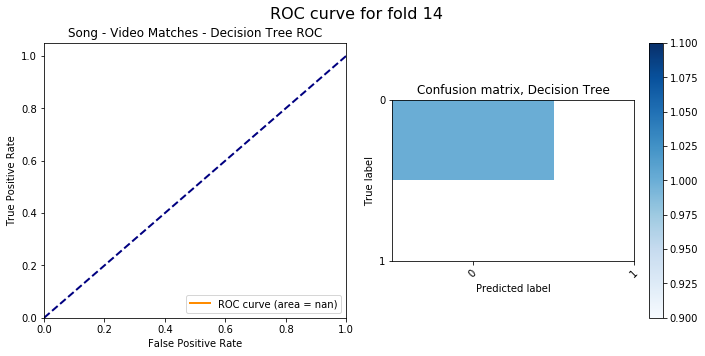

<Figure size 432x288 with 0 Axes>

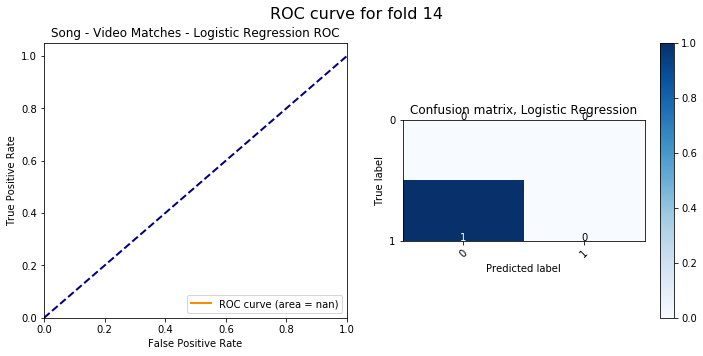

<Figure size 432x288 with 0 Axes>

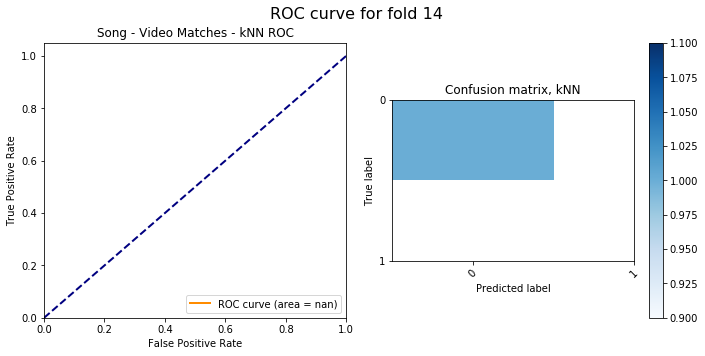

<Figure size 432x288 with 0 Axes>

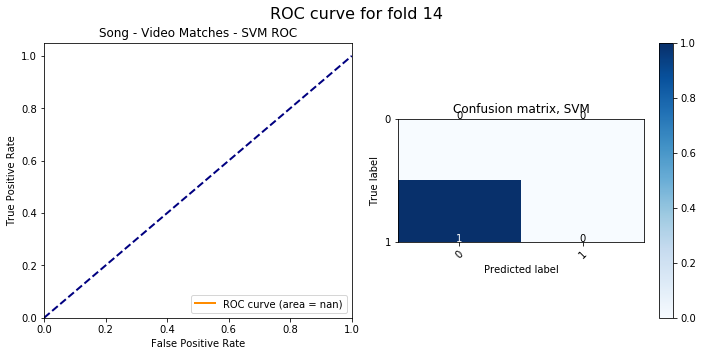

<Figure size 432x288 with 0 Axes>

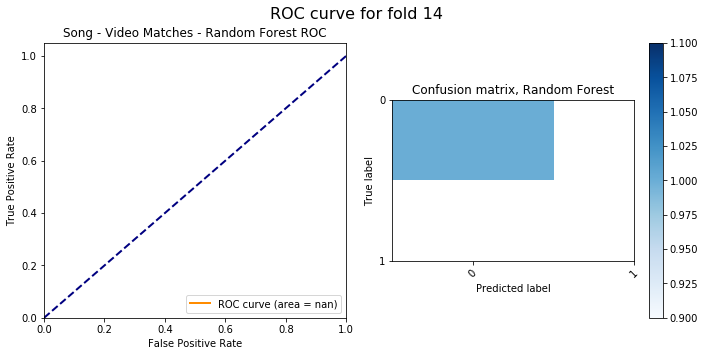

<Figure size 432x288 with 0 Axes>

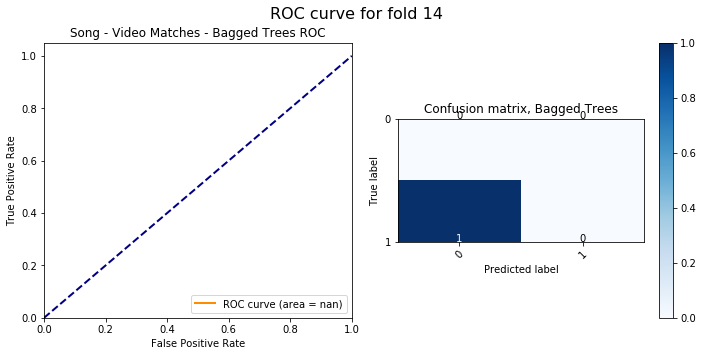

<Figure size 432x288 with 0 Axes>

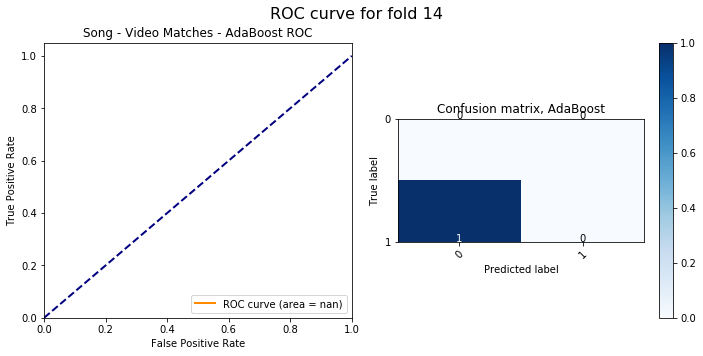

<Figure size 432x288 with 0 Axes>

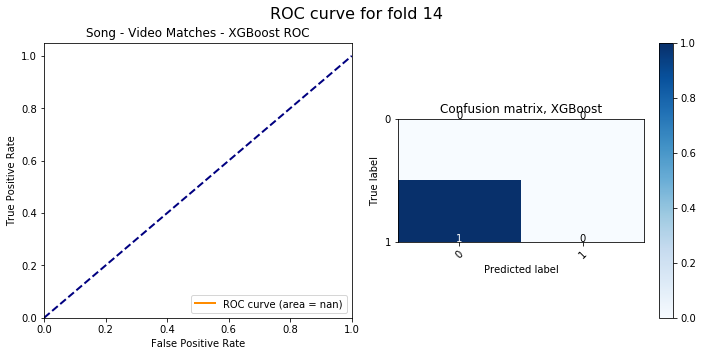

<Figure size 432x288 with 0 Axes>

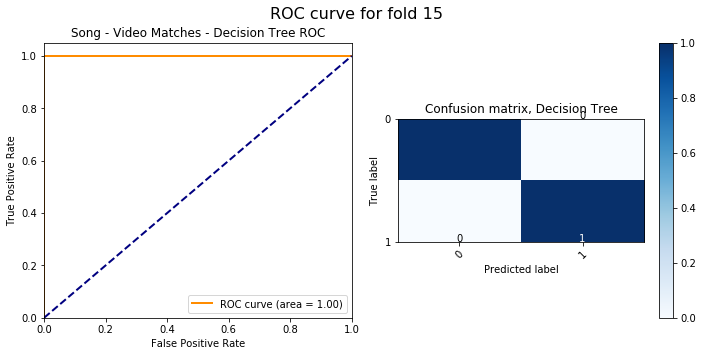

<Figure size 432x288 with 0 Axes>

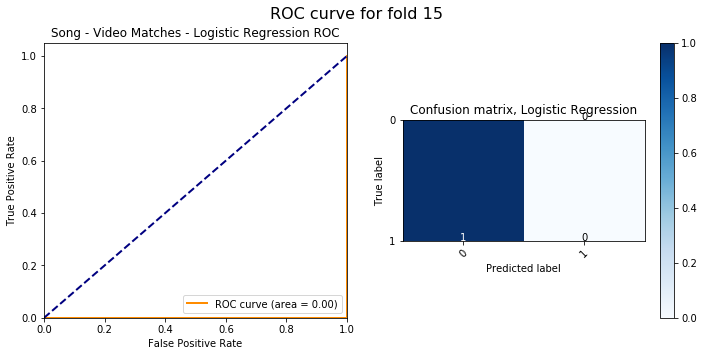

<Figure size 432x288 with 0 Axes>

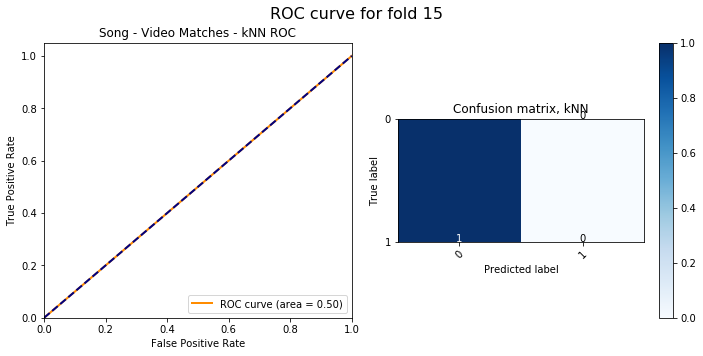

<Figure size 432x288 with 0 Axes>

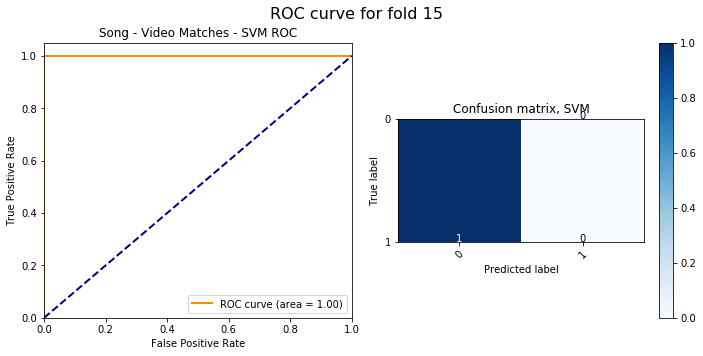

<Figure size 432x288 with 0 Axes>

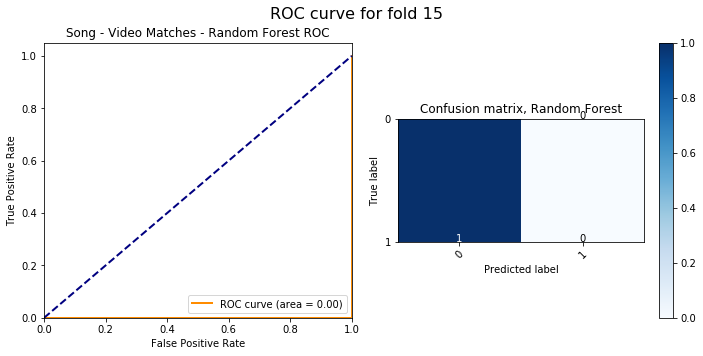

<Figure size 432x288 with 0 Axes>

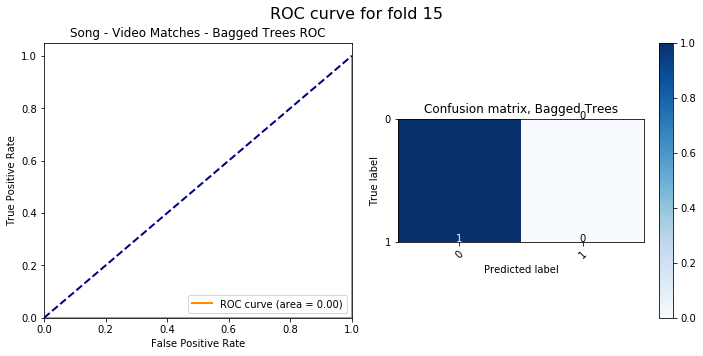

<Figure size 432x288 with 0 Axes>

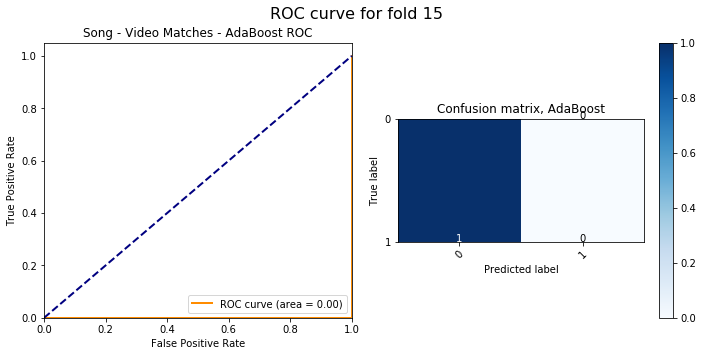

<Figure size 432x288 with 0 Axes>

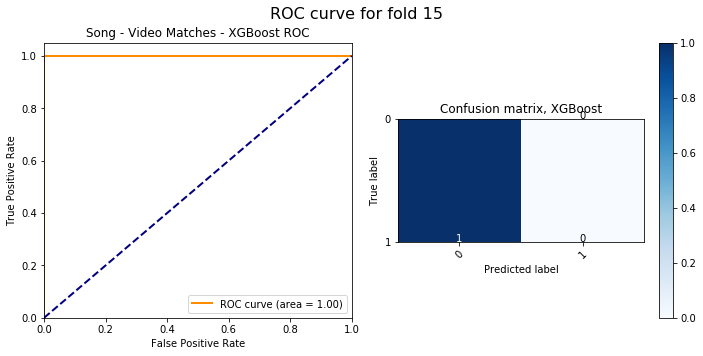

<Figure size 432x288 with 0 Axes>

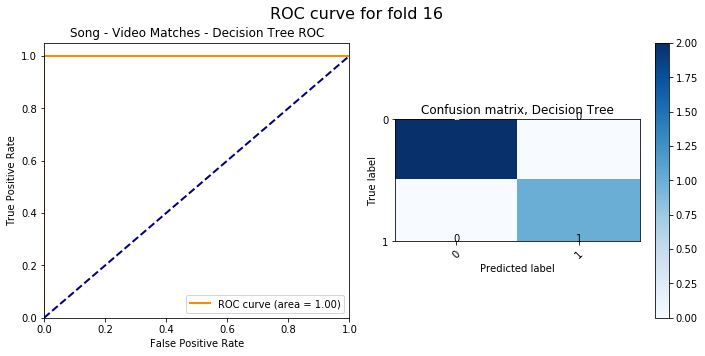

<Figure size 432x288 with 0 Axes>

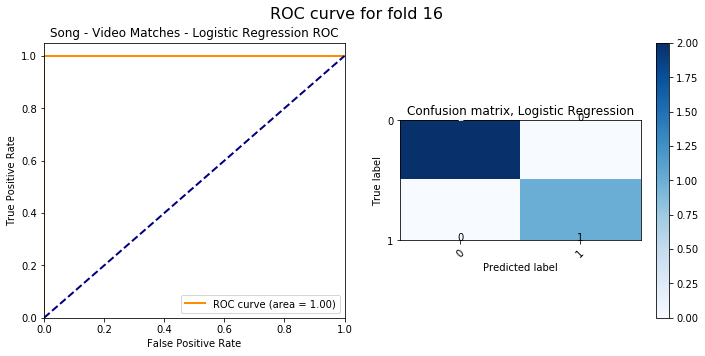

<Figure size 432x288 with 0 Axes>

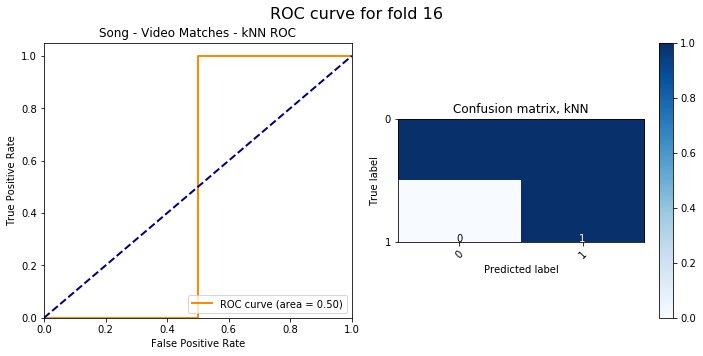

<Figure size 432x288 with 0 Axes>

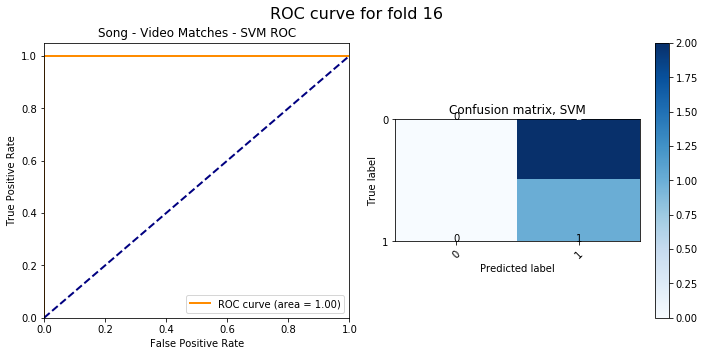

<Figure size 432x288 with 0 Axes>

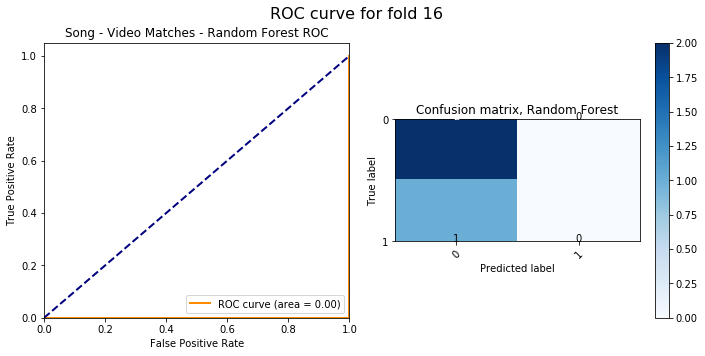

<Figure size 432x288 with 0 Axes>

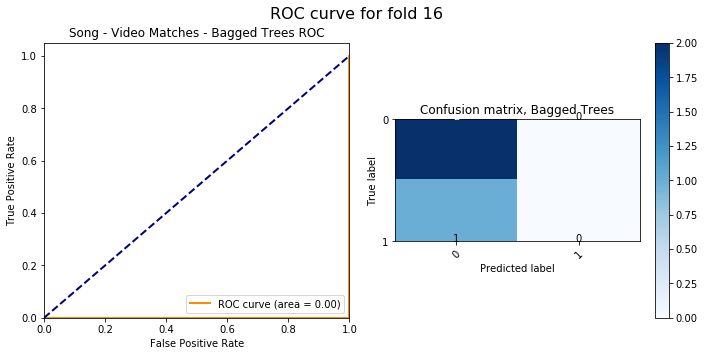

<Figure size 432x288 with 0 Axes>

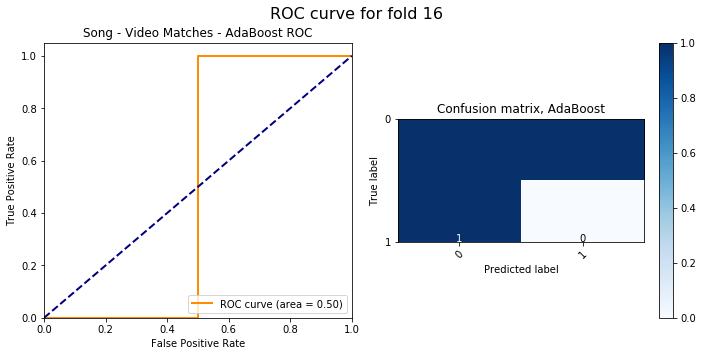

<Figure size 432x288 with 0 Axes>

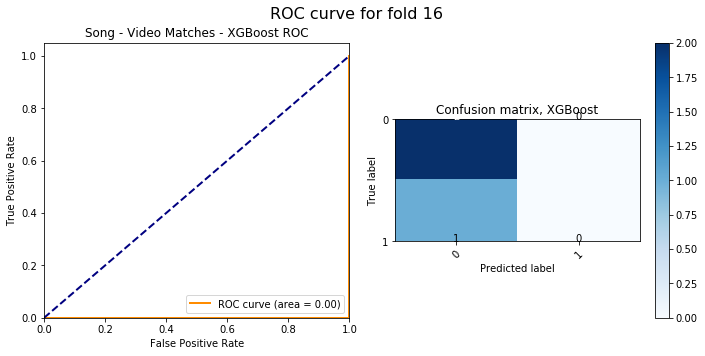

<Figure size 432x288 with 0 Axes>

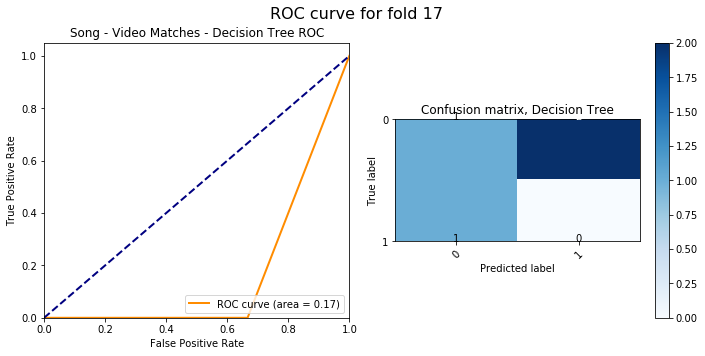

<Figure size 432x288 with 0 Axes>

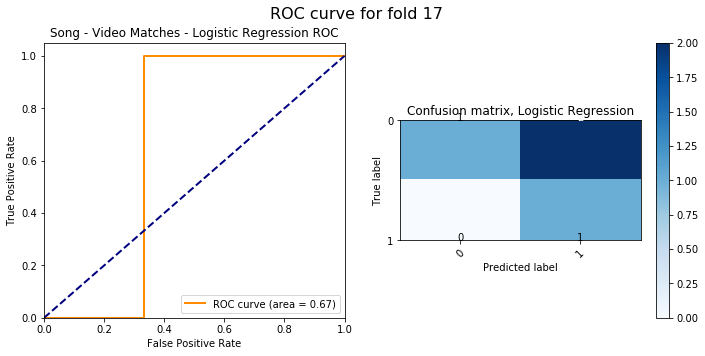

<Figure size 432x288 with 0 Axes>

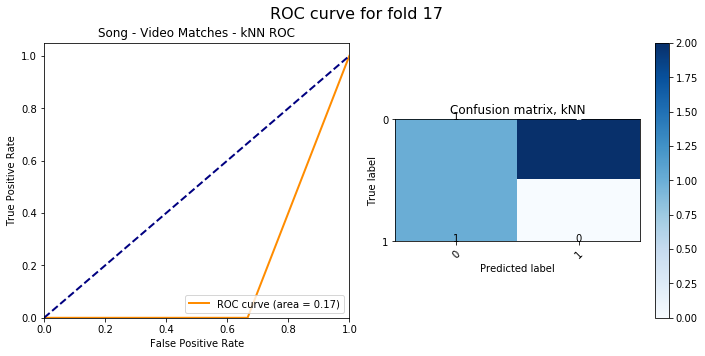

<Figure size 432x288 with 0 Axes>

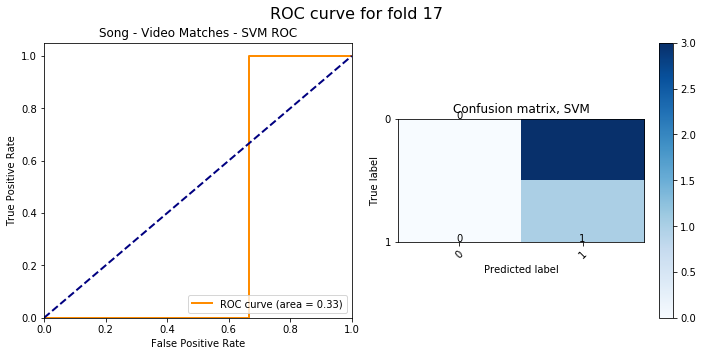

<Figure size 432x288 with 0 Axes>

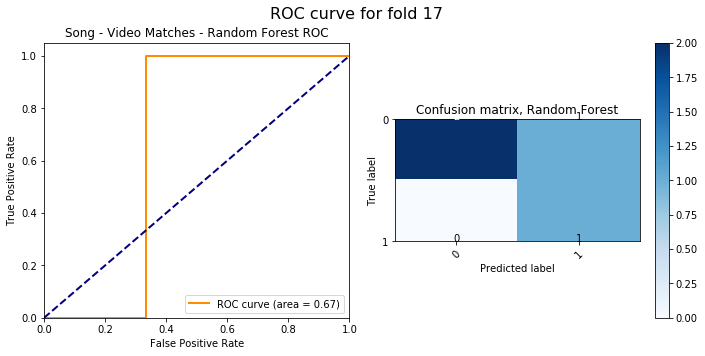

<Figure size 432x288 with 0 Axes>

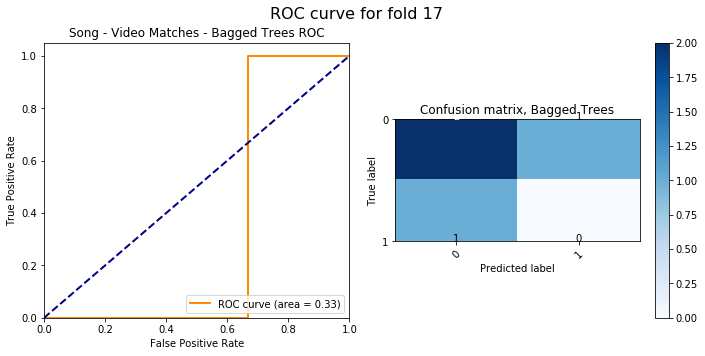

<Figure size 432x288 with 0 Axes>

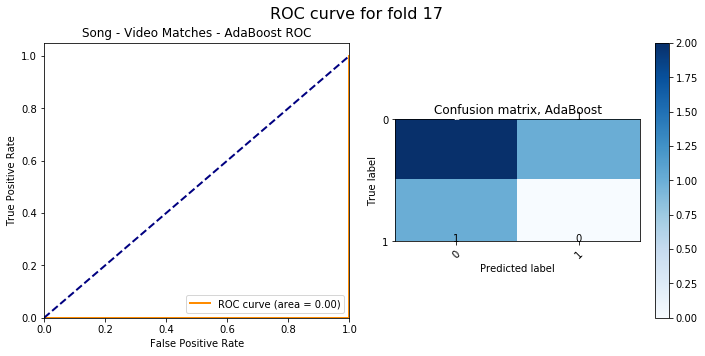

<Figure size 432x288 with 0 Axes>

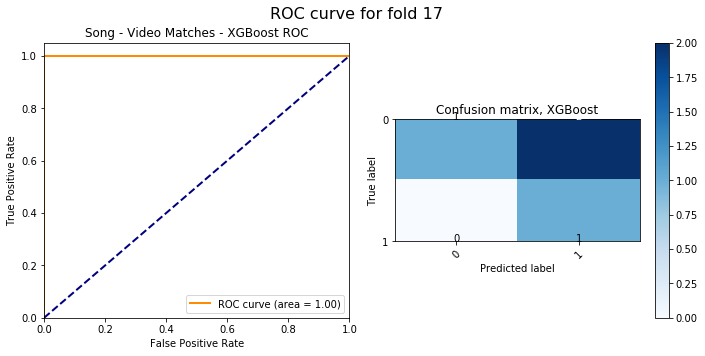

<Figure size 432x288 with 0 Axes>

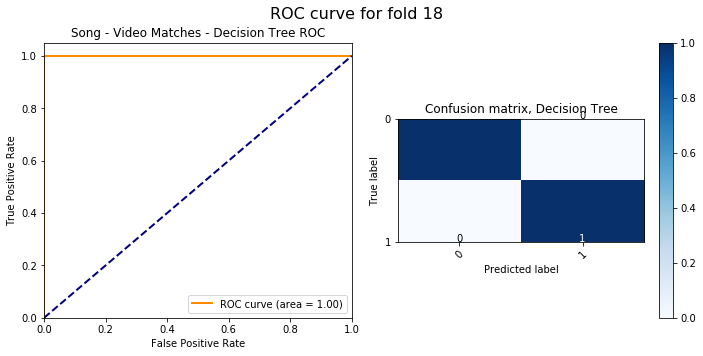

<Figure size 432x288 with 0 Axes>

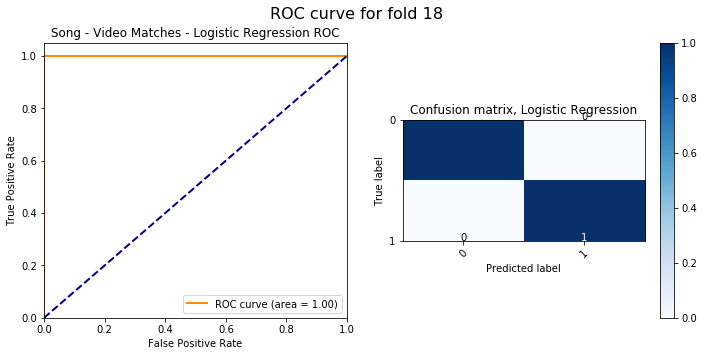

<Figure size 432x288 with 0 Axes>

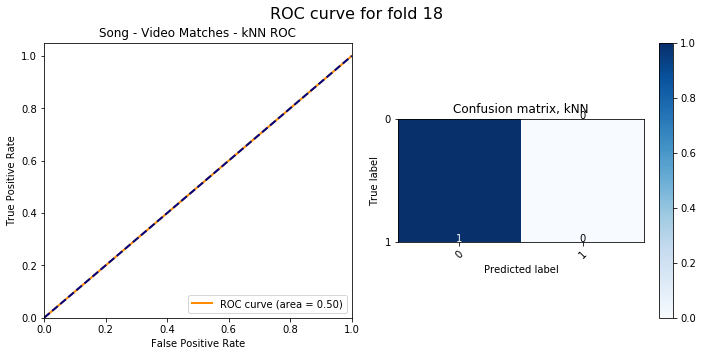

<Figure size 432x288 with 0 Axes>

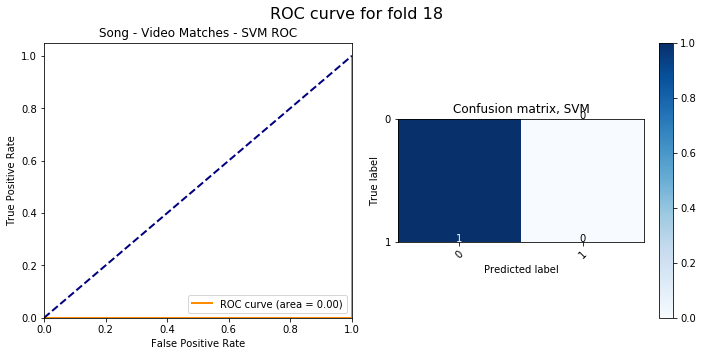

<Figure size 432x288 with 0 Axes>

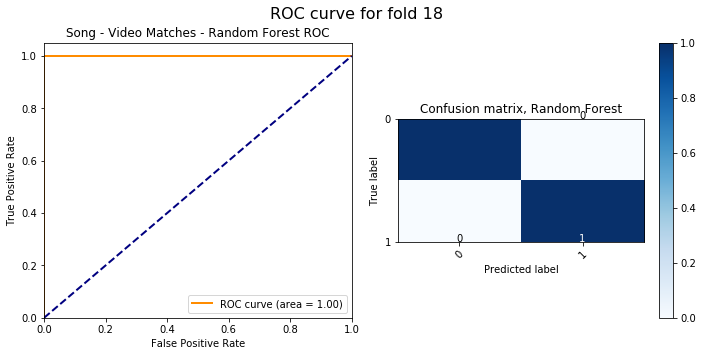

<Figure size 432x288 with 0 Axes>

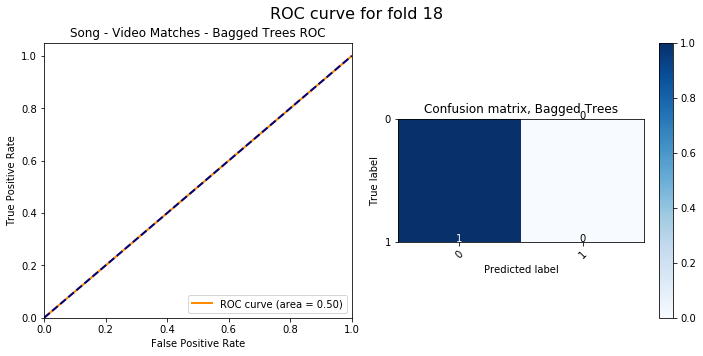

<Figure size 432x288 with 0 Axes>

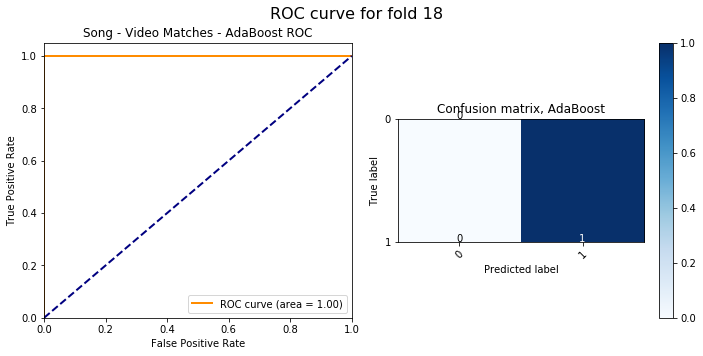

<Figure size 432x288 with 0 Axes>

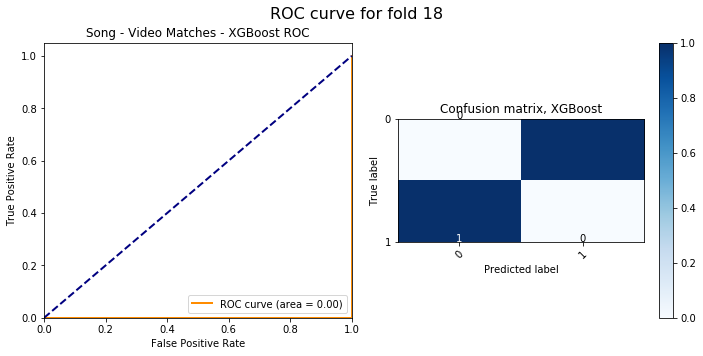

<Figure size 432x288 with 0 Axes>

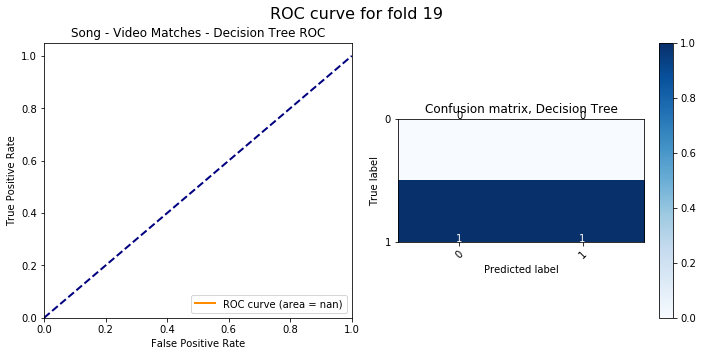

<Figure size 432x288 with 0 Axes>

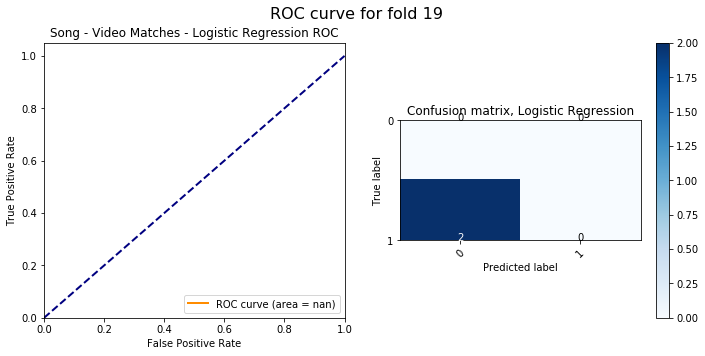

<Figure size 432x288 with 0 Axes>

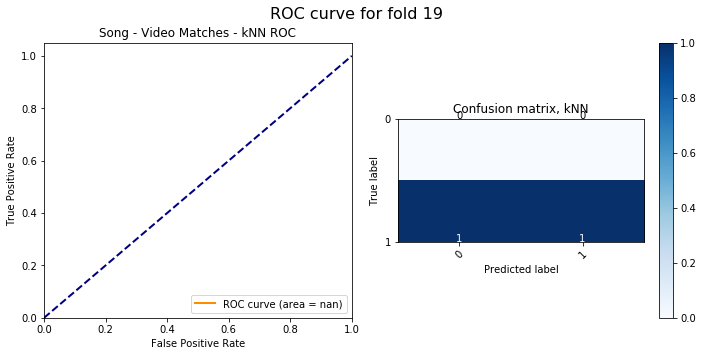

<Figure size 432x288 with 0 Axes>

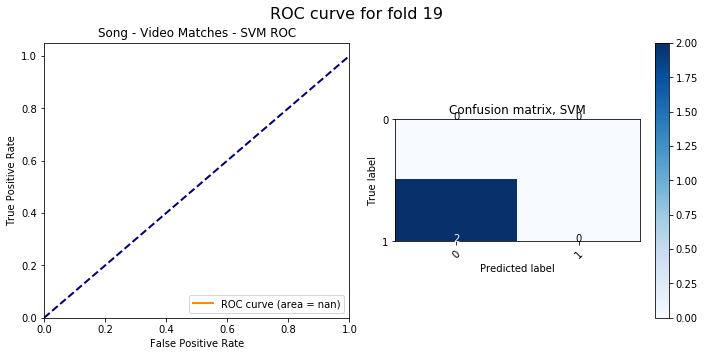

<Figure size 432x288 with 0 Axes>

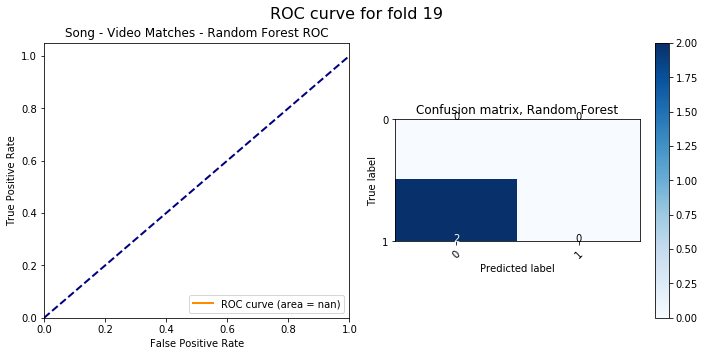

<Figure size 432x288 with 0 Axes>

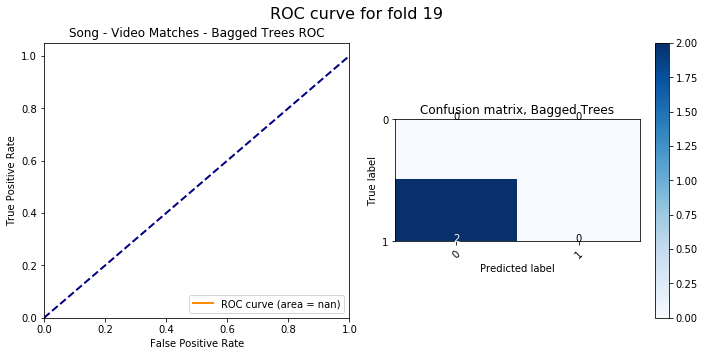

<Figure size 432x288 with 0 Axes>

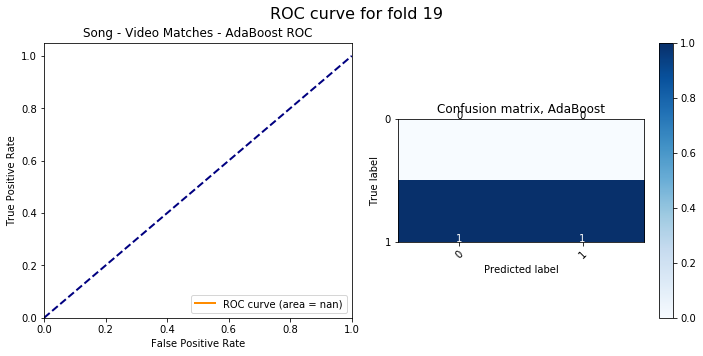

<Figure size 432x288 with 0 Axes>

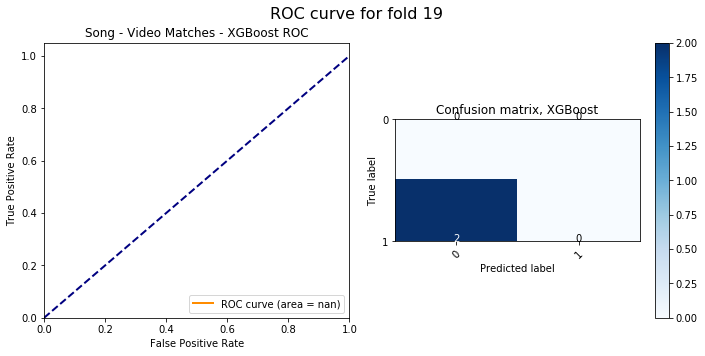

<Figure size 432x288 with 0 Axes>

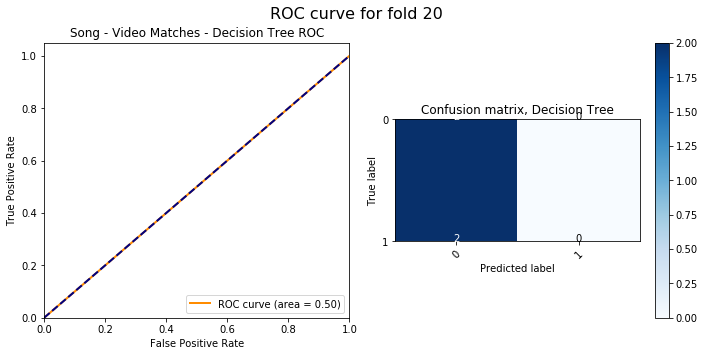

<Figure size 432x288 with 0 Axes>

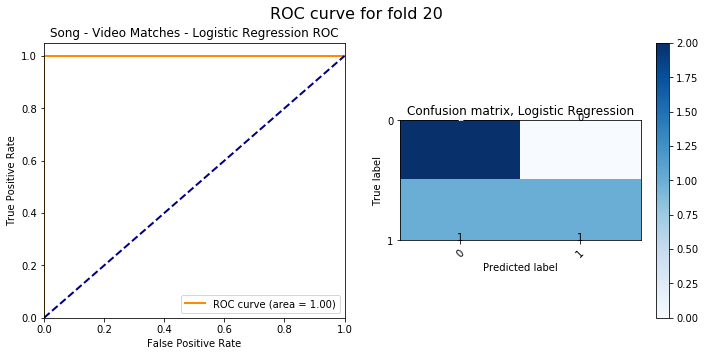

<Figure size 432x288 with 0 Axes>

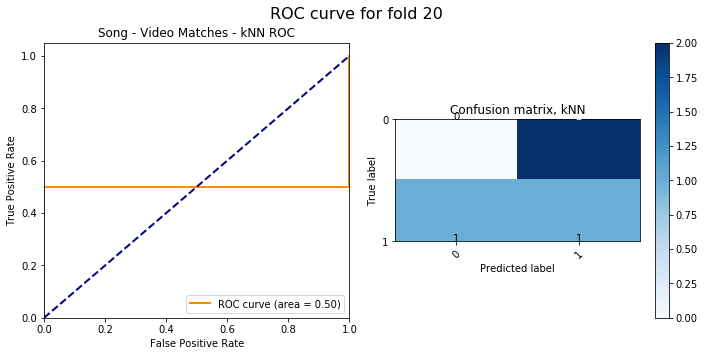

<Figure size 432x288 with 0 Axes>

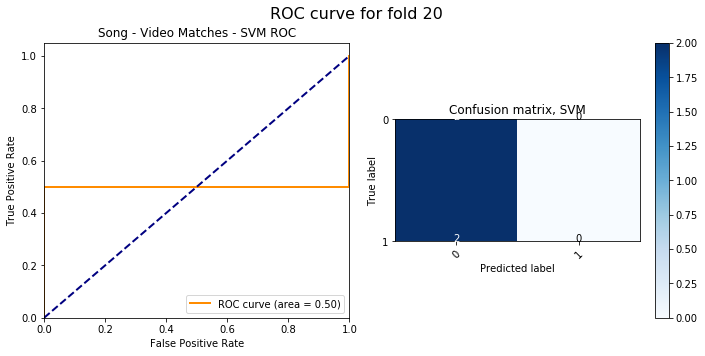

<Figure size 432x288 with 0 Axes>

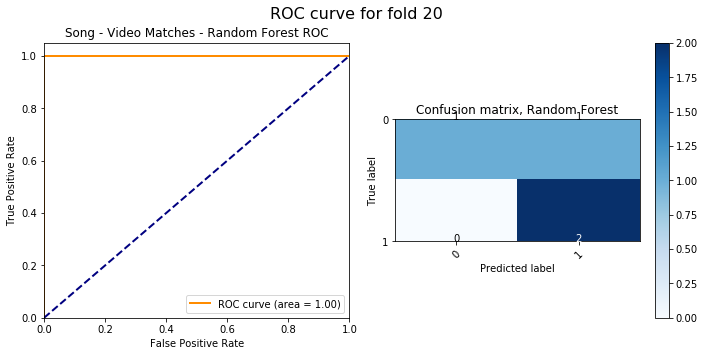

<Figure size 432x288 with 0 Axes>

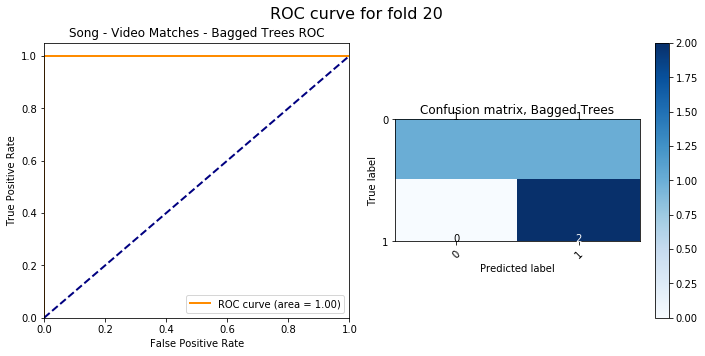

<Figure size 432x288 with 0 Axes>

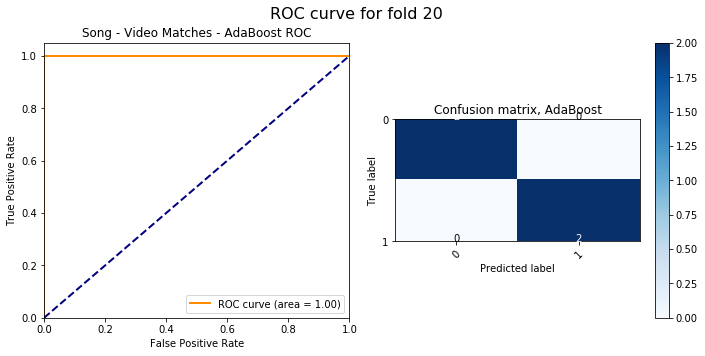

<Figure size 432x288 with 0 Axes>

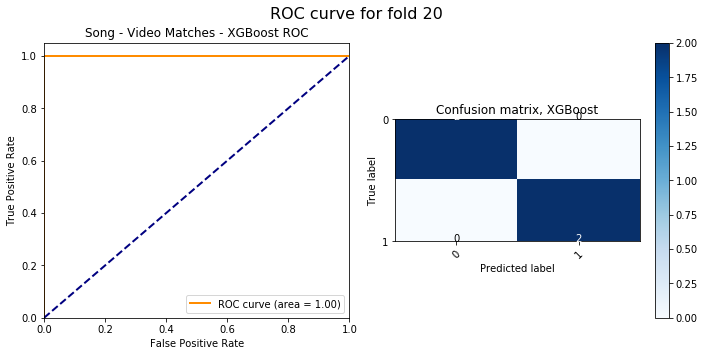

<Figure size 432x288 with 0 Axes>

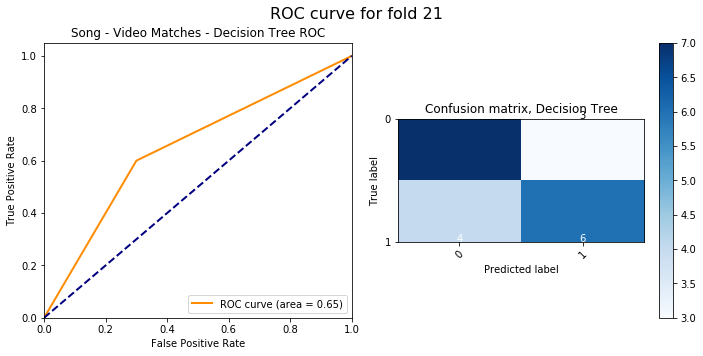

<Figure size 432x288 with 0 Axes>

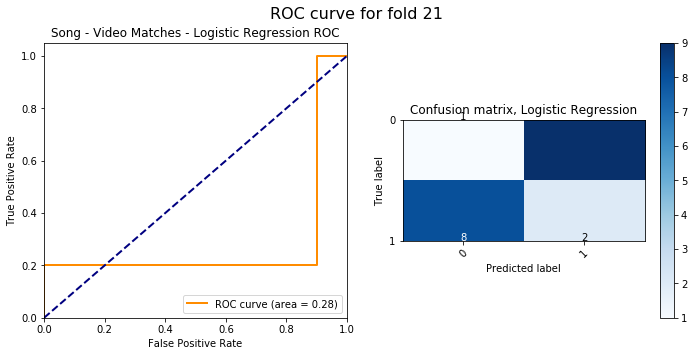

<Figure size 432x288 with 0 Axes>

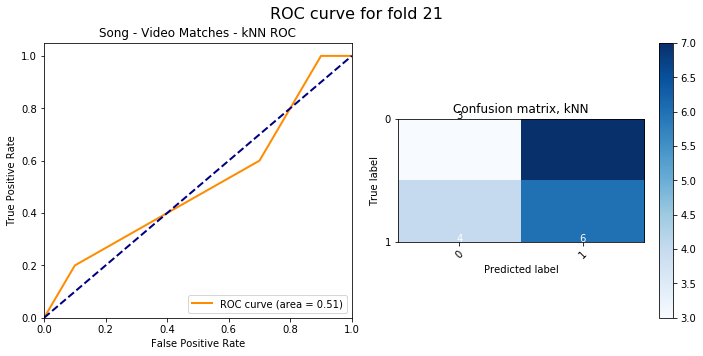

<Figure size 432x288 with 0 Axes>

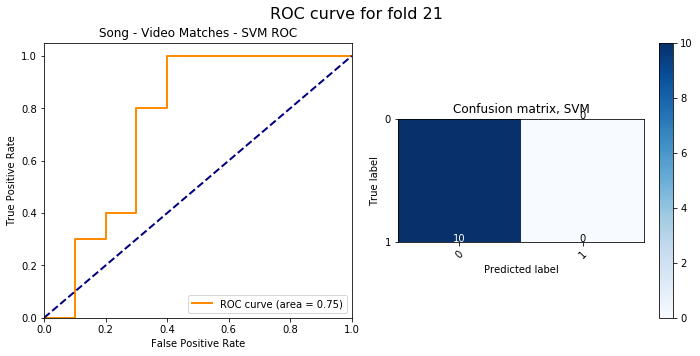

<Figure size 432x288 with 0 Axes>

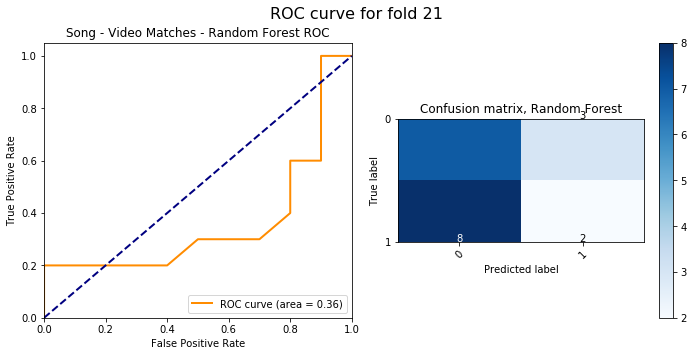

<Figure size 432x288 with 0 Axes>

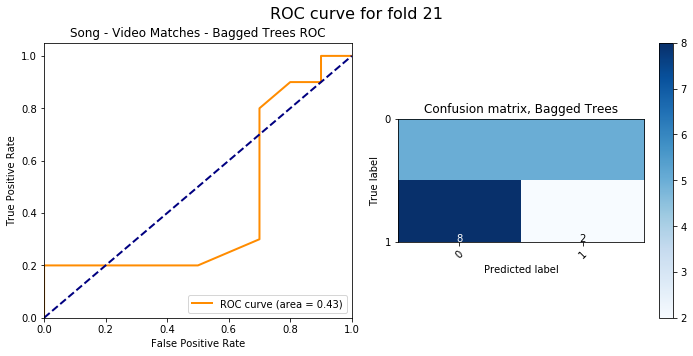

<Figure size 432x288 with 0 Axes>

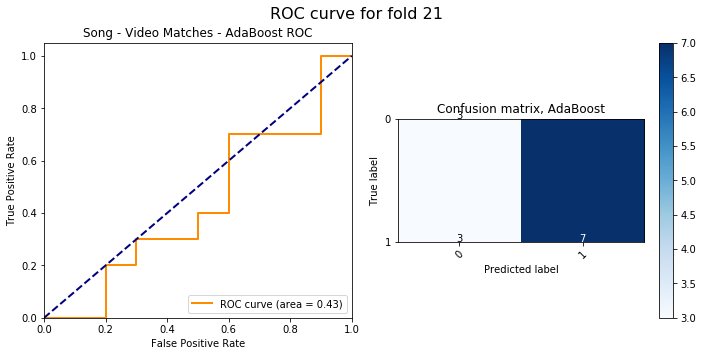

<Figure size 432x288 with 0 Axes>

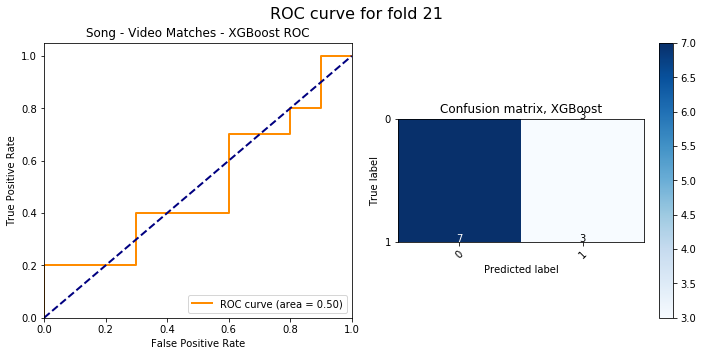

<Figure size 432x288 with 0 Axes>

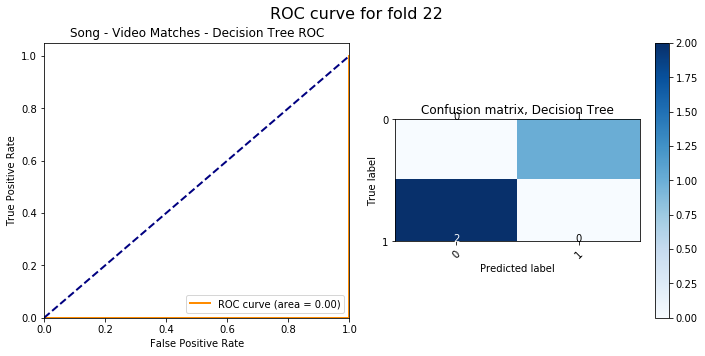

<Figure size 432x288 with 0 Axes>

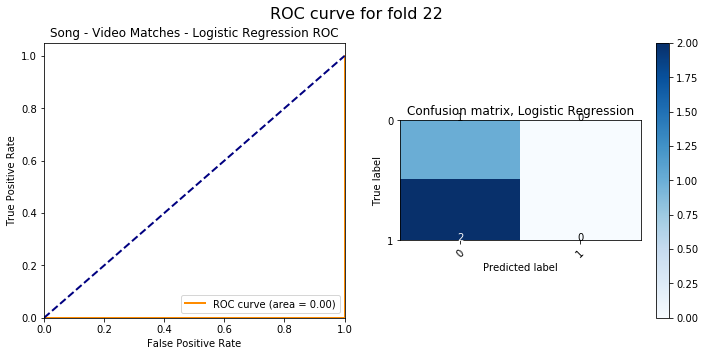

<Figure size 432x288 with 0 Axes>

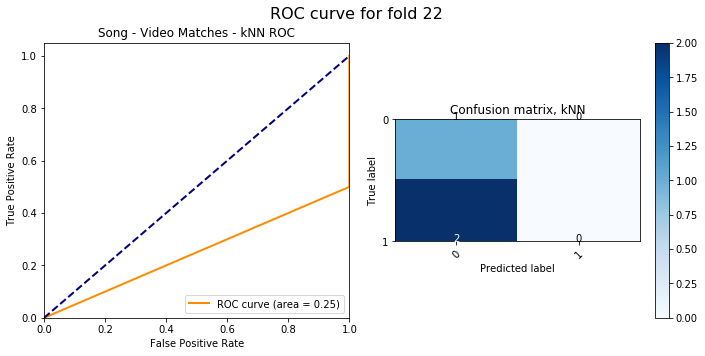

<Figure size 432x288 with 0 Axes>

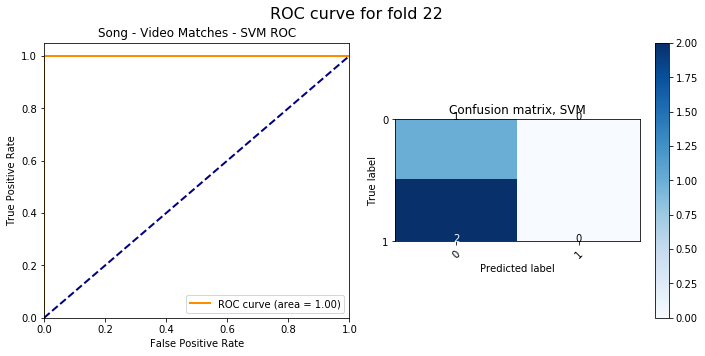

<Figure size 432x288 with 0 Axes>

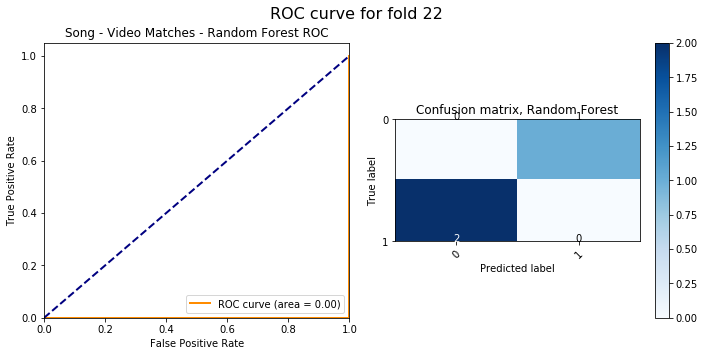

<Figure size 432x288 with 0 Axes>

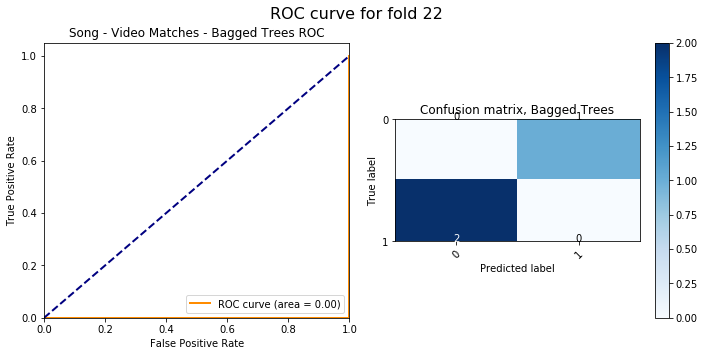

<Figure size 432x288 with 0 Axes>

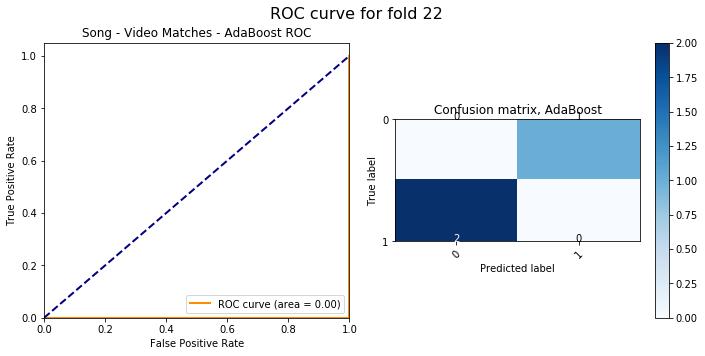

<Figure size 432x288 with 0 Axes>

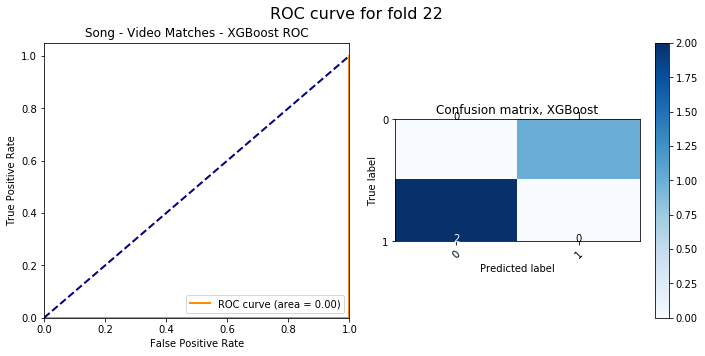

<Figure size 432x288 with 0 Axes>

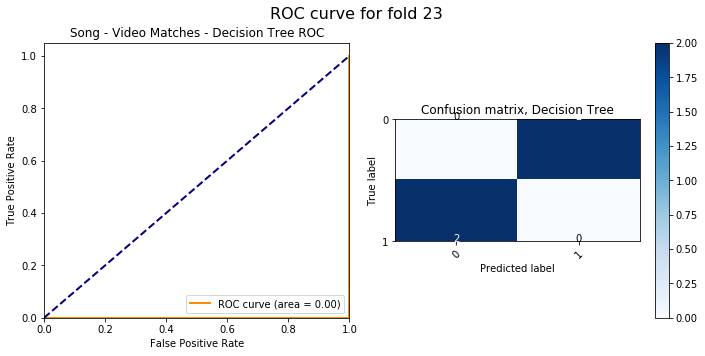

<Figure size 432x288 with 0 Axes>

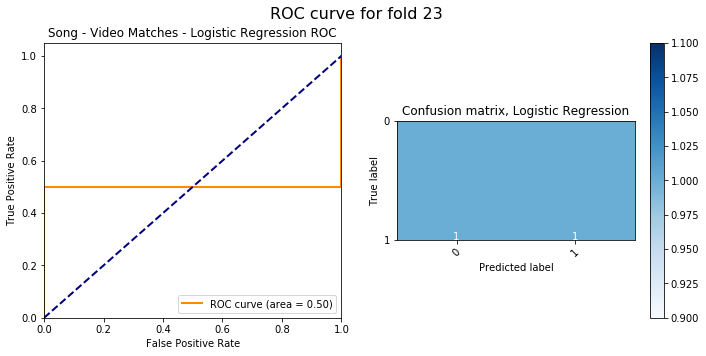

<Figure size 432x288 with 0 Axes>

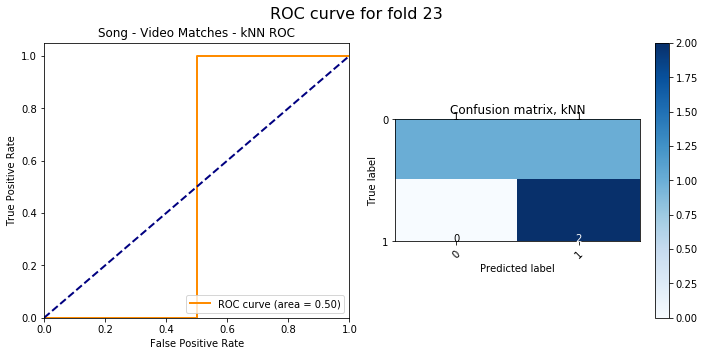

<Figure size 432x288 with 0 Axes>

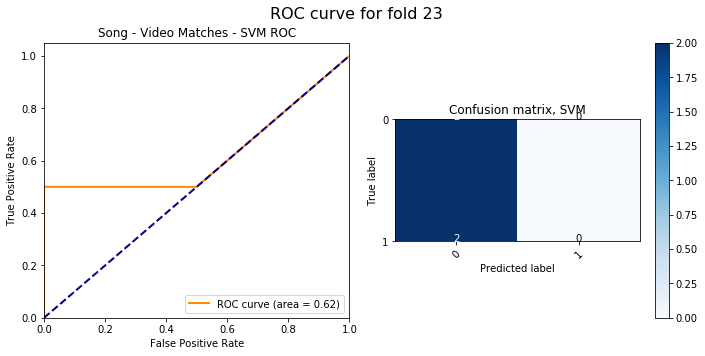

<Figure size 432x288 with 0 Axes>

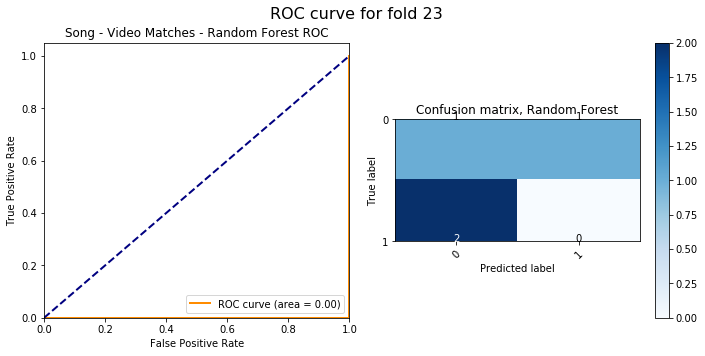

<Figure size 432x288 with 0 Axes>

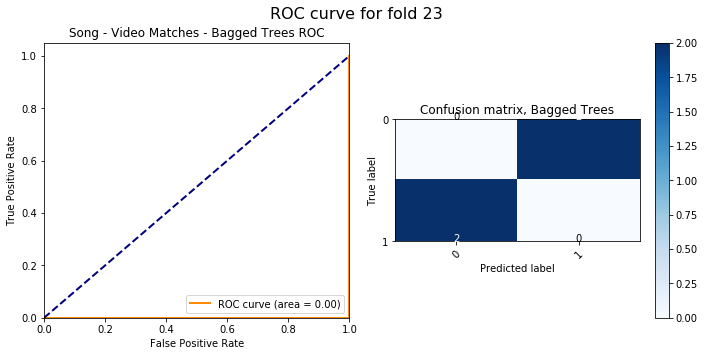

<Figure size 432x288 with 0 Axes>

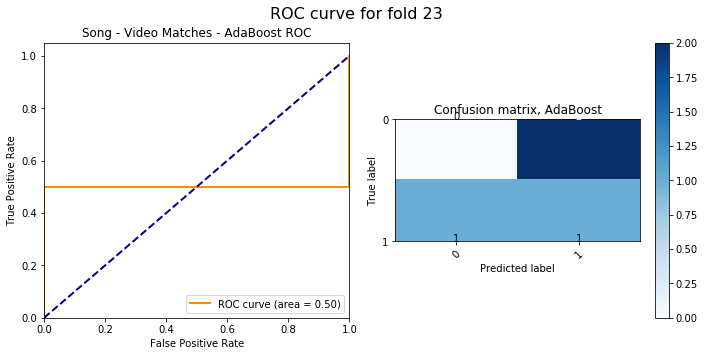

<Figure size 432x288 with 0 Axes>

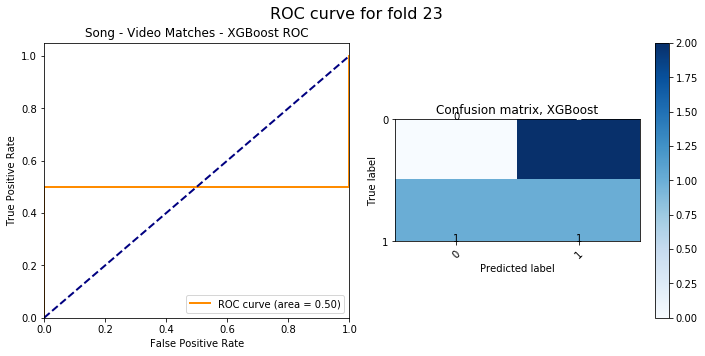

<Figure size 432x288 with 0 Axes>

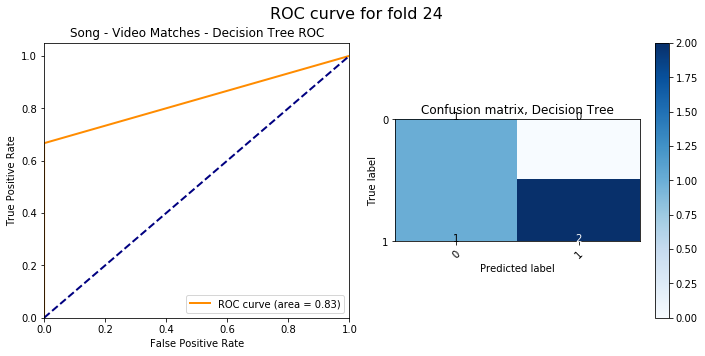

<Figure size 432x288 with 0 Axes>

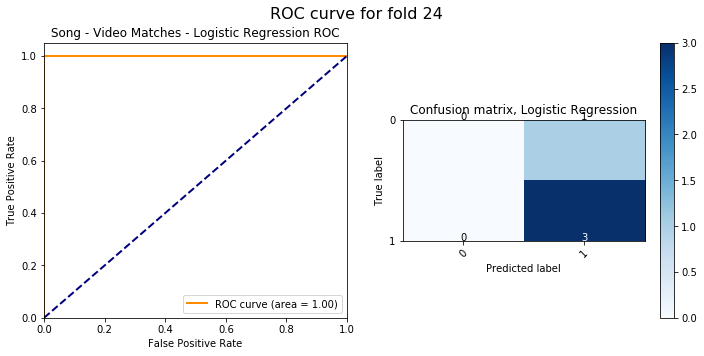

<Figure size 432x288 with 0 Axes>

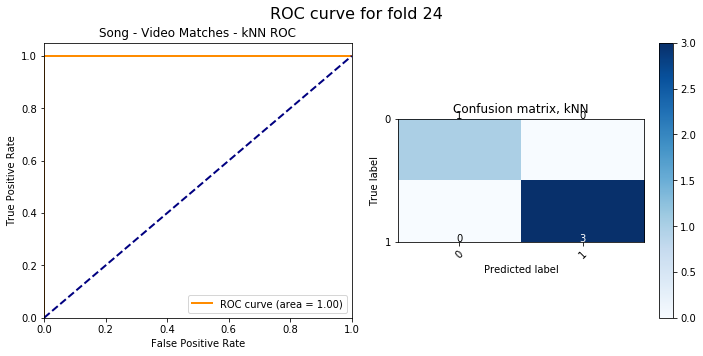

<Figure size 432x288 with 0 Axes>

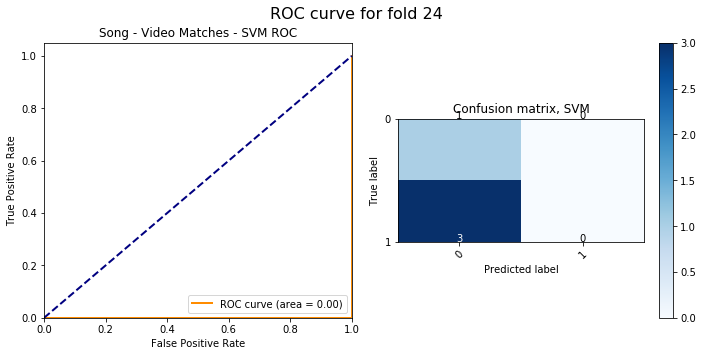

<Figure size 432x288 with 0 Axes>

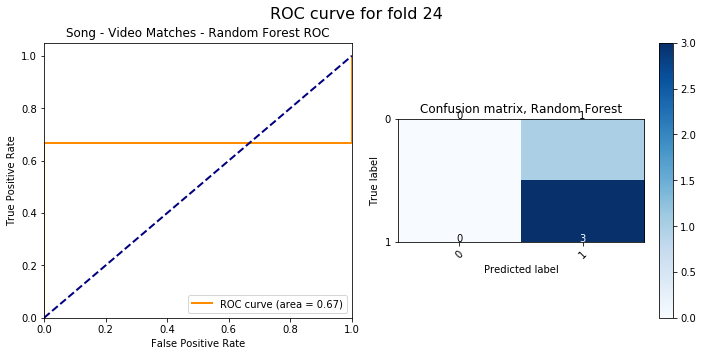

<Figure size 432x288 with 0 Axes>

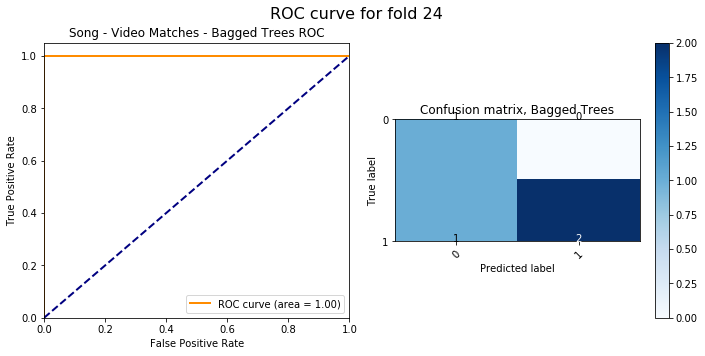

<Figure size 432x288 with 0 Axes>

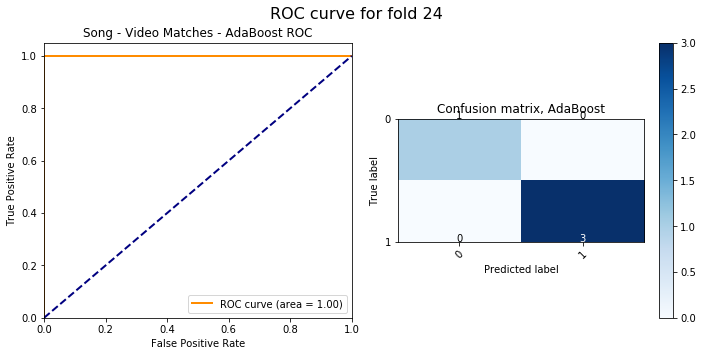

<Figure size 432x288 with 0 Axes>

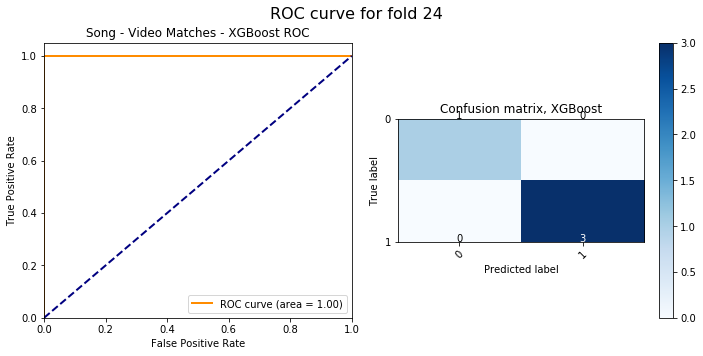

<Figure size 432x288 with 0 Axes>

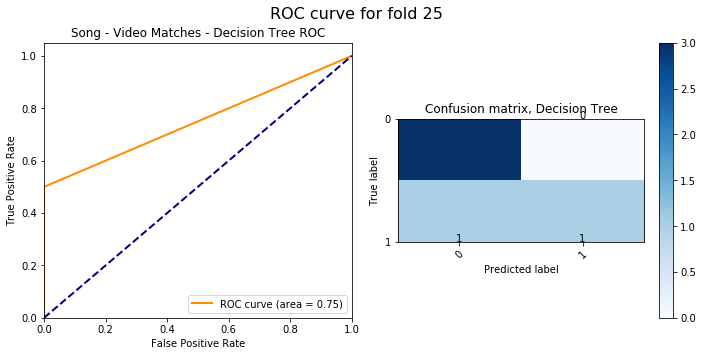

<Figure size 432x288 with 0 Axes>

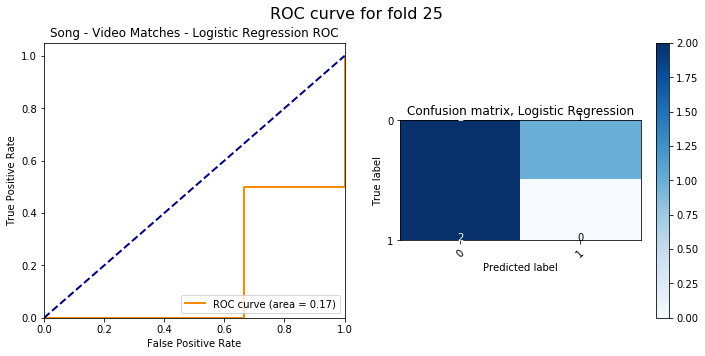

<Figure size 432x288 with 0 Axes>

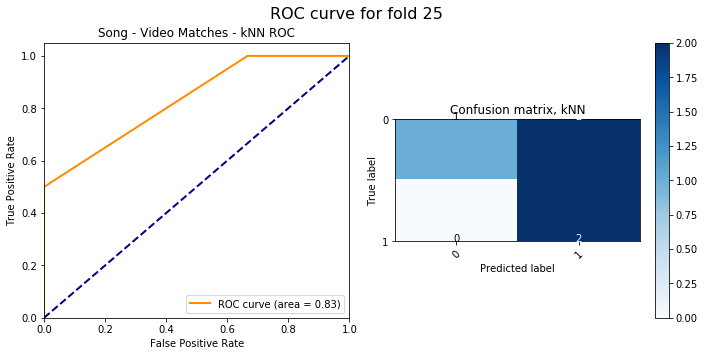

<Figure size 432x288 with 0 Axes>

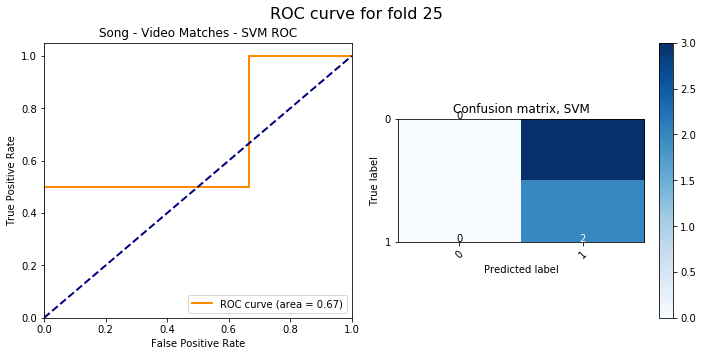

<Figure size 432x288 with 0 Axes>

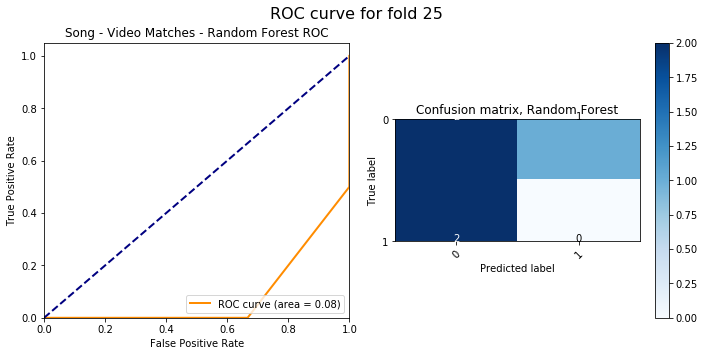

<Figure size 432x288 with 0 Axes>

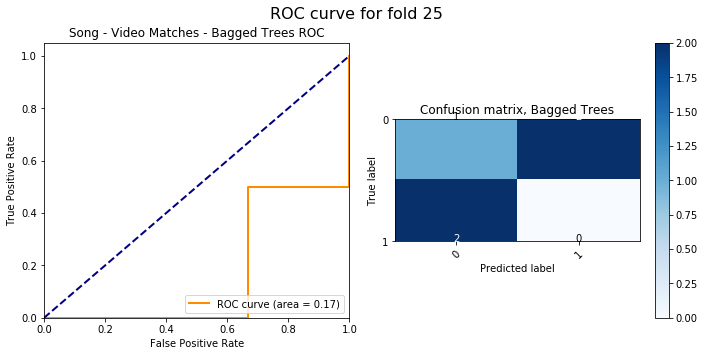

<Figure size 432x288 with 0 Axes>

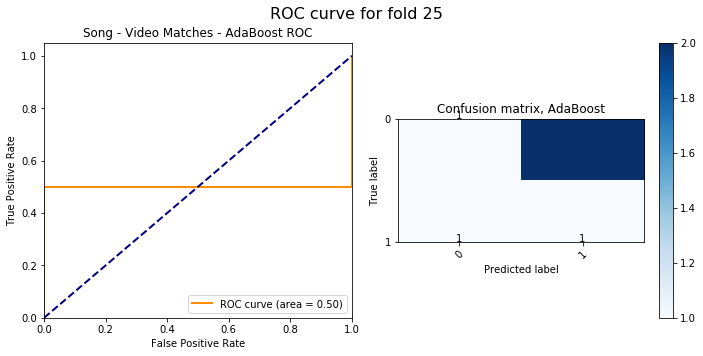

<Figure size 432x288 with 0 Axes>

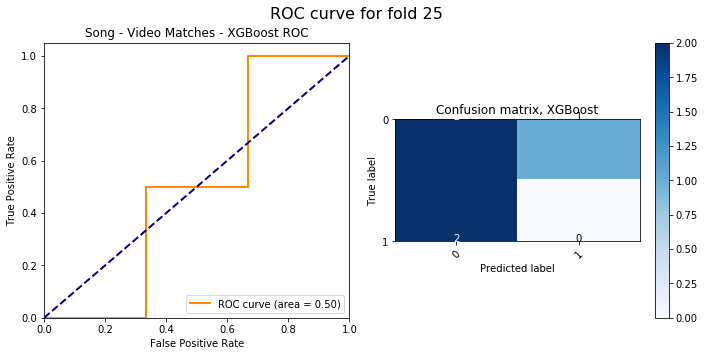

<Figure size 432x288 with 0 Axes>

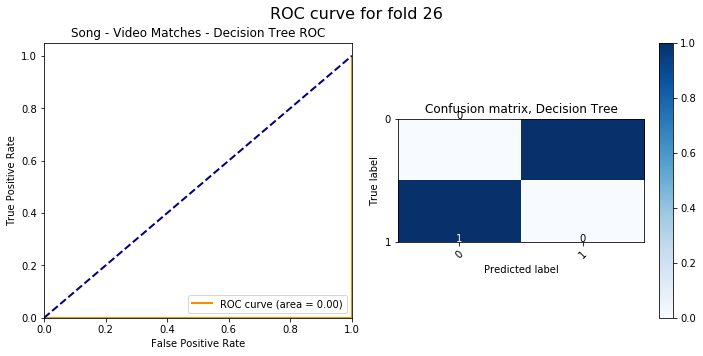

<Figure size 432x288 with 0 Axes>

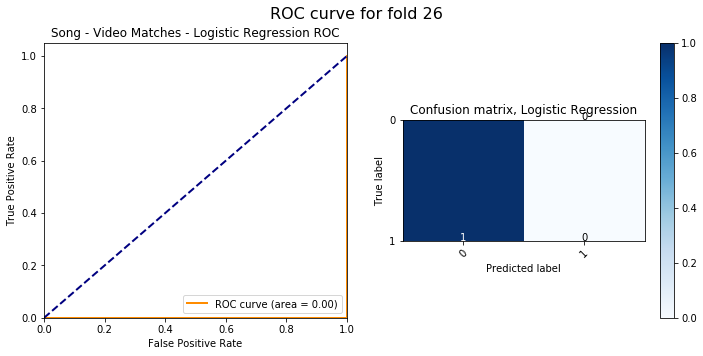

<Figure size 432x288 with 0 Axes>

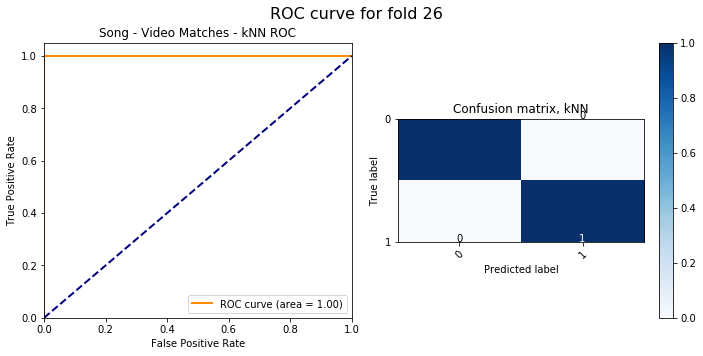

<Figure size 432x288 with 0 Axes>

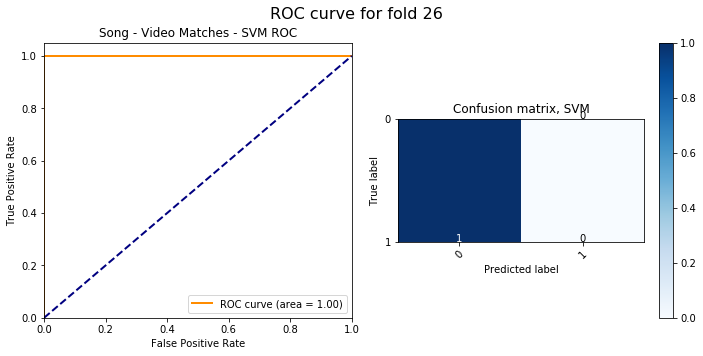

<Figure size 432x288 with 0 Axes>

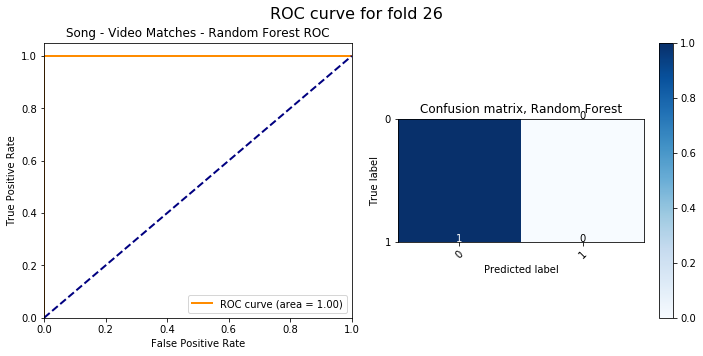

<Figure size 432x288 with 0 Axes>

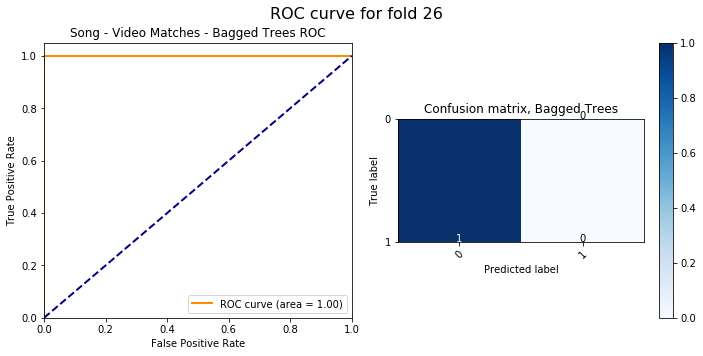

<Figure size 432x288 with 0 Axes>

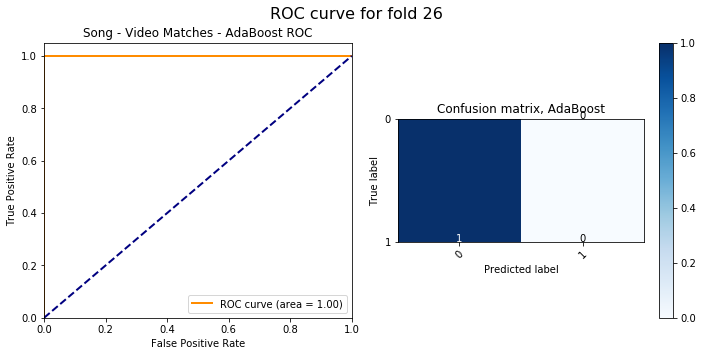

<Figure size 432x288 with 0 Axes>

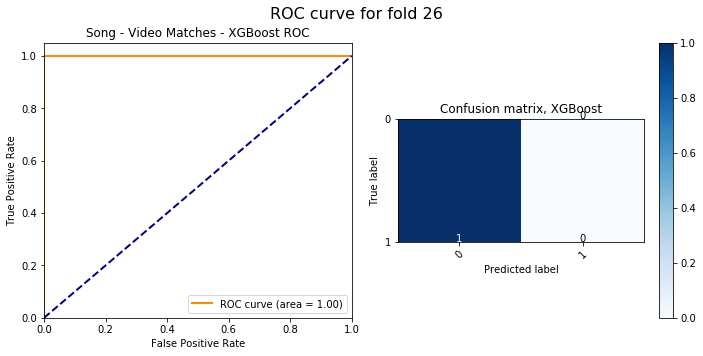

<Figure size 432x288 with 0 Axes>

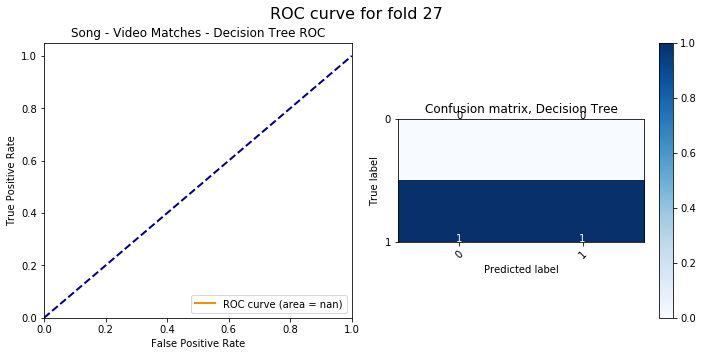

<Figure size 432x288 with 0 Axes>

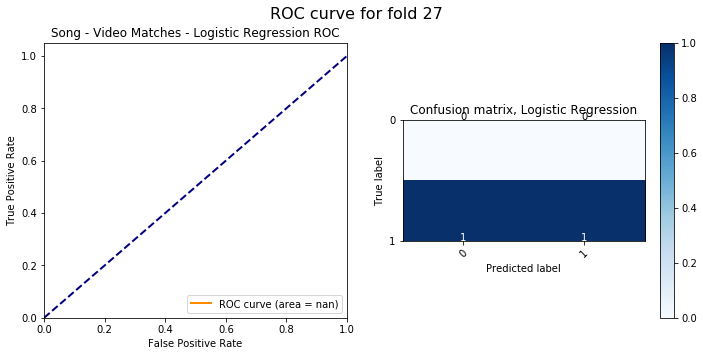

<Figure size 432x288 with 0 Axes>

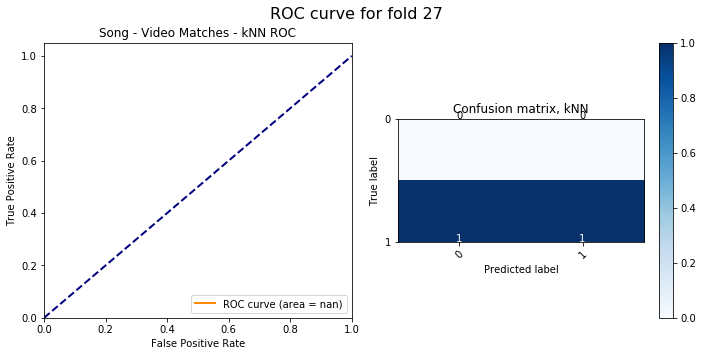

<Figure size 432x288 with 0 Axes>

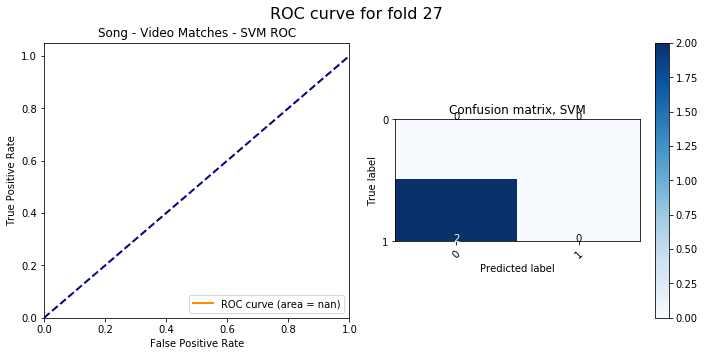

<Figure size 432x288 with 0 Axes>

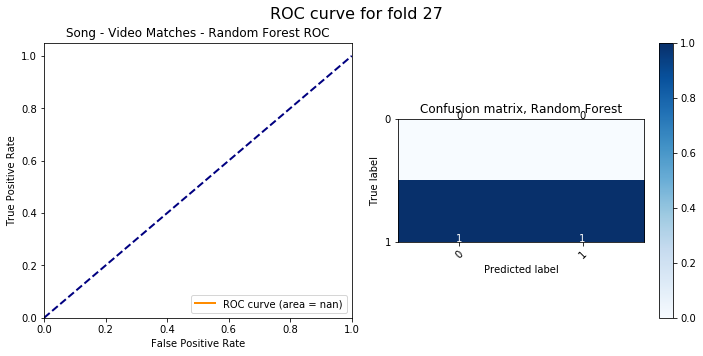

<Figure size 432x288 with 0 Axes>

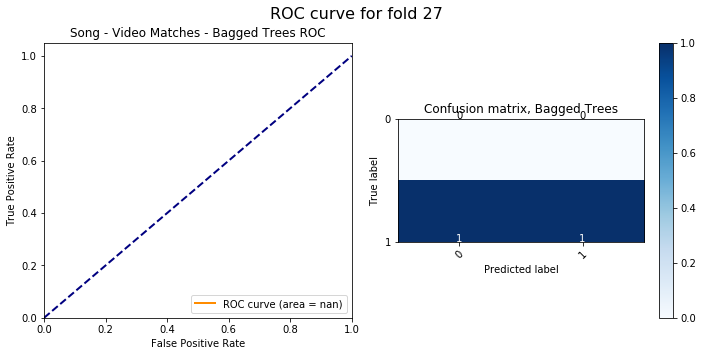

<Figure size 432x288 with 0 Axes>

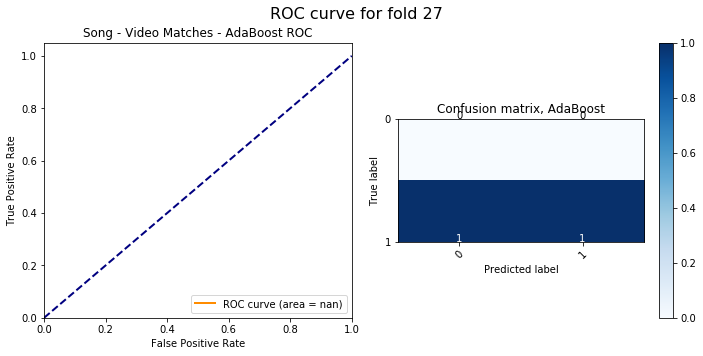

<Figure size 432x288 with 0 Axes>

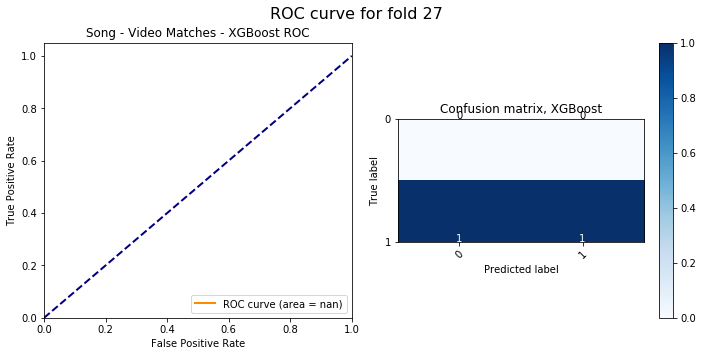

<Figure size 432x288 with 0 Axes>

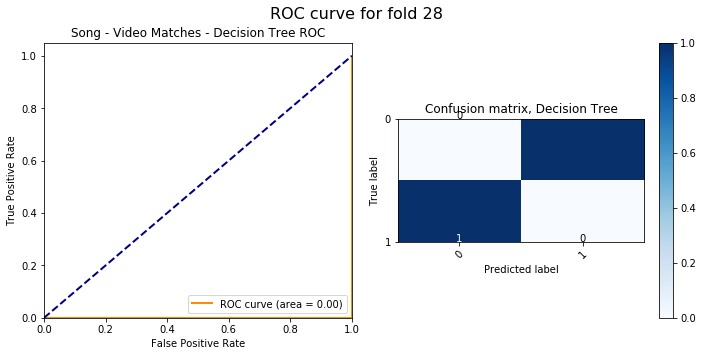

<Figure size 432x288 with 0 Axes>

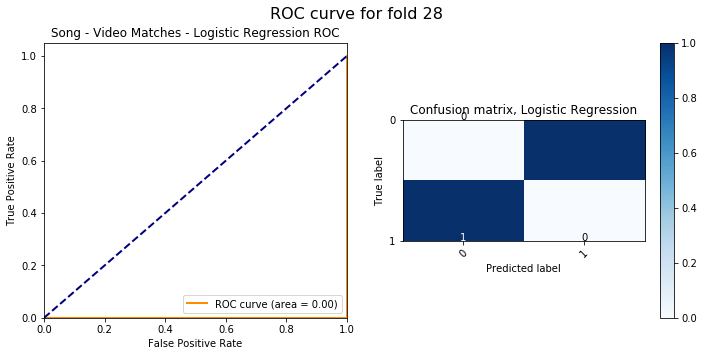

<Figure size 432x288 with 0 Axes>

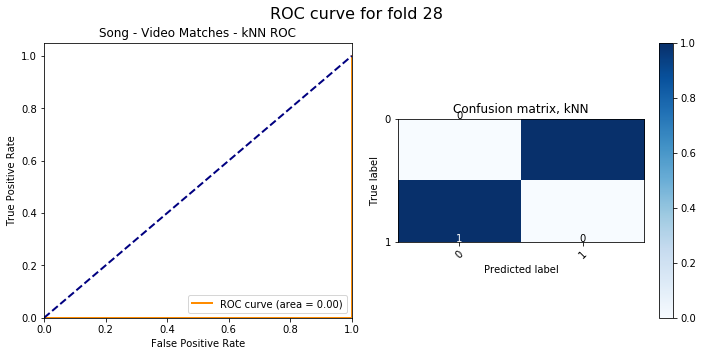

<Figure size 432x288 with 0 Axes>

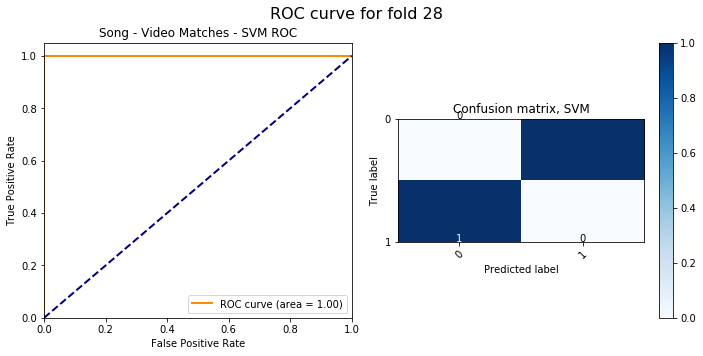

<Figure size 432x288 with 0 Axes>

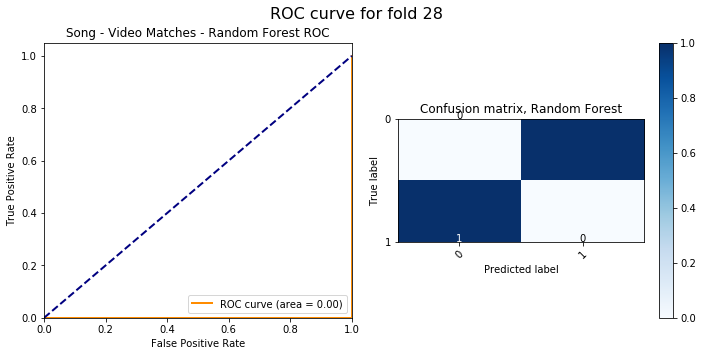

<Figure size 432x288 with 0 Axes>

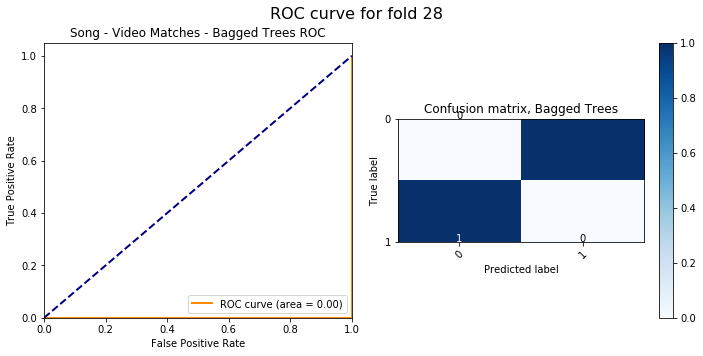

<Figure size 432x288 with 0 Axes>

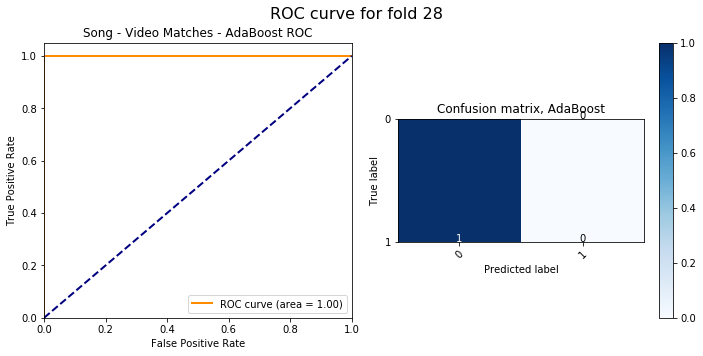

<Figure size 432x288 with 0 Axes>

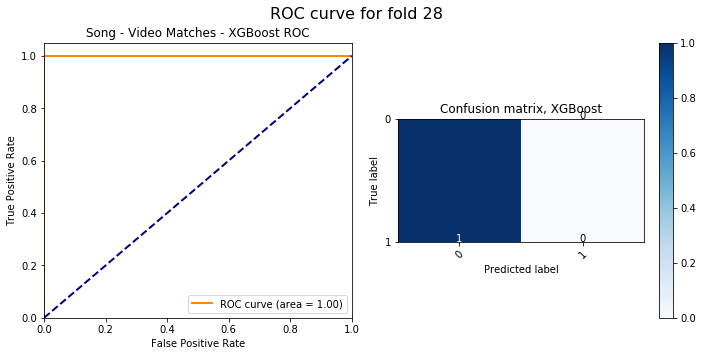

<Figure size 432x288 with 0 Axes>

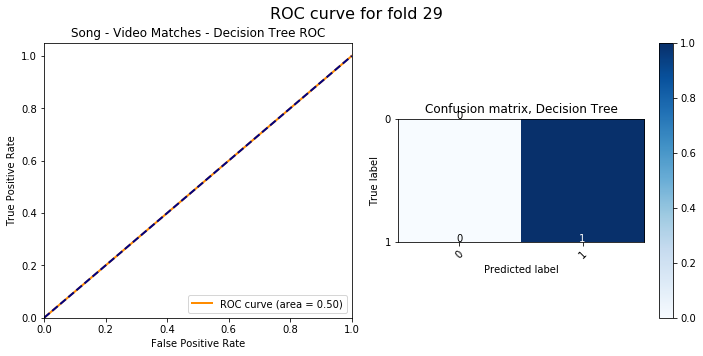

<Figure size 432x288 with 0 Axes>

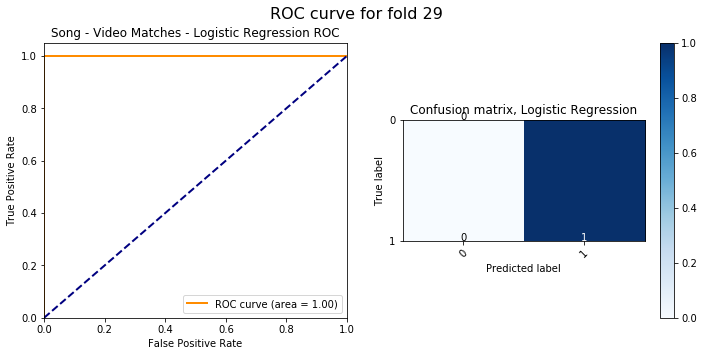

<Figure size 432x288 with 0 Axes>

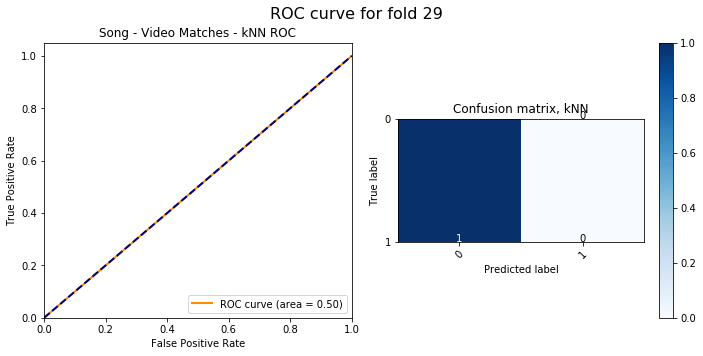

<Figure size 432x288 with 0 Axes>

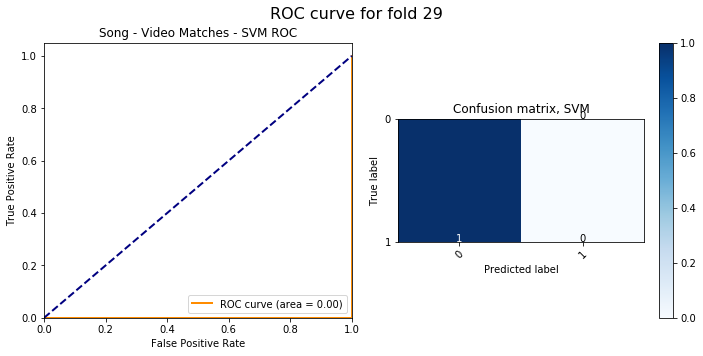

<Figure size 432x288 with 0 Axes>

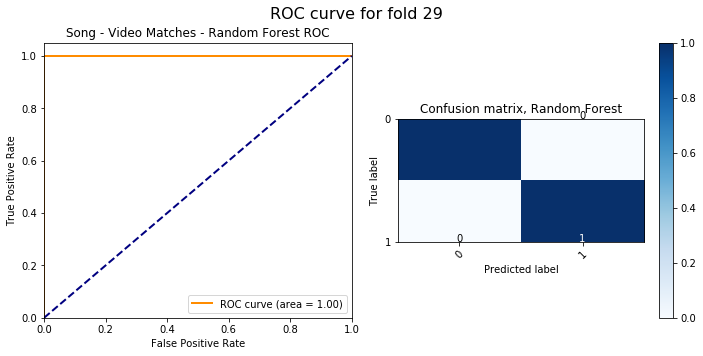

<Figure size 432x288 with 0 Axes>

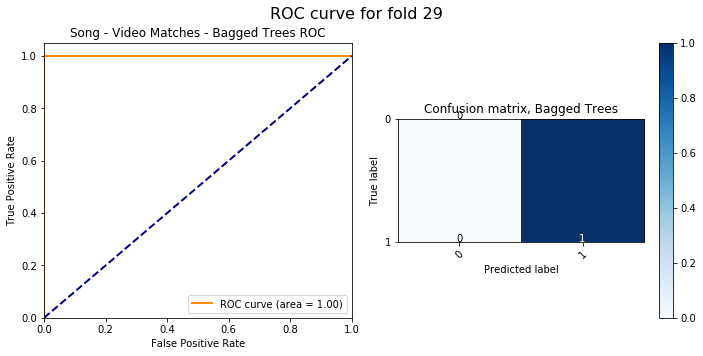

<Figure size 432x288 with 0 Axes>

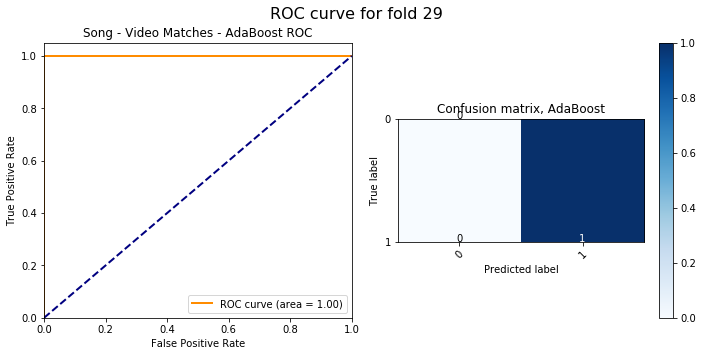

<Figure size 432x288 with 0 Axes>

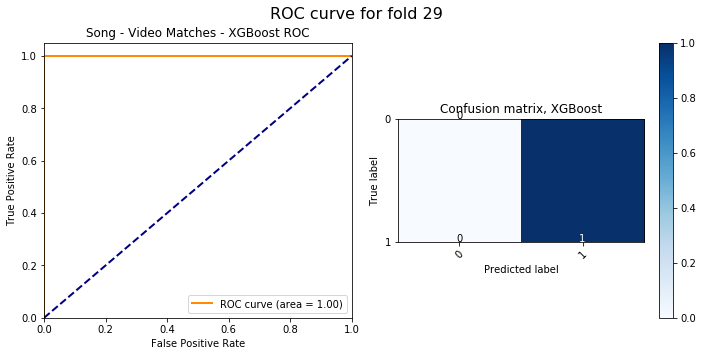

<Figure size 432x288 with 0 Axes>

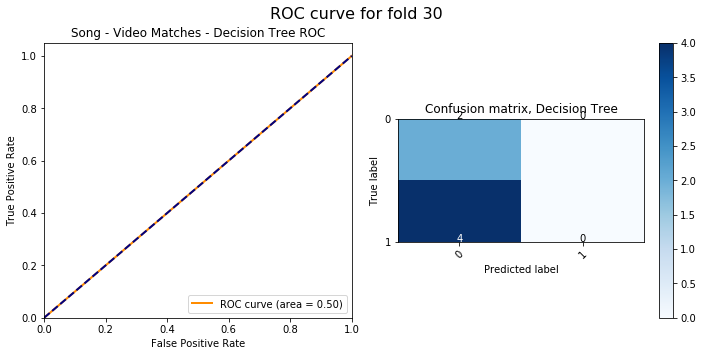

<Figure size 432x288 with 0 Axes>

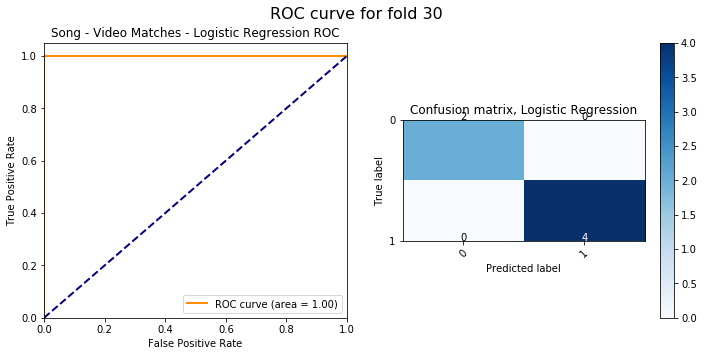

<Figure size 432x288 with 0 Axes>

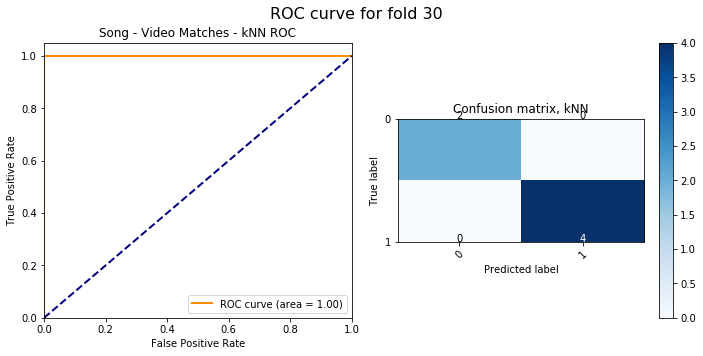

<Figure size 432x288 with 0 Axes>

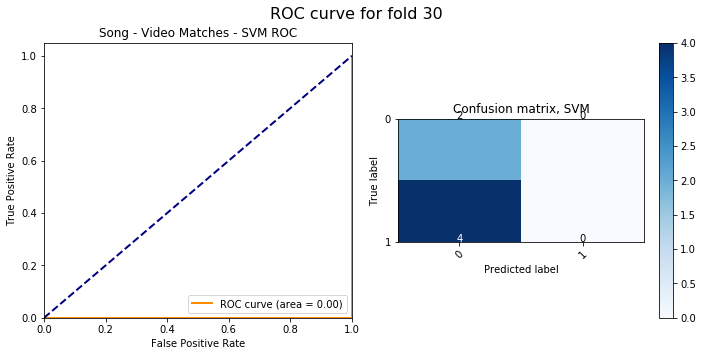

<Figure size 432x288 with 0 Axes>

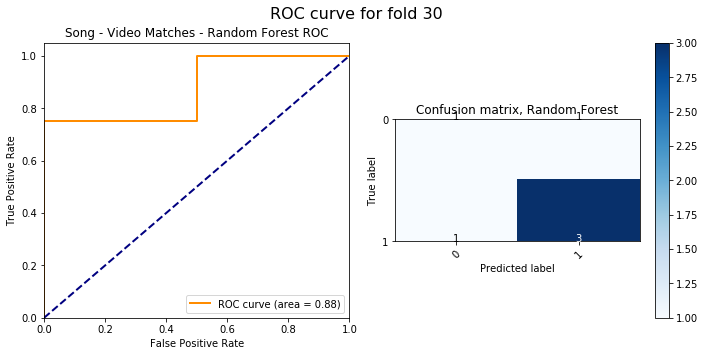

<Figure size 432x288 with 0 Axes>

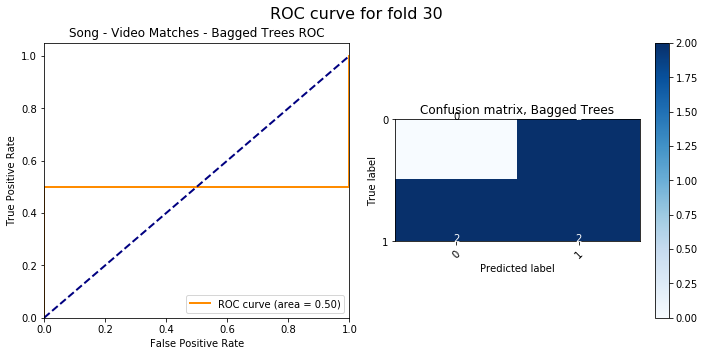

<Figure size 432x288 with 0 Axes>

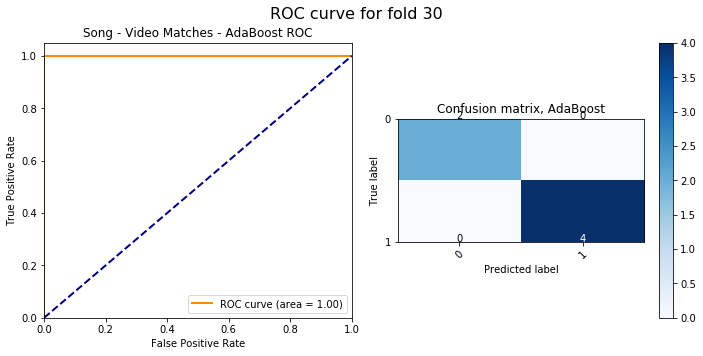

<Figure size 432x288 with 0 Axes>

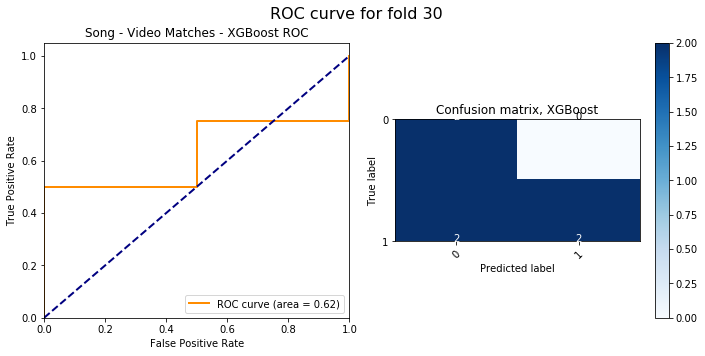

<Figure size 432x288 with 0 Axes>

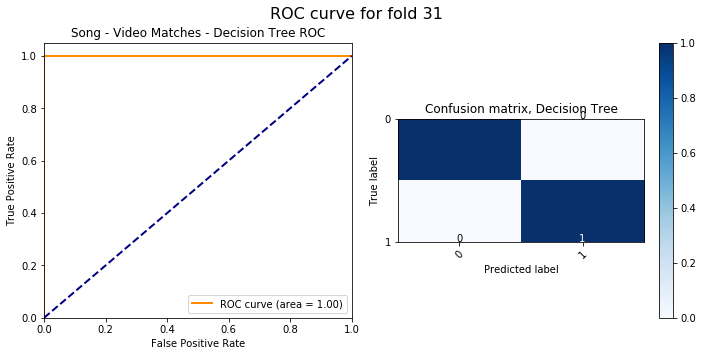

<Figure size 432x288 with 0 Axes>

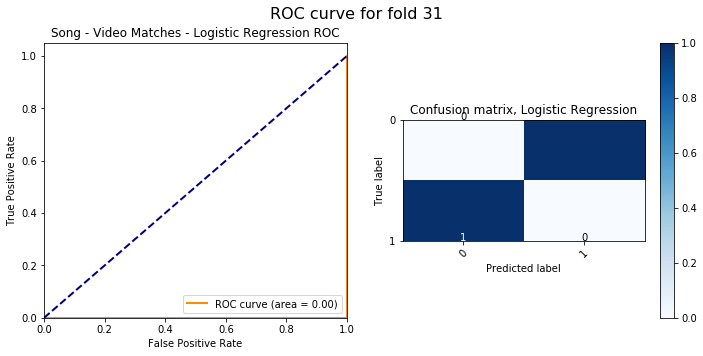

<Figure size 432x288 with 0 Axes>

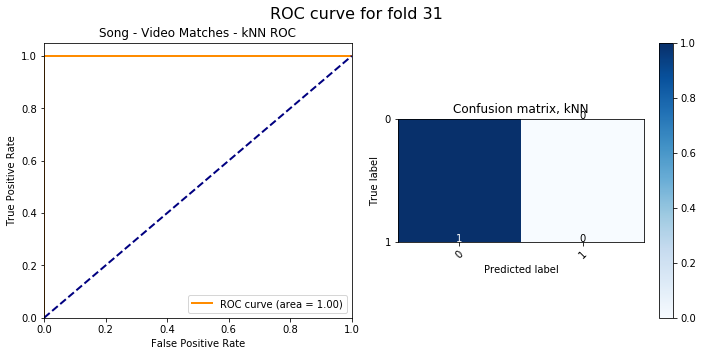

<Figure size 432x288 with 0 Axes>

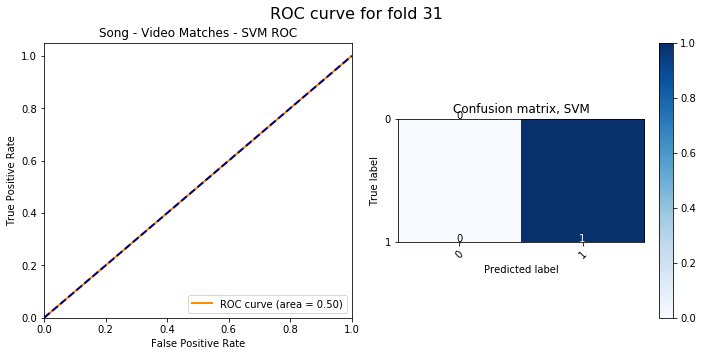

<Figure size 432x288 with 0 Axes>

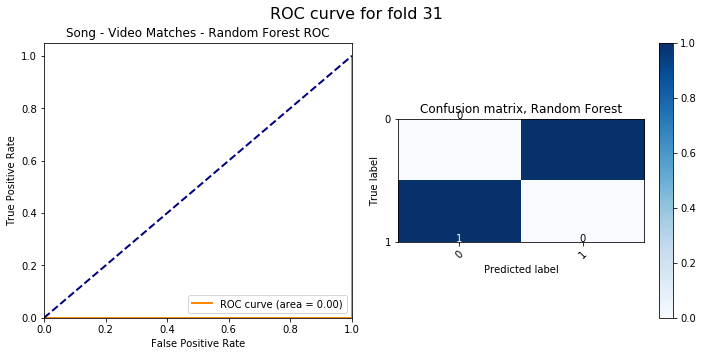

<Figure size 432x288 with 0 Axes>

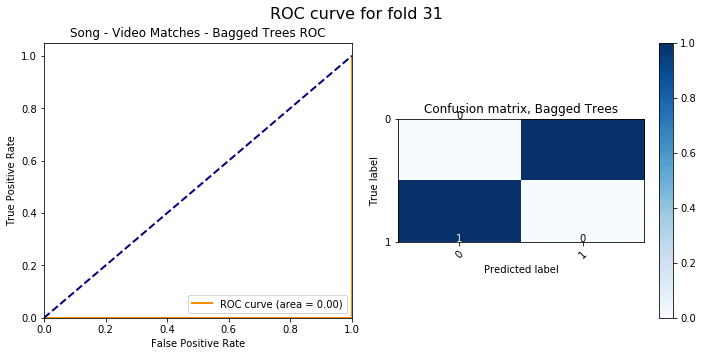

<Figure size 432x288 with 0 Axes>

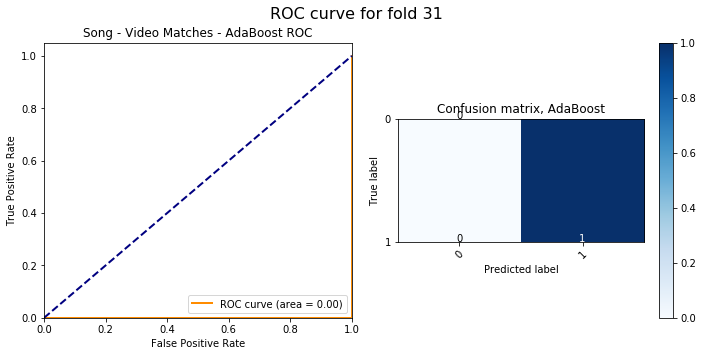

<Figure size 432x288 with 0 Axes>

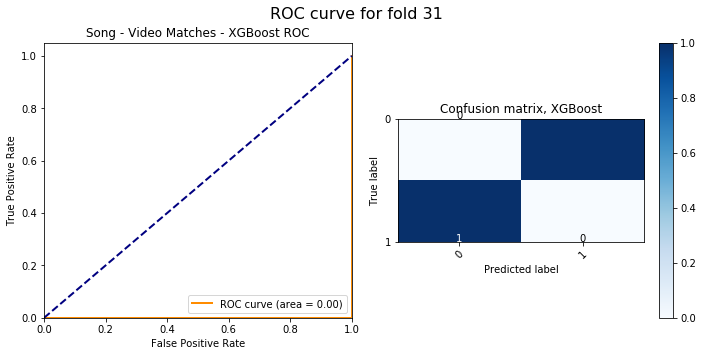

<Figure size 432x288 with 0 Axes>

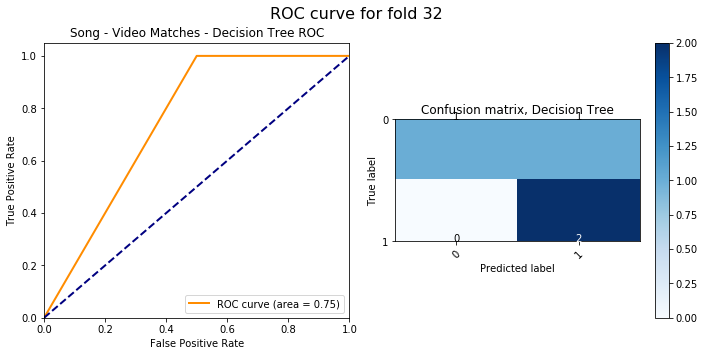

<Figure size 432x288 with 0 Axes>

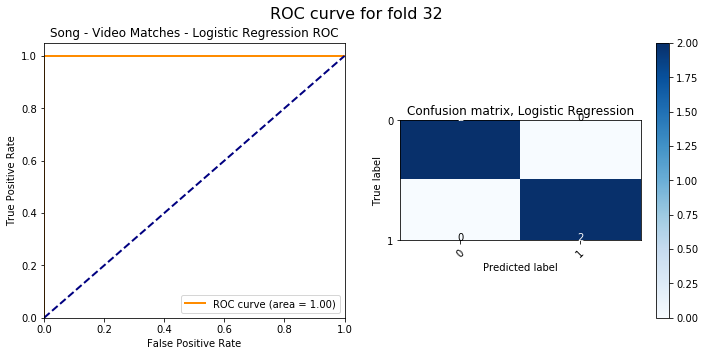

<Figure size 432x288 with 0 Axes>

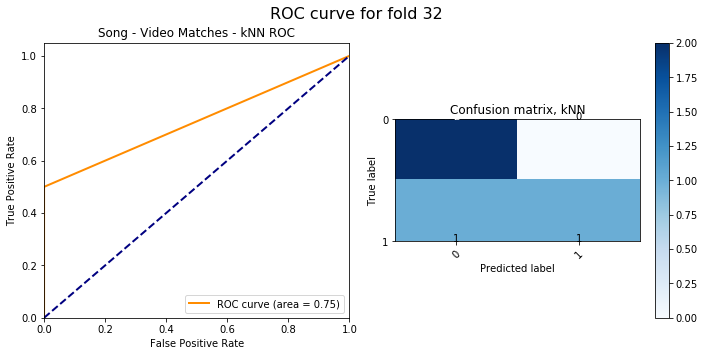

<Figure size 432x288 with 0 Axes>

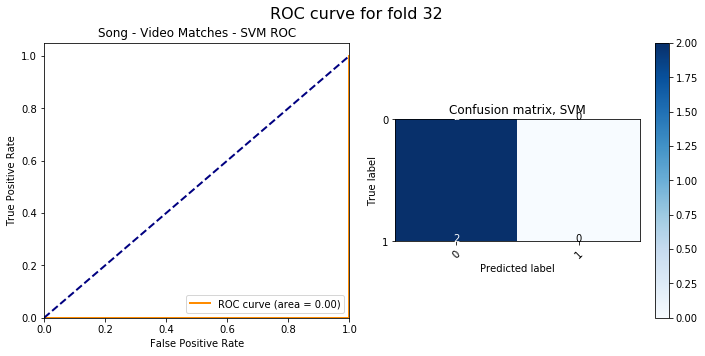

<Figure size 432x288 with 0 Axes>

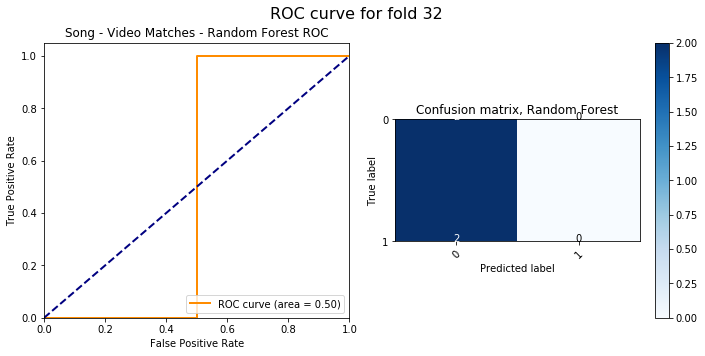

<Figure size 432x288 with 0 Axes>

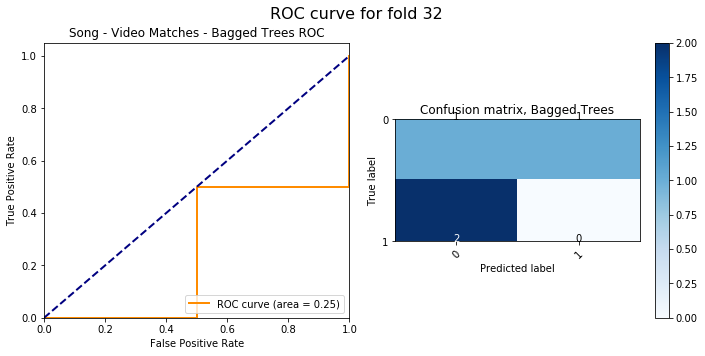

<Figure size 432x288 with 0 Axes>

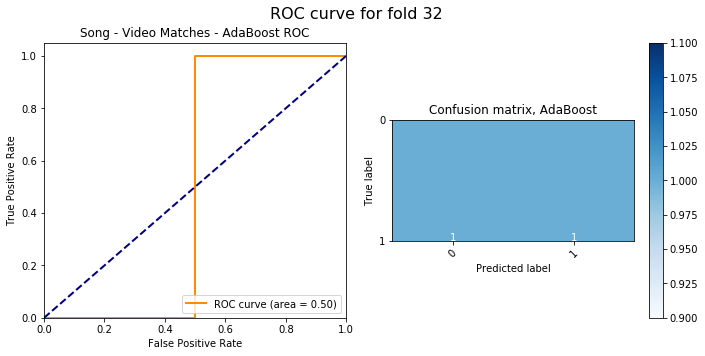

<Figure size 432x288 with 0 Axes>

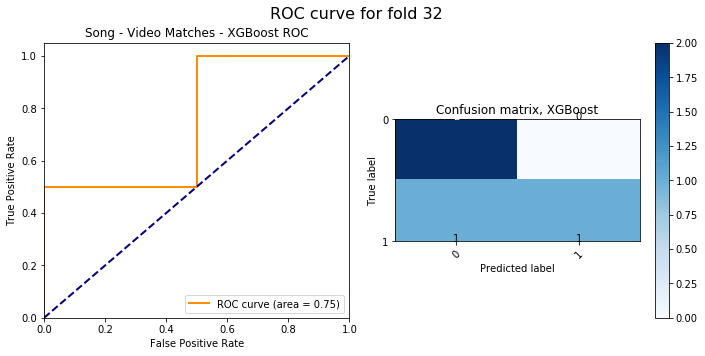

<Figure size 432x288 with 0 Axes>

In [40]:
i=0
for train_index, test_index in logo.split(X, y, groups):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]#%%
    # fit the transformations
    X_train = imp.fit_transform(X_train)
    X_test = imp.transform(X_test)

    X_train = min_max_scaler.fit_transform(X_train)
    X_test = min_max_scaler.transform(X_test)
    for name, model in models:
        # fit the model
        model.fit(X_train, y_train)
        predicted = model.predict(X_test)
        pred_proba = model.predict_proba(X_test)
        # gather metrics
        accuracy = model.score(X_test, y_test)
        precision = precision_score(y_test, predicted)
        recall = recall_score(y_test, predicted)
        f1 = f1_score(y_test, predicted)
        fold_results[name]['accuracy'].append(accuracy)
        fold_results[name]['precision'].append(precision)
        fold_results[name]['recall'].append(recall)
        fold_results[name]['f1'].append(f1)

        print("%03s: Accuracy: %0.2f Precision: %0.2f Recall: %0.2f F_1 score: %0.2f"
              % (name, accuracy, precision, recall, f1))
        plot_roc_and_confusion_matrix(y_test,
                                      predicted,
                                      pred_proba,
                                      iteration=i,
                                      model_name=name,
                                      save_dir=graphs_path)
    i+=1

In [41]:
from statistics import mean

compare={}

for model, results in fold_results.items():
    model_stats={}
    for metric, values in results.items():
        model_stats[metric] = mean(values)
    compare[model]=model_stats

In [42]:
compare

{'Decision Tree': {'accuracy': 0.49204545454545456,
  'precision': 0.452020202020202,
  'recall': 0.4664141414141414,
  'f1': 0.4367696099753516},
 'Logistic Regression': {'accuracy': 0.42184343434343435,
  'precision': 0.3396847260483624,
  'recall': 0.4101010101010101,
  'f1': 0.351056786350904},
 'kNN': {'accuracy': 0.5012626262626263,
  'precision': 0.40413752913752915,
  'recall': 0.41085858585858587,
  'f1': 0.3842446201141853},
 'SVM': {'accuracy': 0.3792929292929293,
  'precision': 0.17222222222222222,
  'recall': 0.3409090909090909,
  'f1': 0.20764790764790766},
 'Random Forest': {'accuracy': 0.5060606060606061,
  'precision': 0.3303030303030303,
  'recall': 0.3621212121212121,
  'f1': 0.3305194805194805},
 'Bagged Trees': {'accuracy': 0.4003787878787879,
  'precision': 0.19855699855699854,
  'recall': 0.21944444444444444,
  'f1': 0.19687371452077335},
 'AdaBoost': {'accuracy': 0.5401515151515152,
  'precision': 0.40909090909090906,
  'recall': 0.47575757575757577,
  'f1': 0.4